# <b>TrackML/HotelRank</b>: Elevating Revenue Performance Through Machine Learning and Deep Learning Techniques.

Revenue management is an important drive to make profits in the hotel industry, three main factors play an important role to get it right:  
    <ol>
    <li>Hotel room demand over time (demand forecast).</li>
    <li>Prediction of the future booking and inspection of cancellations</li>
    <li>Online hotel reputation.</li>
    </ol>
In this project we take in account each one through a linear combination of different scores that represent each item. Our customer, Blastnesss.com has provided the data. For customer requirements we give factors 1.5 to Hotel room demand, 0.8 to prediction of booking cancellations, 0.5 to Online reputation, so for business requirement we have:

$$ HotelRank = 1.5 * DemandScore + 0.8 * CancellationScore + 0.5 * ReviewScore + 0 * OtherEventsScore $$


Just to clarify:
- DemandScore : Model demand forecast.
- CancellationScore: Model booking cancellations.
- ReviewScore: Model online reputation.
- OtherEventsScore: Model external factors.

This work support both Google Colab and Jupyter Notebook. It also uses Spark. To run this notebook you need a valid wifi o internet connection because Spark-NLP downloads the tuned BERT transformer.


# <b>DemandScore</b>: Demand Timeseries Forecast Study.

The objective to section to concentrate ourselves to demand forecast with just Blastness dataset and nothing more:
- Clean the data provided and see patterns.
- Detect outliers in the demand score to use.
- If the series is not stationary, keep a backup and do differencing.
- Compare SARIMAX and Prophet time series forecasting algorithm to see which one to use and define a workflow.
- Create the demand score for each hotel using booking forecast in next temporal year frame.
- We leave to future work any crossdata about the demand related to weather and external events.

As first step for series forecasting we need to analyze

In [1]:
!pip install pandas numpy seaborn matplot scikit-learn pyarrow prophet statsmodels iplantuml datasets prophet rich imbalanced-learn skforecast holidays

## Dataset Creation from Property Management System and Cleaning.

The data that has been provided to use comes from Blastness Property Management System SQLServer and contained a lot of error so as first action we had to load the csv provided by [Blastness](https://www.blastness.com) and we create a dataset with columns names in English. When running this in the Google Colab we assume that the data file is in Google Drive in the folder, specified below.  This notebook has been developed with Anaconda Jupyter and tested also with Google Colab for compite intensive operations.

In [2]:
# check if i am in colab.
import os
if 'COLAB_GPU' in os.environ:
  from google.colab import drive
  os.environ['CAPSTONE_COLAB']='1'
  drive.mount('/content/drive', force_remount=True)
else:
  os.environ['CAPSTONE_COLAB']='0'

is_colab = int(os.environ.get('CAPSTONE_COLAB'))
if is_colab == 1:
  print('Good Luck working with Google Colab!')
else:
  print('You love the classic, beware that takes a bit with Deep Learning Classifier!')

You love the classic, beware that takes a bit with Deep Learning Classifier!


#### Loading the data.
Here we load the dataset that has been rpovided by Blastness and we merge all data in a unique DataFra,

In [3]:

import glob
import pandas as pd
pd.options.mode.copy_on_write = True
if is_colab:
  filelist = glob.glob('/content/drive/MyDrive/hoteldataset/*.csv')
else:
  filelist = glob.glob('./hoteldataset/*.csv')
hotelsbookings = []
column_mapping = {
    'Codice': 'Code',
    'Status': 'Status',
    'Canale': 'BookingChannel',
    'Arrivo': 'Arrival',
    'Partenza': 'Departure',
    'Notti': 'Nights',
    'Totale': 'Total',
    'Data acquisto': 'PurchaseDate',
    'Dispositivo': 'BookingDevice',
    'Data Ultima Modifica/Cancellazione': 'LastModified'
}
for idx,f in enumerate(filelist):
    df = pd.read_csv(f)
    select_columns = list(column_mapping.keys())
    current_df = df[select_columns]
    remap = current_df.rename(columns=column_mapping)
    hotel_id = ""
    if idx < 9:
        hotel_id=f'00{idx+1}'
    else:
        hotel_id=f'0{idx+1}'

    remap['HotelId'] = hotel_id
    hotelsbookings.append(remap)
hotelsbookings[9].head()


/tmp/ipykernel_519538/1013048096.py:22: DtypeWarning: Columns (23,53,62,68,70,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_519538/1013048096.py:22: DtypeWarning: Columns (23,52,55,58,59,60,81,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_519538/1013048096.py:22: DtypeWarning: Columns (23,49,55,59,81,87,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_519538/1013048096.py:22: DtypeWarning: Columns (23,52,53,55,58,59,60,62,68,70,81,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


Code      Status BookingChannel     Arrival   Departure  Nights  \
0  19887PMCMTT6  Cancellata           Sito  23/10/2021  30/10/2021       0   
1  19887FBFWGZ7  Confermata           Sito  31/07/2021  06/08/2021       6   
2  19887JIZNTR8  Confermata           Sito  23/10/2021  26/10/2021       3   
3  19887CNIHY10  Confermata           Sito  23/11/2022  28/11/2022       5   
4  19887GOAMJ11  Confermata           Sito  11/10/2022  15/10/2022       4   

     Total PurchaseDate BookingDevice         LastModified HotelId  
0     0,00   31/05/2021       Website  31/05/2021 17:37:31     010  
1  2894,25   08/07/2021       Website  08/07/2021 22:23:51     010  
2  2142,00   04/10/2021       Website  04/10/2021 21:24:49     010  
3  3696,00   01/06/2022       Website  01/06/2022 10:46:15     010  
4  4488,00   26/06/2022       Website  26/06/2022 04:14:05     010

Now we've a dataset created by really industrial data. Note that the import has some showed us some bad data that we skipped.

In [4]:
merged_df = pd.concat(hotelsbookings, ignore_index=True)
# Display the merged DataFrame
print("Merged DataFrame:")
print(merged_df)

Merged DataFrame:
                         Code      Status BookingChannel     Arrival  \
0       1400576136/1204413850  Cancellata    Booking.com  22/07/2017   
1       1240874198/1204820657  Cancellata    Booking.com  15/07/2017   
2       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
3       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
4       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
...                       ...         ...            ...         ...   
151852           19887FIHJR22  Confermata           Sito  19/10/2023   
151853           19887DOSJP23  Confermata           Sito  10/06/2023   
151854           19887KTDJJ24  Confermata           Sito  18/07/2023   
151855           19887LNQHJ25  Confermata           Sito  24/04/2023   
151856           19887IENNC26  Confermata           Sito  18/09/2023   

         Departure  Nights    Total PurchaseDate BookingDevice  \
0       29/07/2017       0     0,00   01/01/2017   

Ok, we've seen a lot of not known or bad data. Just clean it. We want order by date, in descending mode and take only the booking from 2019 to 2023. We might restrict further the dataset if it is needed.

In [5]:
merged_df.head()

Code      Status BookingChannel     Arrival   Departure  \
0  1400576136/1204413850  Cancellata    Booking.com  22/07/2017  29/07/2017   
1  1240874198/1204820657  Cancellata    Booking.com  15/07/2017  02/08/2017   
2  1656344835/1204828455  Cancellata    Booking.com  22/07/2017  09/08/2017   
3  1656344835/1204828455  Cancellata    Booking.com  22/07/2017  09/08/2017   
4  1656344835/1204828455  Cancellata    Booking.com  22/07/2017  09/08/2017   

   Nights Total PurchaseDate BookingDevice         LastModified HotelId  
0       0  0,00   01/01/2017           NaN  01/01/2017 15:27:39     001  
1       0  0,00   01/01/2017           NaN  01/01/2017 23:13:49     001  
2       0  0,00   01/01/2017           NaN  11/01/2017 21:59:16     001  
3       0  0,00   01/01/2017           NaN  10/01/2017 22:10:56     001  
4       0  0,00   01/01/2017           NaN  11/01/2017 21:59:16     001

Let's sort by arrival! Still we've things in Italian.

In [6]:
merged_df['Arrival'] = pd.to_datetime(merged_df['Arrival'],dayfirst=True)
sorted_bookings_df = merged_df.sort_values(by='Arrival', ascending=False)
filtered_df = sorted_bookings_df.loc[sorted_bookings_df['HotelId'] == '010']
filtered_df.head()

Code      Status BookingChannel    Arrival   Departure  \
151852  19887FIHJR22  Confermata           Sito 2023-10-19  22/10/2023   
151849  19887VFAUN19  Confermata           Sito 2023-09-26  28/09/2023   
151856  19887IENNC26  Confermata           Sito 2023-09-18  21/09/2023   
151850  19887VNOHO20  Confermata           Sito 2023-08-25  27/08/2023   
151847  19887AZGQK17  Confermata           Sito 2023-08-01  04/08/2023   

        Nights    Total PurchaseDate BookingDevice         LastModified  \
151852       3  3080,00   11/03/2023       Website  11/03/2023 10:15:06   
151849       2  1760,00   02/02/2023       Website  02/02/2023 16:43:04   
151856       3  3168,00   03/06/2023       Website  03/06/2023 12:55:03   
151850       2  1496,00   09/03/2023       Website  09/03/2023 20:00:03   
151847       3  1980,00   01/12/2022       Website  01/12/2022 18:41:16   

       HotelId  
151852     010  
151849     010  
151856     010  
151850     010  
151847     010

The CSV data that comes from the Property Management System is badly formed and when Panda goes to read it everything is intepreted as a string so we need to clean it. So we have to:
- Change Arriva, Departure, LastModified from String to Datatime.
- Change Nights and Total to numeric.
- Add the timestamp numeric version for Arrival, Departure, Timestamp.

In [7]:
# Filtering for HotelId '001'
nan_rows = sorted_bookings_df[sorted_bookings_df['Arrival'].isna()]
print("Rows with NaN in 'Arrival':", len(nan_rows))
nan_rows = sorted_bookings_df[sorted_bookings_df['Departure'].isna()]
print("Rows with NaN in 'Departure':", len(nan_rows))
# conversion in datetime
sorted_bookings_df['Arrival'] = pd.to_datetime(sorted_bookings_df['Arrival'], errors='coerce', dayfirst=True)
sorted_bookings_df['Departure'] = pd.to_datetime(sorted_bookings_df['Departure'], errors='coerce', dayfirst=True)
sorted_bookings_df['LastModified'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce', dayfirst=True)
sorted_bookings_df['PurchaseDate'] = pd.to_datetime(sorted_bookings_df['PurchaseDate'], errors='coerce', dayfirst=True)
# we want to make sure that are numerical data
sorted_bookings_df['Total'] = sorted_bookings_df['Total'].str.replace(',', '.').astype(float)
sorted_bookings_df['Total'] = pd.to_numeric(sorted_bookings_df['Total'])
sorted_bookings_df['Nights'] = pd.to_numeric(sorted_bookings_df['Nights'])
# add timestamp
sorted_bookings_df['Arrival_Timestamp'] = sorted_bookings_df['Arrival'].astype('int64')
sorted_bookings_df['Departure_Timestamp'] = sorted_bookings_df['Departure'].astype('int64')
sorted_bookings_df['LastModified_Timestamp'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce')
sorted_bookings_df['Purchase_Timestamp'] = sorted_bookings_df['PurchaseDate'].astype('int64')
sorted_bookings_df.head()



Rows with NaN in 'Arrival': 0
Rows with NaN in 'Departure': 0


Code      Status BookingChannel    Arrival  Departure  \
20758           H6382AEX6419  Confermata           Sito 2024-05-05 2024-05-08   
20757           A6382VHL6418  Cancellata           Sito 2024-05-05 2024-05-08   
20680           B6382JWZ6342  Cancellata           Sito 2024-05-05 2024-05-08   
20693           R6382UMZ6352  Cancellata           Sito 2024-05-04 2024-05-08   
60317  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   

       Nights   Total PurchaseDate BookingDevice        LastModified HotelId  \
20758       3  1010.0   2023-06-22       Website 2023-06-22 19:53:46     004   
20757       0     0.0   2023-06-22        Mobile 2023-06-22 19:07:31     004   
20680       0     0.0   2023-06-15        Mobile 2023-06-15 21:12:34     004   
20693       0     0.0   2023-06-17        Mobile 2023-06-17 05:21:46     004   
60317       0     0.0   2023-03-15           NaN 2023-03-15 21:44:16     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
20758  1714867200000000000  1715126400000000000    2023-06-22 19:53:46   
20757  1714867200000000000  1715126400000000000    2023-06-22 19:07:31   
20680  1714867200000000000  1715126400000000000    2023-06-15 21:12:34   
20693  1714780800000000000  1715126400000000000    2023-06-17 05:21:46   
60317  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   

        Purchase_Timestamp  
20758  1687392000000000000  
20757  1687392000000000000  
20680  1686787200000000000  
20693  1686960000000000000  
60317  1678838400000000000

Blastness has also provided the City where the Hotel is.
```
hotel_to_city = {
    '001': "Rome, Italy",
    '002': "Naples, Italy",
    '003': "Florence, Italy",
    '004': "Florence, Italy",
    '005': "Naples, Italy",
    '006': "Brindisi, Italy",
    '007': "Latina, Italy",
    '008': "Olbia, Sardinia, Italy",
    '009': "Chamonix-Mont-Blanc, France",
    '010': "Rome, Italy",
}
```

With this step the first version a clean dataset is complete.

In [8]:
coordinate_to_city = {
    '001': "Rome",
    '002': "Naples",
    '003': "Florence",
    '004': "Florence",
    '005': "Naples",
    '006': "Brindisi",
    '007': "Latina",
    '008': "Olbia",
    '009': "Chamonix-Mont-Blanc",
    '010': "Rome",
}

# Function to get the city name based on HotelId
def get_city(hotel_id):
    return coordinate_to_city.get(hotel_id, "Unknown")

# Add the City column based on the HotelId
sorted_bookings_df['City'] = sorted_bookings_df['HotelId'].apply(get_city)

We want also add the Season feature to distinguish between seasons.

In [9]:
# we clean unknown
sorted_bookings_df['BookingDevice'].fillna('Unknown', inplace=True)
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
sorted_bookings_df['Season'] = sorted_bookings_df['Arrival'].apply(get_season)
sorted_bookings_df.head()



Code      Status BookingChannel    Arrival  Departure  \
20758           H6382AEX6419  Confermata           Sito 2024-05-05 2024-05-08   
20757           A6382VHL6418  Cancellata           Sito 2024-05-05 2024-05-08   
20680           B6382JWZ6342  Cancellata           Sito 2024-05-05 2024-05-08   
20693           R6382UMZ6352  Cancellata           Sito 2024-05-04 2024-05-08   
60317  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   

       Nights   Total PurchaseDate BookingDevice        LastModified HotelId  \
20758       3  1010.0   2023-06-22       Website 2023-06-22 19:53:46     004   
20757       0     0.0   2023-06-22        Mobile 2023-06-22 19:07:31     004   
20680       0     0.0   2023-06-15        Mobile 2023-06-15 21:12:34     004   
20693       0     0.0   2023-06-17        Mobile 2023-06-17 05:21:46     004   
60317       0     0.0   2023-03-15           NaN 2023-03-15 21:44:16     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
20758  1714867200000000000  1715126400000000000    2023-06-22 19:53:46   
20757  1714867200000000000  1715126400000000000    2023-06-22 19:07:31   
20680  1714867200000000000  1715126400000000000    2023-06-15 21:12:34   
20693  1714780800000000000  1715126400000000000    2023-06-17 05:21:46   
60317  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   

        Purchase_Timestamp      City  Season  
20758  1687392000000000000  Florence  Spring  
20757  1687392000000000000  Florence  Spring  
20680  1686787200000000000  Florence  Spring  
20693  1686960000000000000  Florence  Spring  
60317  1678838400000000000  Brindisi  Spring

Now before going further and doing descriptive statistics we neeed to know is there are still NaN. It is ok we store for future purposes the dataset in parquet file.

In [10]:
# Check if any row in any column is NaN
has_nan = sorted_bookings_df.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
# Display rows with any NaN values
rows_with_nan = sorted_bookings_df[sorted_bookings_df.isna().any(axis=1)]
print("Rows with NaN values:")
rows_with_nan.head()


Does the DataFrame contain any NaN values? True
Rows with NaN values:


Code      Status BookingChannel    Arrival  Departure  \
60317  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   
60316  2262350217/4142372765  Cancellata    Booking.com 2024-03-30 2024-04-06   
60315  2694489967/4142285639  Cancellata    Booking.com 2024-03-30 2024-04-06   
60754  3250233143/4271797361  Cancellata    Booking.com 2024-03-29 2024-04-01   
60753  3250233143/4271797361  Confermata    Booking.com 2024-03-28 2024-03-31   

       Nights  Total PurchaseDate BookingDevice        LastModified HotelId  \
60317       0    0.0   2023-03-15           NaN 2023-03-15 21:44:16     006   
60316       0    0.0   2023-03-15           NaN 2023-03-15 21:22:16     006   
60315       0    0.0   2023-03-15           NaN 2023-03-15 20:31:35     006   
60754       0    0.0   2023-05-28           NaN 2023-05-28 13:55:50     006   
60753       3  661.5   2023-05-28           NaN 2023-05-28 13:55:50     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
60317  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   
60316  1711756800000000000  1712361600000000000    2023-03-15 21:22:16   
60315  1711756800000000000  1712361600000000000    2023-03-15 20:31:35   
60754  1711670400000000000  1711929600000000000    2023-05-28 13:55:50   
60753  1711584000000000000  1711843200000000000    2023-05-28 13:55:50   

        Purchase_Timestamp      City  Season  
60317  1678838400000000000  Brindisi  Spring  
60316  1678838400000000000  Brindisi  Spring  
60315  1678838400000000000  Brindisi  Spring  
60754  1685232000000000000  Brindisi  Spring  
60753  1685232000000000000  Brindisi  Spring

The BookingChannel columns contains bad data, we have to act:
- Rename all NaN to Unknown.
- Change the Italian Sito to Hotel Website.
In second instance we want restrict the period to study.

In [11]:
sorted_bookings_df['BookingChannel'] = sorted_bookings_df['BookingChannel'].fillna('Unknown')
sorted_bookings_df['BookingChannel'] = sorted_bookings_df['BookingChannel'].replace('Site', 'Hotel Website')
sorted_bookings_df.head()


Code      Status BookingChannel    Arrival  Departure  \
20758           H6382AEX6419  Confermata           Sito 2024-05-05 2024-05-08   
20757           A6382VHL6418  Cancellata           Sito 2024-05-05 2024-05-08   
20680           B6382JWZ6342  Cancellata           Sito 2024-05-05 2024-05-08   
20693           R6382UMZ6352  Cancellata           Sito 2024-05-04 2024-05-08   
60317  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   

       Nights   Total PurchaseDate BookingDevice        LastModified HotelId  \
20758       3  1010.0   2023-06-22       Website 2023-06-22 19:53:46     004   
20757       0     0.0   2023-06-22        Mobile 2023-06-22 19:07:31     004   
20680       0     0.0   2023-06-15        Mobile 2023-06-15 21:12:34     004   
20693       0     0.0   2023-06-17        Mobile 2023-06-17 05:21:46     004   
60317       0     0.0   2023-03-15           NaN 2023-03-15 21:44:16     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
20758  1714867200000000000  1715126400000000000    2023-06-22 19:53:46   
20757  1714867200000000000  1715126400000000000    2023-06-22 19:07:31   
20680  1714867200000000000  1715126400000000000    2023-06-15 21:12:34   
20693  1714780800000000000  1715126400000000000    2023-06-17 05:21:46   
60317  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   

        Purchase_Timestamp      City  Season  
20758  1687392000000000000  Florence  Spring  
20757  1687392000000000000  Florence  Spring  
20680  1686787200000000000  Florence  Spring  
20693  1686960000000000000  Florence  Spring  
60317  1678838400000000000  Brindisi  Spring

Now I want to restrict the timing interval between 2020 and 2023 as customer requirement.

In [12]:
start_date = '2020-01-01'
end_date = '2023-12-31'
sorted_bookings_df.head()
datetime_columns = ['Arrival', 'Departure', 'PurchaseDate', 'LastModified']
for col in datetime_columns:
    sorted_bookings_df[col] = pd.to_datetime(sorted_bookings_df[col])
hb_dataset = sorted_bookings_df[(sorted_bookings_df['Arrival'] >= start_date) & (sorted_bookings_df['Arrival'] <= end_date)]
# Check if any row in any column is NaN
has_nan = hb_dataset.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
if has_nan:
# Display rows with any NaN values
    for colname in hb_dataset.columns:
      rows_with_nan = hb_dataset[colname]
      if rows_with_nan.isna().any():
        print(f"Feature with NaN values: {colname}. We had to take care of it.")
else:
    print('The dataset is ready some descriptive statistics')

Does the DataFrame contain any NaN values? True
Feature with NaN values: BookingDevice. We had to take care of it.


In [13]:
# Save the filtered DataFrame to a Parquet file
parquet_file = 'filtered_data.parquet'
hb_dataset.to_parquet(parquet_file)
print(f"Filtered DataFrame saved to {parquet_file}")

Filtered DataFrame saved to filtered_data.parquet


We saved the data in parquet file as backup. It might be useful in data inspection.

In [14]:
hb_dataset.head(10)

Code      Status BookingChannel    Arrival  Departure  \
60820  2493115910/4283897556  Confermata    Booking.com 2023-12-28 2024-01-04   
60923  2745673363/4308678121  Confermata    Booking.com 2023-12-27 2024-01-03   
61034  3958853713/4337114239  Confermata    Booking.com 2023-12-26 2024-01-02   
60873  3854867487/4296773334  Confermata    Booking.com 2023-12-26 2024-01-02   
60750  2359160563/4271754038  Confermata    Booking.com 2023-12-23 2023-12-31   
60751  2359160563/4271754066  Confermata    Booking.com 2023-12-23 2023-12-31   
60752  2359160563/4271754047  Confermata    Booking.com 2023-12-23 2023-12-31   
60035  2165812668/4071186490  Confermata    Booking.com 2023-12-23 2023-12-30   
60034  2165812668/4071186490  Cancellata    Booking.com 2023-12-23 2023-12-30   
60728  3626349779/4266644156  Confermata    Booking.com 2023-12-22 2023-12-29   

       Nights    Total PurchaseDate BookingDevice        LastModified HotelId  \
60820       7  4637.25   2023-06-04           NaN 2023-06-04 09:27:30     006   
60923       7  3892.05   2023-06-17           NaN 2023-06-17 18:09:53     006   
61034       7  2766.15   2023-07-02           NaN 2023-07-02 16:35:28     006   
60873       7  2620.35   2023-06-11           NaN 2023-06-11 10:53:57     006   
60750       8  2997.00   2023-05-28           NaN 2023-05-28 13:16:41     006   
60751       8  3240.00   2023-05-28           NaN 2023-05-28 13:16:41     006   
60752       8  3126.60   2023-05-28           NaN 2023-05-28 13:16:41     006   
60035       7  3154.50   2023-02-03           NaN 2023-05-10 23:21:21     006   
60034       0     0.00   2023-02-03           NaN 2023-05-10 23:21:21     006   
60728       7  3001.50   2023-05-25           NaN 2023-05-25 10:41:31     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
60820  1703721600000000000  1704326400000000000    2023-06-04 09:27:30   
60923  1703635200000000000  1704240000000000000    2023-06-17 18:09:53   
61034  1703548800000000000  1704153600000000000    2023-07-02 16:35:28   
60873  1703548800000000000  1704153600000000000    2023-06-11 10:53:57   
60750  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   
60751  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   
60752  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   
60035  1703289600000000000  1703894400000000000    2023-05-10 23:21:21   
60034  1703289600000000000  1703894400000000000    2023-05-10 23:21:21   
60728  1703203200000000000  1703808000000000000    2023-05-25 10:41:31   

        Purchase_Timestamp      City  Season  
60820  1685836800000000000  Brindisi  Winter  
60923  1686960000000000000  Brindisi  Winter  
61034  1688256000000000000  Brindisi  Winter  
60873  1686441600000000000  Brindisi  Winter  
60750  1685232000000000000  Brindisi  Winter  
60751  1685232000000000000  Brindisi  Winter  
60752  1685232000000000000  Brindisi  Winter  
60035  1675382400000000000  Brindisi  Winter  
60034  1675382400000000000  Brindisi  Winter  
60728  1684972800000000000  Brindisi  Winter

We begin by analyzing and understanding the categorical variables "Status" and "Booking Devices" and applying an Ordinal Encoder for their transformation. For the "Status" category, we anticipate the following values: Confermata (Confirmed), Cancellata (Cancelled), and Modificata (Modified). This encoding will later be instrumental in calculating the cancellation score.

In [15]:
hb_dataset['Status'].unique()

array(['Confermata', 'Cancellata', 'Modificata'], dtype=object)

In [16]:
hb_dataset['BookingDevice'].dropna()
hb_dataset['BookingDevice'].unique()

array([nan, 'Mobile', 'Website', 'Tablet'], dtype=object)

In [17]:
from sklearn.preprocessing import OrdinalEncoder
status_categories = hb_dataset[['Status']]
device_categories = hb_dataset[['BookingDevice']]
ordinal_encoder = OrdinalEncoder()
hb_dataset_booking_cat = ordinal_encoder.fit_transform(status_categories).copy()
hb_dataset_booking_device = ordinal_encoder.fit_transform(device_categories).copy()
hb_dataset['Status'] = hb_dataset_booking_cat
hb_dataset['BookingDevice'] = hb_dataset_booking_device
hb_dataset.head(10)

Code  Status BookingChannel    Arrival  Departure  \
60820  2493115910/4283897556     1.0    Booking.com 2023-12-28 2024-01-04   
60923  2745673363/4308678121     1.0    Booking.com 2023-12-27 2024-01-03   
61034  3958853713/4337114239     1.0    Booking.com 2023-12-26 2024-01-02   
60873  3854867487/4296773334     1.0    Booking.com 2023-12-26 2024-01-02   
60750  2359160563/4271754038     1.0    Booking.com 2023-12-23 2023-12-31   
60751  2359160563/4271754066     1.0    Booking.com 2023-12-23 2023-12-31   
60752  2359160563/4271754047     1.0    Booking.com 2023-12-23 2023-12-31   
60035  2165812668/4071186490     1.0    Booking.com 2023-12-23 2023-12-30   
60034  2165812668/4071186490     0.0    Booking.com 2023-12-23 2023-12-30   
60728  3626349779/4266644156     1.0    Booking.com 2023-12-22 2023-12-29   

       Nights    Total PurchaseDate  BookingDevice        LastModified  \
60820       7  4637.25   2023-06-04            NaN 2023-06-04 09:27:30   
60923       7  3892.05   2023-06-17            NaN 2023-06-17 18:09:53   
61034       7  2766.15   2023-07-02            NaN 2023-07-02 16:35:28   
60873       7  2620.35   2023-06-11            NaN 2023-06-11 10:53:57   
60750       8  2997.00   2023-05-28            NaN 2023-05-28 13:16:41   
60751       8  3240.00   2023-05-28            NaN 2023-05-28 13:16:41   
60752       8  3126.60   2023-05-28            NaN 2023-05-28 13:16:41   
60035       7  3154.50   2023-02-03            NaN 2023-05-10 23:21:21   
60034       0     0.00   2023-02-03            NaN 2023-05-10 23:21:21   
60728       7  3001.50   2023-05-25            NaN 2023-05-25 10:41:31   

      HotelId    Arrival_Timestamp  Departure_Timestamp  \
60820     006  1703721600000000000  1704326400000000000   
60923     006  1703635200000000000  1704240000000000000   
61034     006  1703548800000000000  1704153600000000000   
60873     006  1703548800000000000  1704153600000000000   
60750     006  1703289600000000000  1703980800000000000   
60751     006  1703289600000000000  1703980800000000000   
60752     006  1703289600000000000  1703980800000000000   
60035     006  1703289600000000000  1703894400000000000   
60034     006  1703289600000000000  1703894400000000000   
60728     006  1703203200000000000  1703808000000000000   

      LastModified_Timestamp   Purchase_Timestamp      City  Season  
60820    2023-06-04 09:27:30  1685836800000000000  Brindisi  Winter  
60923    2023-06-17 18:09:53  1686960000000000000  Brindisi  Winter  
61034    2023-07-02 16:35:28  1688256000000000000  Brindisi  Winter  
60873    2023-06-11 10:53:57  1686441600000000000  Brindisi  Winter  
60750    2023-05-28 13:16:41  1685232000000000000  Brindisi  Winter  
60751    2023-05-28 13:16:41  1685232000000000000  Brindisi  Winter  
60752    2023-05-28 13:16:41  1685232000000000000  Brindisi  Winter  
60035    2023-05-10 23:21:21  1675382400000000000  Brindisi  Winter  
60034    2023-05-10 23:21:21  1675382400000000000  Brindisi  Winter  
60728    2023-05-25 10:41:31  1684972800000000000  Brindisi  Winter

## Descriptive Statistics.

In this section we need a basic descriptive statistics.


In [18]:
descriptive_stats = hb_dataset.describe()
# we will use later for compute the score
canc_score_compute = hb_dataset.copy()
print("\nDescriptive Statistics for numeric columns in the filtered dataFrame:")
descriptive_stats



Descriptive Statistics for numeric columns in the filtered dataFrame:


Status        Nights         Total  BookingDevice  \
count  39340.000000  39340.000000  39340.000000    6280.000000   
mean       0.589553      1.516548    396.177232       1.513376   
std        0.525452      1.967660    667.932308       0.847213   
min        0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000      0.000000       1.000000   
50%        1.000000      1.000000    144.900000       2.000000   
75%        1.000000      2.000000    531.000000       2.000000   
max        2.000000     30.000000  20124.000000       2.000000   

       Arrival_Timestamp  Departure_Timestamp  Purchase_Timestamp  
count       3.934000e+04         3.934000e+04        3.934000e+04  
mean        1.642224e+18         1.642482e+18        1.636262e+18  
std         3.238879e+16         3.238956e+16        3.338754e+16  
min         1.577837e+18         1.577923e+18        1.553213e+18  
25%         1.622678e+18         1.622938e+18        1.612742e+18  
50%         1.651190e+18         1.651363e+18        1.645142e+18  
75%         1.664064e+18         1.664323e+18        1.661234e+18  
max         1.703722e+18         1.704326e+18        1.688256e+18

In [19]:
descriptive_stats_all = hb_dataset.describe(include='all')
print("\nDescriptive Statistics for all columns in the filtered DataFrame:")
descriptive_stats_all


Descriptive Statistics for all columns in the filtered DataFrame:


/tmp/ipykernel_519538/832754185.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  descriptive_stats_all = hb_dataset.describe(include='all')
/tmp/ipykernel_519538/832754185.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  descriptive_stats_all = hb_dataset.describe(include='all')
/tmp/ipykernel_519538/832754185.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  descriptive_stats_all

Code        Status BookingChannel              Arrival  \
count             39340  39340.000000          39340                39340   
unique            36740           NaN             57                 1384   
top     M41DPG/554481/1           NaN    Booking.com  2020-09-24 00:00:00   
freq                 13           NaN          23383                  146   
first               NaN           NaN            NaN  2020-01-01 00:00:00   
last                NaN           NaN            NaN  2023-12-28 00:00:00   
mean                NaN      0.589553            NaN                  NaN   
std                 NaN      0.525452            NaN                  NaN   
min                 NaN      0.000000            NaN                  NaN   
25%                 NaN      0.000000            NaN                  NaN   
50%                 NaN      1.000000            NaN                  NaN   
75%                 NaN      1.000000            NaN                  NaN   
max                 NaN      2.000000            NaN                  NaN   

                  Departure        Nights         Total         PurchaseDate  \
count                 39340  39340.000000  39340.000000                39340   
unique                 1382           NaN           NaN                 1480   
top     2020-09-27 00:00:00           NaN           NaN  2020-01-28 00:00:00   
freq                    183           NaN           NaN                  143   
first   2020-01-02 00:00:00           NaN           NaN  2019-03-22 00:00:00   
last    2024-01-04 00:00:00           NaN           NaN  2023-07-02 00:00:00   
mean                    NaN      1.516548    396.177232                  NaN   
std                     NaN      1.967660    667.932308                  NaN   
min                     NaN      0.000000      0.000000                  NaN   
25%                     NaN      0.000000      0.000000                  NaN   
50%                     NaN      1.000000    144.900000                  NaN   
75%                     NaN      2.000000    531.000000                  NaN   
max                     NaN     30.000000  20124.000000                  NaN   

        BookingDevice         LastModified HotelId  Arrival_Timestamp  \
count     6280.000000                39340   39340       3.934000e+04   
unique            NaN                32365      10                NaN   
top               NaN  2020-01-28 22:26:38     008                NaN   
freq              NaN                   24   10720                NaN   
first             NaN  2019-03-22 12:49:30     NaN                NaN   
last              NaN  2023-07-02 22:29:40     NaN                NaN   
mean         1.513376                  NaN     NaN       1.642224e+18   
std          0.847213                  NaN     NaN       3.238879e+16   
min          0.000000                  NaN     NaN       1.577837e+18   
25%          1.000000                  NaN     NaN       1.622678e+18   
50%          2.000000                  NaN     NaN       1.651190e+18   
75%          2.000000                  NaN     NaN       1.664064e+18   
max          2.000000                  NaN     NaN       1.703722e+18   

        Departure_Timestamp LastModified_Timestamp  Purchase_Timestamp   City  \
count          3.934000e+04                  39340        3.934000e+04  39340   
unique                  NaN                  32365                 NaN      7   
top                     NaN    2020-01-28 22:26:38                 NaN  Olbia   
freq                    NaN                     24                 NaN  10720   
first                   NaN    2019-03-22 12:49:30                 NaN    NaN   
last                    NaN    2023-07-02 22:29:40                 NaN    NaN   
mean           1.642482e+18                    NaN        1.636262e+18    NaN   
std            3.238956e+16                    NaN        3.338754e+16    NaN   
min            1.577923e+18                    NaN        1.553213e

In [20]:
hb_dataset.isnull().sum()

Code                          0
Status                        0
BookingChannel                0
Arrival                       0
Departure                     0
Nights                        0
Total                         0
PurchaseDate                  0
BookingDevice             33060
LastModified                  0
HotelId                       0
Arrival_Timestamp             0
Departure_Timestamp           0
LastModified_Timestamp        0
Purchase_Timestamp            0
City                          0
Season                        0
dtype: int64

We know that:
- We've 39345 booking in the period.
- The average staying is 1.6 days for each booking.
- The medium booking revenue is 370 euros.
- We have to drop BookingDevice, too many NA. The booking device is not relevant for our analysis, probally an error occured in cleaning.

In [21]:
hb_dataset.drop(columns=['BookingDevice'], inplace=True)

That's not enough, we want to know:
- How frequent is a booking?
- Which between our customers how had most revenue?
- Which has most room booked and and in which city?
- Which is the season in which we've most rooom booked?

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

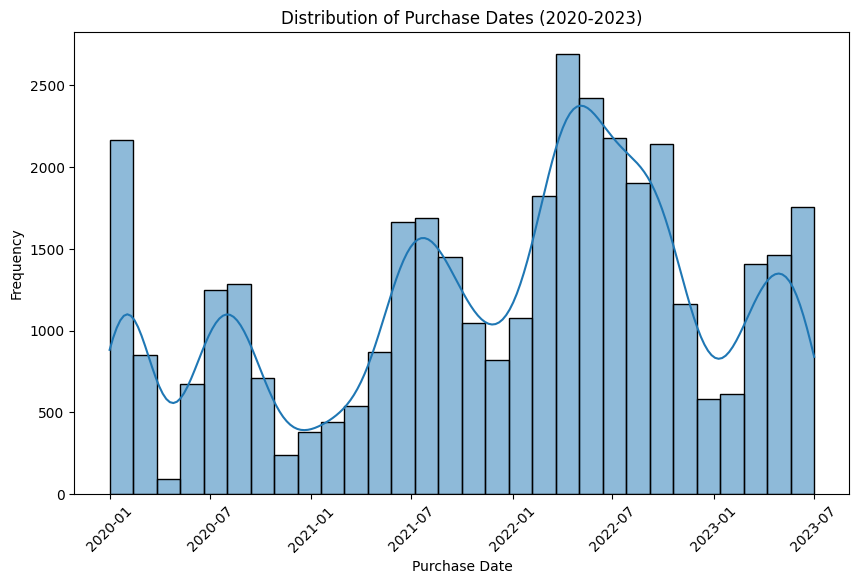

In [23]:
start_date = '2020-01-01'
end_date = '2023-12-31'
filtered_df = hb_dataset[(hb_dataset['PurchaseDate'] >= start_date) & (hb_dataset['PurchaseDate'] <= end_date)]

# Plot the distribution of purchase dates using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['PurchaseDate'], kde=True, bins=30)
plt.xlabel('Purchase Date')
plt.ylabel('Frequency')
plt.title('Distribution of Purchase Dates (2020-2023)')
plt.xticks(rotation=45)
plt.show()

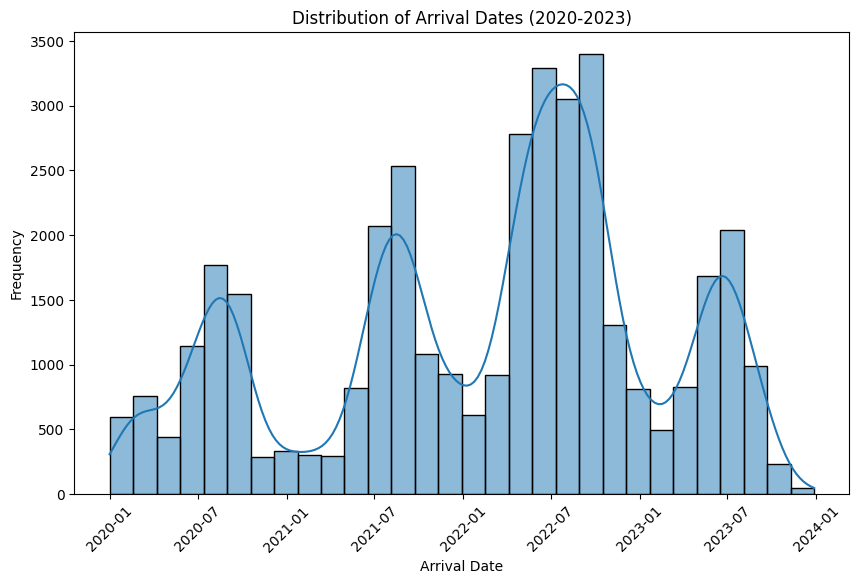

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['Arrival'], kde=True, bins=30)
plt.xlabel('Arrival Date')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Dates (2020-2023)')
plt.xticks(rotation=45)
plt.show()

Make sense. Most booking are at the beginning of the year and just before summer. Italians tends to go in vacation on August so in July the book. Our goal is to see if there is seasonality or it is [cyclic pattern](https://robjhyndman.com/hyndsight/cyclicts). Each year show us the same behaviour in terms of booking.

  Distribution  KS Statistic  P-Value
0         norm      0.106293      0.0
1        expon      0.277902      0.0
2        gamma      0.113996      0.0
3      lognorm      0.106295      0.0
4         beta      0.137298      0.0


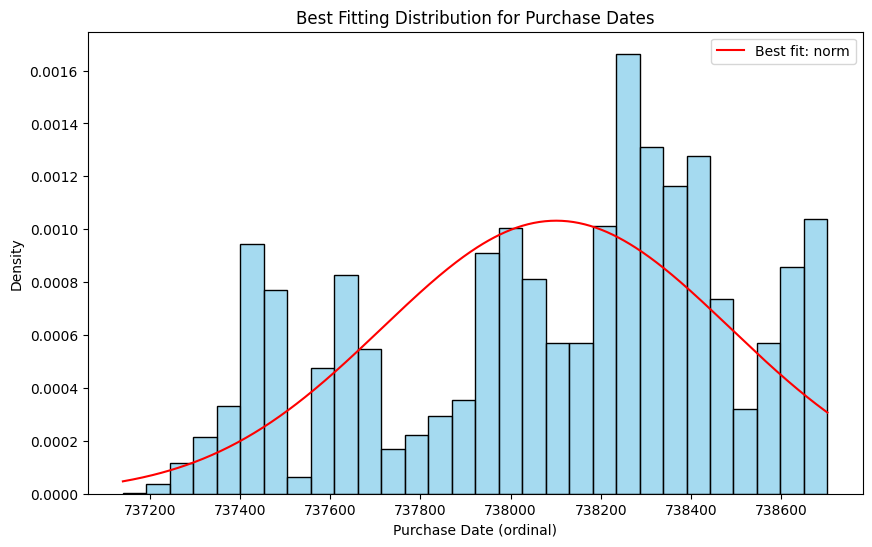

In [25]:

purchase_dates = hb_dataset['PurchaseDate'].apply(lambda x: x.toordinal())

distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(purchase_dates)
    ks_stat, p_value = stats.kstest(purchase_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(purchase_dates)

plt.figure(figsize=(10, 6))
sns.histplot(purchase_dates, kde=False, bins=30, color='skyblue', stat='density')

x = np.linspace(min(purchase_dates), max(purchase_dates), 500)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Purchase Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Purchase Dates')
plt.legend()
plt.show()


Some other studies have been found that a normal distribution model quite well also hotel arrival: https://www.sciencedirect.com/science/article/abs/pii/S0261517717302431.


  Distribution  KS Statistic  P-Value
0         norm      0.118242      0.0
1        expon      0.253936      0.0
2        gamma      0.126179      0.0
3      lognorm      0.118242      0.0
4         beta      0.109427      0.0


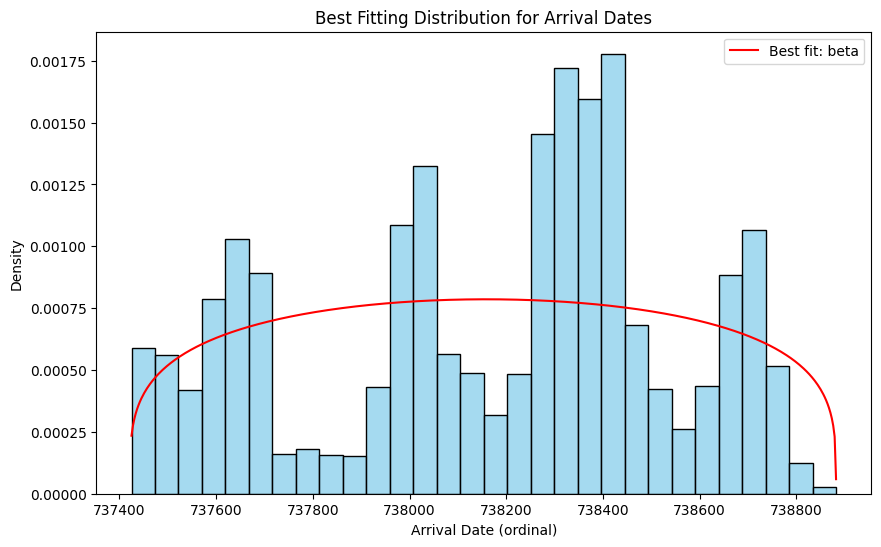

In [26]:
arrival_dates = hb_dataset['Arrival'].apply(lambda x: x.toordinal())

distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(arrival_dates)
    ks_stat, p_value = stats.kstest(arrival_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(arrival_dates)

plt.figure(figsize=(10, 6))
sns.histplot(arrival_dates, kde=False, bins=30, color='skyblue', stat='density')

x = np.linspace(min(arrival_dates), max(arrival_dates), 500)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Arrival Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Arrival Dates')
plt.legend()
plt.show()

## Which between our customers had most revenue?

In [27]:

revenue_per_hotel = hb_dataset.groupby(['HotelId', 'City'])['Total'].sum().reset_index()
revenue_per_hotel.sort_values(['Total'], inplace=True, ascending=False)
revenue_per_hotel.head()


HotelId      City       Total
7     008     Olbia  6398486.80
5     006  Brindisi  2418291.75
3     004  Florence  1808414.24
6     007    Latina  1606252.54
4     005    Naples  1545058.55

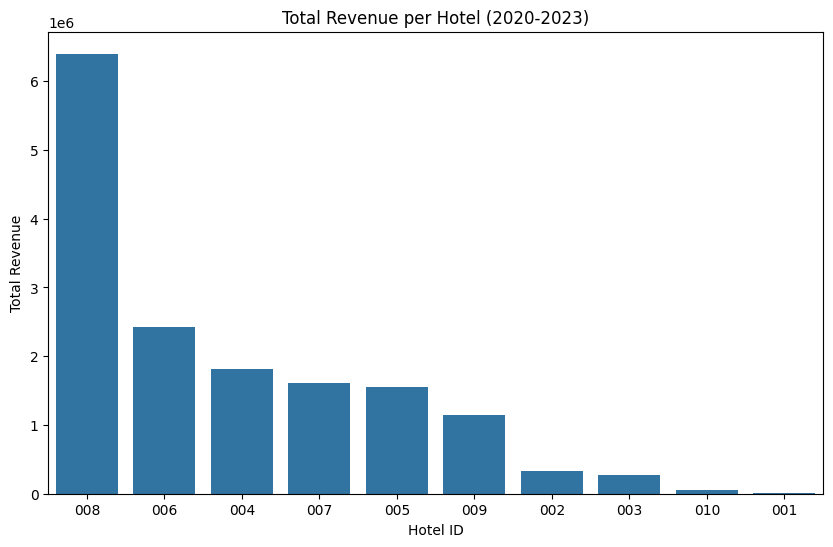

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='HotelId', y='Total', data=revenue_per_hotel)
plt.xlabel('Hotel ID')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Hotel (2020-2023)')
plt.show()

Now we want to see in the dataset the correlation between data, but for doing this and reaching the correlation matrix we need to reduce the
features, distiguish between categorical and numerical and doing one shot encoding, removing redundant features. We will take, our best customer as sample to develop the metodology that can be applied to the others. So Hotel008 is the most interesting client, we took as example to study our demand and generalize the algorithm to other customers.

In [29]:

# Identify numerical and categorical columns
numerical_cols = hb_dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = hb_dataset.select_dtypes(include=['object']).columns
# Drop unnecessary columns
corr_df = hb_dataset.drop(columns=['Code', 'Arrival', 'Departure', 'PurchaseDate', 'LastModified'])
# One-hot encoding of categorical columns using pd.get_dummies
df_encoded = pd.get_dummies(corr_df, drop_first=True)
# Compute the correlation matrix
correlation_matrix = df_encoded.corr()
# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

/tmp/ipykernel_519538/528204745.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_encoded.corr()


Correlation Matrix:
                       Status    Nights     Total  Arrival_Timestamp  \
Status               1.000000  0.645211  0.513571           0.178381   
Nights               0.645211  1.000000  0.794623           0.156894   
Total                0.513571  0.794623  1.000000           0.198652   
Arrival_Timestamp    0.178381  0.156894  0.198652           1.000000   
Departure_Timestamp  0.177377  0.159126  0.200500           0.999982   
...                       ...       ...       ...                ...   
City_Olbia           0.053674 -0.019742  0.183897          -0.007913   
City_Rome            0.012441  0.031340  0.039968          -0.018450   
Season_Spring       -0.052579 -0.072694 -0.078285          -0.003985   
Season_Summer        0.038156  0.090853  0.060638           0.050297   
Season_Winter       -0.061001 -0.022598 -0.021612          -0.154265   

                     Departure_Timestamp  Purchase_Timestamp  \
Status                          0.177377           

As expected some things are evident:
- Purchase Date and Arrival Date are correlated.
Less evident is the behaviour for Season and the cities:
- Expected behaviour that Olbia is overcrowded in Summer, since it is in Sardinia.
For our purpose, compute demandscore is enough since we select just Arrival and treat the dataset like a time series.
Now we will focus in model selection based on Arrival since our goal is to compute the demand score per hotel.
There selected two:
    - Prophet.
    - SARIMAX.

The approach that we will use it to select define a process to treat any series and see which are the metrics (RMSE,MAPE). The model
that has better metrics wins for that given Hotel dataset.

In [30]:
hb_dataset.head()

Code  Status BookingChannel    Arrival  Departure  \
60820  2493115910/4283897556     1.0    Booking.com 2023-12-28 2024-01-04   
60923  2745673363/4308678121     1.0    Booking.com 2023-12-27 2024-01-03   
61034  3958853713/4337114239     1.0    Booking.com 2023-12-26 2024-01-02   
60873  3854867487/4296773334     1.0    Booking.com 2023-12-26 2024-01-02   
60750  2359160563/4271754038     1.0    Booking.com 2023-12-23 2023-12-31   

       Nights    Total PurchaseDate        LastModified HotelId  \
60820       7  4637.25   2023-06-04 2023-06-04 09:27:30     006   
60923       7  3892.05   2023-06-17 2023-06-17 18:09:53     006   
61034       7  2766.15   2023-07-02 2023-07-02 16:35:28     006   
60873       7  2620.35   2023-06-11 2023-06-11 10:53:57     006   
60750       8  2997.00   2023-05-28 2023-05-28 13:16:41     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
60820  1703721600000000000  1704326400000000000    2023-06-04 09:27:30   
60923  1703635200000000000  1704240000000000000    2023-06-17 18:09:53   
61034  1703548800000000000  1704153600000000000    2023-07-02 16:35:28   
60873  1703548800000000000  1704153600000000000    2023-06-11 10:53:57   
60750  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   

        Purchase_Timestamp      City  Season  
60820  1685836800000000000  Brindisi  Winter  
60923  1686960000000000000  Brindisi  Winter  
61034  1688256000000000000  Brindisi  Winter  
60873  1686441600000000000  Brindisi  Winter  
60750  1685232000000000000  Brindisi  Winter

## Exploratory Data Analysis - Time Forecasting Problem.

In [31]:
demand = hb_dataset.groupby(['HotelId','Arrival']).size().reset_index(name='BookingCount')
demand.head()

HotelId    Arrival  BookingCount
0     001 2020-05-23             1
1     001 2020-05-24             1
2     001 2020-05-29             1
3     001 2020-06-13             3
4     001 2020-07-18             1

### Plotting the Reserveration Distribution for each Hotel.

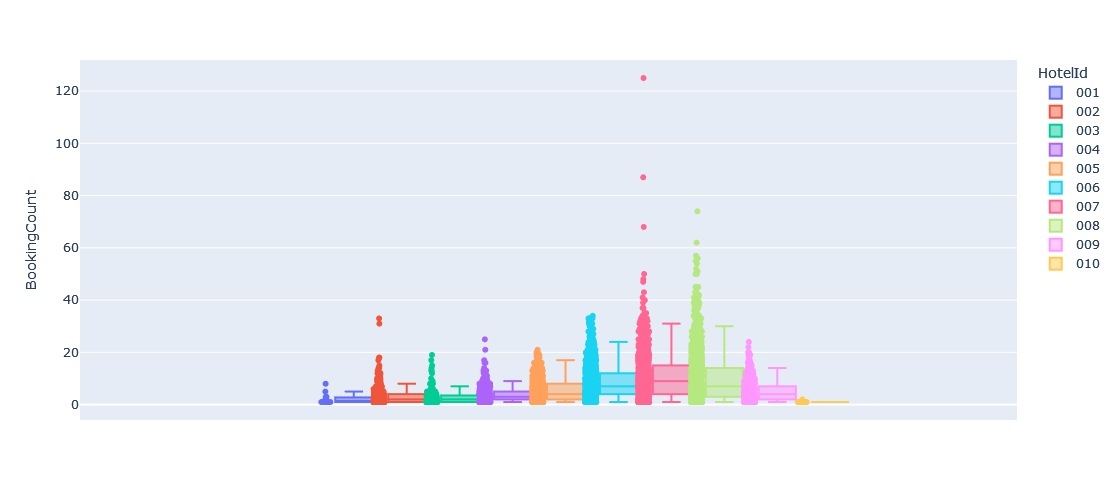

In [32]:

import plotly.express as px
fig = px.box(demand, y="BookingCount", color='HotelId', points='all',  width=1000, height=500)
fig.show()


 To interpret boxplots we use the article at [Towards Data Science](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd5).
So using that model, there are hotel that have values that are candidate outliers in the time series distribution. Let's try to isolate the box plot and the booking per week per hotel.

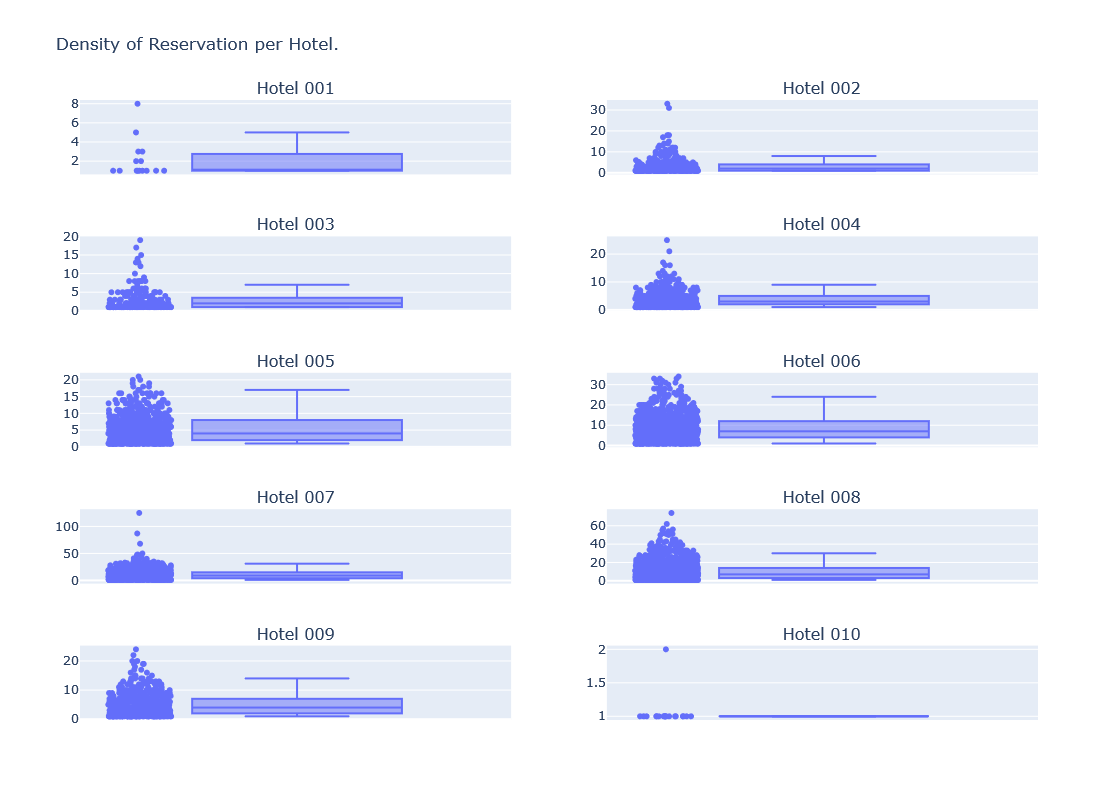

In [33]:

import plotly.express as px
from plotly.subplots import make_subplots

hotel_ids = demand['HotelId'].unique()
rows = (len(hotel_ids) + 1) // 2
fig = make_subplots(rows=rows, cols=2, subplot_titles=[f'Hotel {hotel_id}' for hotel_id in hotel_ids])
for idx, hotel_id in enumerate(hotel_ids):
    hotel_data = demand[demand['HotelId'] == hotel_id]
    box_plot = px.box(hotel_data, y="BookingCount", points='all')
    for trace in box_plot['data']:
        fig.add_trace(trace, row=(idx // 2) + 1, col=(idx % 2) + 1)
fig.update_layout(height=800, width=1000, showlegend=False, title_text="Density of Reservation per Hotel.")
fig.show()


The comprensive set of boxplot indicates that in each Hotel there weeks that we've exceptional demand i.e. in Summer for each Hotel or it can be anomalies
to be detected. We use an algorithm that comes a well known Italian university but at the moment let's understand seasonal decomposition. We have pick up HotelId 008 because it is our most important customer in term or revenue and it is also the one that has more anomalies. This methodology will in production extended to all our customers hotels. Prophet has internally a mechanism for outliners so this part is important mainly for SARIMAX.

In [34]:
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller

demand_ds = demand[demand['HotelId'] == '008']
# we do a backup before proceeing
demand_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 3726 to 4789
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   HotelId       1064 non-null   object        
 1   Arrival       1064 non-null   datetime64[ns]
 2   BookingCount  1064 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 33.2+ KB


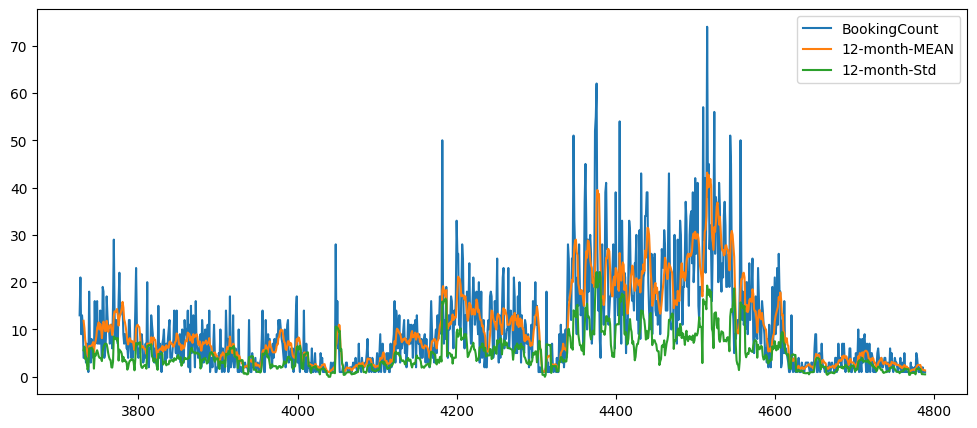

In [35]:
df = demand_ds.copy()
df['12-month-MEAN'] = df['BookingCount'].rolling(window=6).mean()
df['12-month-Std'] = df['BookingCount'].rolling(window=6).std()
df[['BookingCount','12-month-MEAN','12-month-Std']].plot(figsize=(12,5));


The series is not the easiest to analyze, this good because we can generalize them to others. The variance is high, it might be a hint
about the lack of stationarity.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

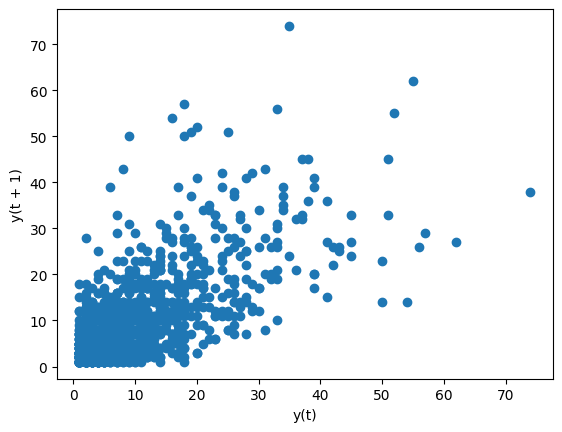

In [36]:
lag_plot(demand_ds['BookingCount'])

In time series the lag plot gives us an indication on how the series behave and if there are increasing and decreasing pattern. In thi case we notice a core. Data is not spreadly random in this case. There is randomicity at some level.

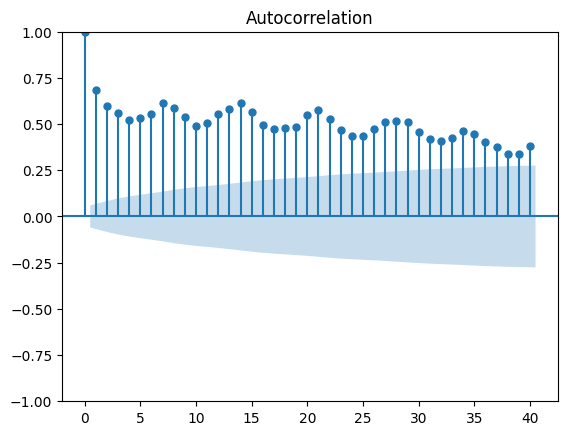

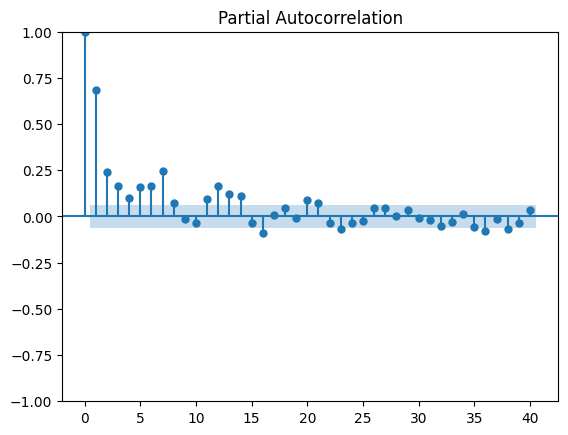

In [37]:
acf_plot = plot_acf(demand_ds['BookingCount'], lags=40)
pacf_plot = plot_pacf(demand_ds['BookingCount'], lags=40)


Interesting to note randomicity. Looks like the series is non stationary.

## Seasonal Decomposition.
Seasonal decompositon will fundamental for our algorithm. In this [decomposition](https://math.unm.edu/~lil/Stat581/6-decomposition.pdf) a time series is split on three parts:
1. Trend: Long term pattern present in the series both increase or decrease.
2. Seasonal: Repeating cyclic pattern in the series where the cycle is specified in weeks, months, years.
3. Residual: Basically noise. It is the remaining part of the data after removing the trend and seasonal components.

We want to understand whether each time series is additive or multiplicative. To do this, we can use seasonal_decompose, which provides us with three separate components: trend, seasonality, and residual. If the seasonality component changes proportionally with the trend, we classify the time series as multiplicative. Otherwise, if the seasonality remains constant regardless of the trend, it is considered additive. Let me explai better:

In our context, a hotel that experiences a fixed summer peak of 20 additional rooms fits an additive model. On the other hand, a hotel that sees a 20% increase in bookings every summer would better fit a multiplicative time series. In the case of Hotel08 is multiplicative decomposition.
                                      -

In [38]:
import plotly.graph_objs as go
import statsmodels.api as sm
hotel_data = demand[demand['HotelId'] == '008']


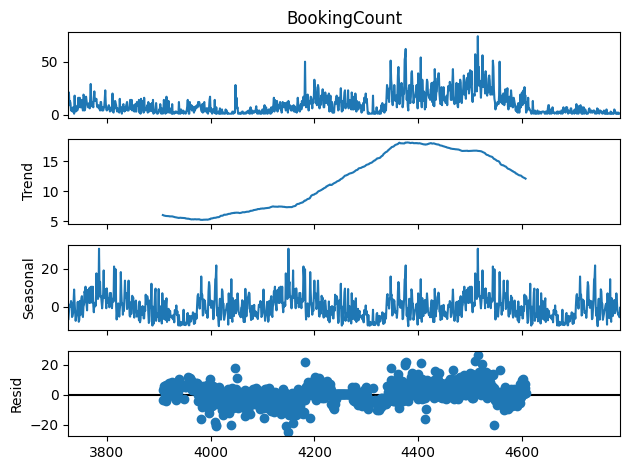

In [39]:
res = sm.tsa.seasonal_decompose(hotel_data['BookingCount'],
                                period=365,
                                model='additive')
resplot = res.plot()

The trend if very clear and also the seasonality of the series. Let's look how the residual behaves. The residual is the difference between trend and seasonality and express noise. 

In [40]:
res.resid[np.isfinite(res.resid) == False] = 0

In [41]:
res_resid = sm.tsa.seasonal_decompose(res.resid.interpolate(),
                                period=52,
                                model='additive')

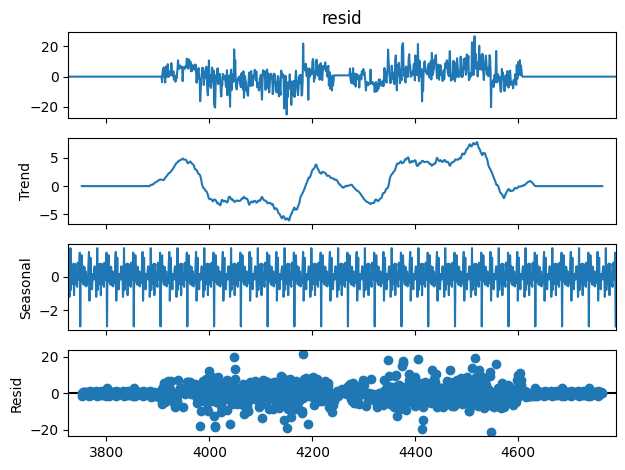

In [42]:
resplot = res_resid.plot()

In [43]:
import rich

def is_a_stationary_series(time_series):
    result = adfuller(time_series.values)
    stats = result[0]
    p_value = result[1]
    print(f'ADF Statistic: {stats}')
    print(f'p-value: {p_value}')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    # suggested by: https://machinelearningmastery.com/time-series-data-stationary-python/
    if (p_value <= 0.05) and (result[4]['5%'] > result[0]):
        rich.print("[green]Stationary[/green]")
    else:
        rich.print("[red]Non-stationary[/red]")


In [44]:
is_a_stationary_series(demand_ds['BookingCount'])

ADF Statistic: -1.9388450539421307
p-value: 0.31401350188105326
	1%: -3.437
	5%: -2.864
	10%: -2.568


Non-stationary

The series is non stationary. In this case we need to make differencies and we use skforecast package, this is relevant for ARIMA model family, if SARIMAX handle some in some cases stationarity we prefer doing differencing and work with a stationary series. We keep 
a backup series, called backup_demand_ds directly to be able to handle with Prophet. Prophet doesn't require stationarity.

In [45]:
from skforecast.preprocessing import TimeSeriesDifferentiator
y = np.array(demand_ds['BookingCount'], dtype=int)
diff_computer = TimeSeriesDifferentiator(order=1)
diff_computer.fit(y)
y_diff = diff_computer.transform(y)
original_size = len(demand_ds['BookingCount'])
diff_size = y_diff.shape[0]
backup_demand_ds = None
print(f"Original Series: {original_size} differentiate size: {diff_size}")
if is_a_stationary_series(demand_ds['BookingCount']):
    rich.print("[green]Series is stationary[/green]")
else:
    rich.print("[blue]Series converted[/blue]")
    series = pd.Series(y_diff, name="BookingCount")
    stationary_ds =demand_ds.copy()
    stationary_ds.reset_index(drop=True, inplace=True)
    stationary_ds['BookingCount'] = series
    stationary_ds.dropna(inplace=True)
    backup_demand_ds = demand_ds.copy()
    demand_ds = stationary_ds.copy()
    is_a_stationary_series(demand_ds['BookingCount'])


Original Series: 1064 differentiate size: 1064
ADF Statistic: -1.9388450539421307
p-value: 0.31401350188105326
	1%: -3.437
	5%: -2.864
	10%: -2.568


Non-stationary

Series converted

ADF Statistic: -9.289919976642981
p-value: 1.1873813159601237e-15
	1%: -3.437
	5%: -2.864
	10%: -2.568


Stationary

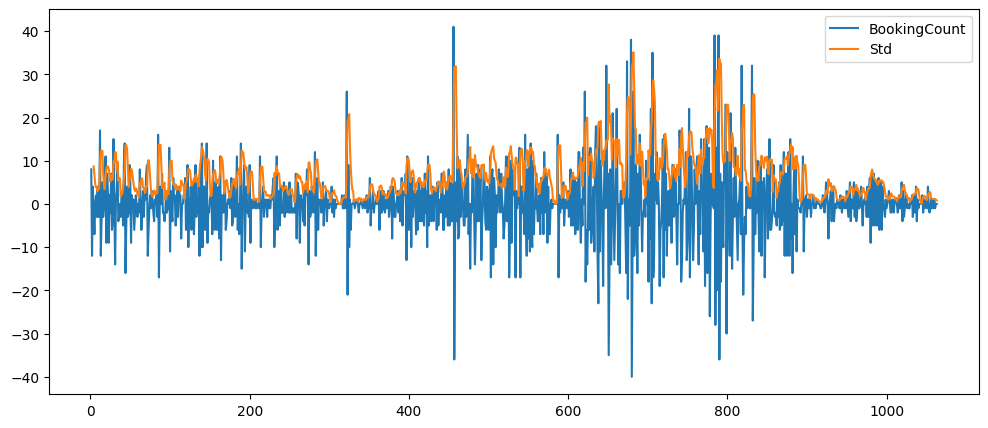

In [46]:
df = demand_ds.copy()
df['Std'] = df['BookingCount'].rolling(window=4).std()
df[['BookingCount','Std']].plot(figsize=(12,5));

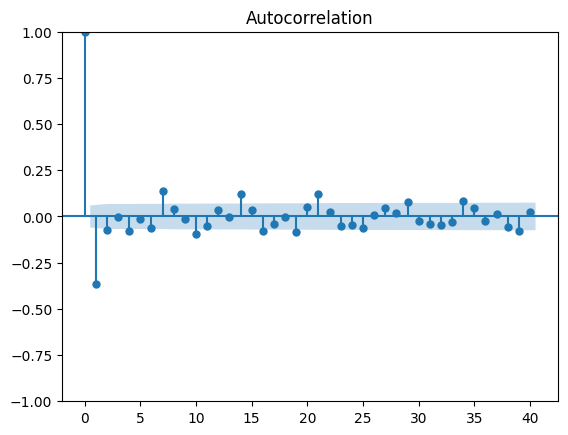

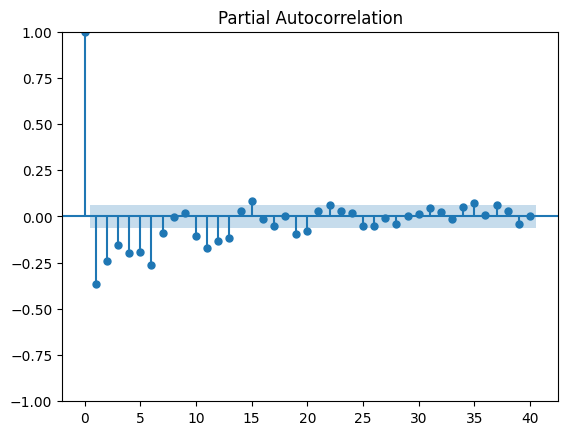

In [47]:
acf_plot = plot_acf(demand_ds['BookingCount'], lags=40)
pacf_plot = plot_pacf(demand_ds['BookingCount'], lags=40)


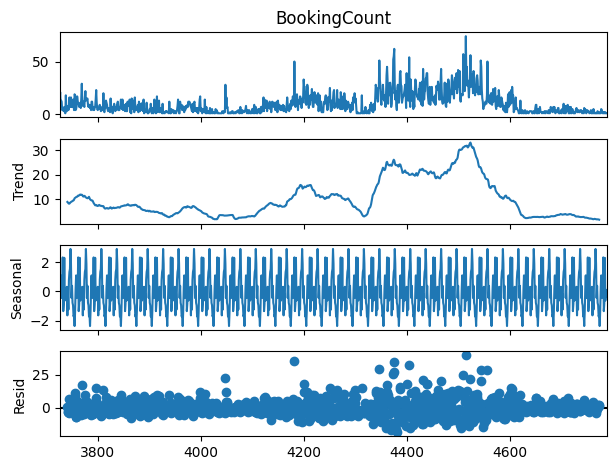

In [48]:
res = sm.tsa.seasonal_decompose(hotel_data['BookingCount'],
                                period=30,
                                model='additive')
resplot = res.plot()

## Anomaly detection.
An anomaly in a time series refers to a data point or sequence of data points that significantly deviates from the expected patterns or trends typically observed in the data. These anomalies can manifest in various ways, such as abrupt changes in values, missing data segments, or other irregular patterns that deviate from normal fluctuations. As discussed in [Anomaly Detection in Time Series: A Comprehensive Evaluation](https://www.vldb.org/pvldb/vol15/p1779-wenig.pdf), such anomalies can indicate significant events or issues within the system being analyzed. In our specific context, an anomaly might suggest that during certain periods, the demand exceeded the hotel's operational capacity or it is too low that we don't need much staff.
Numerous techniques for anomaly detection have been evaluated in the literature. During our research, we identified an effective algorithm that can be applied to the residual component of a seasonal-trend decomposition, utilizing the Isolation Forest method. This approach is both efficient and fast. We propose this algorithm for anomaly detection at each hotel level, as inspired by the work on [Unsupervised Anomaly Detection on Server Metrics](https://webthesis.biblio.polito.it/21240/1/tesi.pdf).

#### Anomaly detection with Isolation Forest
The steps of the algorithm are:
1. Normalization of the time series
2. Seasonal trend decomposition of the time series to extract the residual.
3. Applying ISOLATION FOREST to the residual
4. Remove points not considered anomalous by the Isolation Forest
5. Apply DBSCAN to the points outside the confidence region to obtain clusters of points close to each other
6. Points that do not belong to any cluster are the anomalies

[Isolation Forest](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8888179) algorithm directly seeks anomalous points based on the contamination parameter. First, the algorithm builds a forest of random decision trees. After training, it assigns an anomaly score to each data point. At this stage, we don't know whether a point is an inlier or outlier. The contamination parameter serves as a threshold, determining how many points are classified as outliers by converting these raw scores into inlier or outlier labels.

In [49]:
!pip install matplot statsmodels numpy

### 1. Normalization of time series
We will now proceed with analyzing the time series data from Hotel 008, as this dataset appears interesting. Specifically, the boxplot has revealed some outlier points exceeding the maximum threshold. At the conclusion of this analysis, we will write a function that can be applied to each hotel. We want to scale the data as to detect outliers we will use isolation forest, that require data scaling.

In [50]:
from sklearn.preprocessing import MinMaxScaler
# random forest requirement
# normalization scales each value of booking count to range 0.1
min_max_scaler = MinMaxScaler(feature_range=(0,1))
booking_count = hotel_data[['BookingCount']]
booking_count_scaled = min_max_scaler.fit_transform(booking_count)
hotel_data['BookingCount_Scaled'] = booking_count_scaled
booking_hotel_scaled = hotel_data.drop(columns=['HotelId'])

### 2. Seasonal-Trend decomposition using LOESS

Time series data can have a well known set of pattern.
Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category.
- Trend: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes has ups and downs.
-  A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency.
- Cyclic cycle occurs when the data exhibit rises and falls that are not of a fixed frequency.

Statsmodels offers a seasonal decomposition tool that allows us to break down the different components of a time series, enabling a clear and visual understanding of how each component contributes to the overall behavior of the data.

In [51]:
booking_hotel_scaled.head()

Arrival  BookingCount  BookingCount_Scaled
3726 2020-01-01            13             0.164384
3727 2020-01-02            21             0.273973
3728 2020-01-03             9             0.109589
3729 2020-01-04            13             0.164384
3730 2020-01-05            11             0.136986

<Axes: >

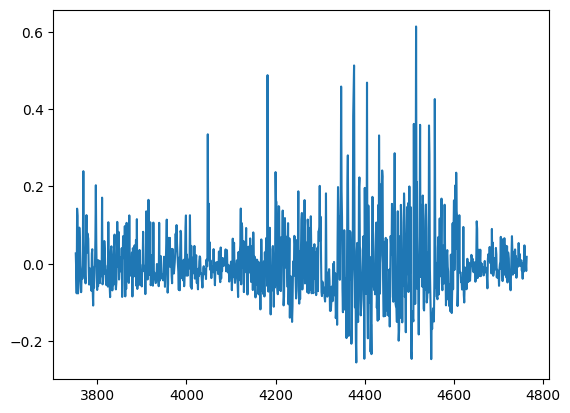

In [52]:
season_decomposed = sm.tsa.seasonal_decompose(booking_hotel_scaled['BookingCount_Scaled'].interpolate(),period=52)
residual = season_decomposed.resid
residual.plot()

### 3. Apply Isolation Forest on Residual

### Replacement of null values with the mean.

In [53]:
data = residual.fillna(residual.mean())
data.head()

3726    0.000299
3727    0.000299
3728    0.000299
3729    0.000299
3730    0.000299
Name: resid, dtype: float64

### Isolation Forest Prediction

In [54]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest()
values = clf.fit_predict(data.values.reshape(-1, 1))
booking_hotel_scaled['anomaly_score'] = values
booking_hotel_scaled['is_anomaly'] = booking_hotel_scaled['anomaly_score'] == -1

In [55]:
booking_hotel_scaled.head()

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly
3726 2020-01-01            13             0.164384              1       False
3727 2020-01-02            21             0.273973              1       False
3728 2020-01-03             9             0.109589              1       False
3729 2020-01-04            13             0.164384              1       False
3730 2020-01-05            11             0.136986              1       False

### 4. Remove the points that are not consided anomalies by IsolationForest.

In [56]:
hotel_anomalies = booking_hotel_scaled[booking_hotel_scaled['anomaly_score']==-1]
hotel_anomalies.head(46)

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly
3755 2020-01-30            19             0.246575             -1        True
3756 2020-01-31            18             0.232877             -1        True
3760 2020-02-04            17             0.219178             -1        True
3769 2020-02-14            29             0.383562             -1        True
3776 2020-02-21            22             0.287671             -1        True
3791 2020-03-07             4             0.041096             -1        True
3797 2020-03-13            23             0.301370             -1        True
3811 2020-03-27            20             0.260274             -1        True
3825 2020-04-10            15             0.191781             -1        True
3845 2020-04-30            14             0.178082             -1        True
3862 2020-05-17            14             0.178082             -1        True
3866 2020-05-21            15             0.191781             -1        True
3872 2020-05-27            16             0.205479             -1        True
3889 2020-06-13            14             0.178082             -1        True
3910 2020-07-04            14             0.178082             -1        True
3915 2020-07-10            17             0.219178             -1        True
3919 2020-07-14            13             0.164384             -1        True
3926 2020-07-22            10             0.123288             -1        True
3939 2020-08-06            12             0.150685             -1        True
3956 2020-08-29            14             0.178082             -1        True
3978 2020-09-23            12             0.150685             -1        True
3998 2020-10-13            14             0.178082             -1        True
3999 2020-10-14            17             0.219178             -1        True
4008 2020-10-24            14             0.178082             -1        True
4048 2021-04-05            28             0.369863             -1        True
4050 2021-04-07            16             0.205479             -1        True
4122 2021-07-03            16             0.205479             -1        True
4124 2021-07-05            14             0.178082             -1        True
4125 2021-07-06            12             0.150685             -1        True
4134 2021-07-15            12             0.150685             -1        True
4166 2021-08-17             2             0.013699             -1        True
4182 2021-09-04            50             0.671233             -1        True
4187 2021-09-09            19             0.246575             -1        True
4189 2021-09-11             4             0.041096             -1        True
4196 2021-09-18             6             0.068493             -1        True
4200 2021-09-22            33             0.438356             -1        True
4201 2021-09-23            26             0.342466             -1        True
4202 2021-09-24            26             0.342466             -1        True
4207 2021-09-29            28             0.369863             -1        True
4208 2021-09-30            25             0.328767             -1        True
4216 2021-10-08            24             0.315068             -1        True
4218 2021-10-10             7             0.082192             -1        True
4221 2021-10-13            21             0.273973             -1        True
4228 2021-10-20            20             0.260274             -1        True
4229 2021-10-21             3             0.027397             -1        True
4232 2021-10-24             4             0.041096             -1        True

In [57]:
print(f'Anomalies count {hotel_anomalies.shape[0]} over {booking_hotel_scaled.shape[0]}')

Anomalies count 212 over 1064


### 5. Apply DBScan on the Isolation Forest Anomalies.
The points that don't belong to any cluster are anomalies and we can pass from 46 to much less. The eps is placed to 0.1. [DBScan](https://dl.acm.org/doi/10.1145/3068335) has num points and eps as hyperparameter. A better way to select the value of eps is described in [Fast Density-Based Clustering with R](https://www.jstatsoft.org/article/view/v091i01). The paper proposes using KNN to estimate the distance from each point to its nearest neighbor within the same partition, followed by sorting and selecting the minimum. However, we opted to use an empirical value derived from direct data exploration.

In [58]:
hotel_anomalies['Arrival_float'] = hotel_anomalies['Arrival'].apply(lambda x: x.timestamp())
hotel_anomalies.head()

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly  \
3755 2020-01-30            19             0.246575             -1        True   
3756 2020-01-31            18             0.232877             -1        True   
3760 2020-02-04            17             0.219178             -1        True   
3769 2020-02-14            29             0.383562             -1        True   
3776 2020-02-21            22             0.287671             -1        True   

      Arrival_float  
3755   1.580342e+09  
3756   1.580429e+09  
3760   1.580774e+09  
3769   1.581638e+09  
3776   1.582243e+09

In [59]:
from sklearn.cluster import DBSCAN
X = hotel_anomalies[['BookingCount_Scaled']].values
# min_samples defines the minimum number of data points required to form a distinct cluster
dbscan = DBSCAN(eps=0.2, min_samples=20)
dbscan.fit(X)
hotel_anomalies['Cluster'] = dbscan.labels_
outliers = hotel_anomalies[hotel_anomalies['Cluster'] == -1]
outliers.count()

Arrival                1
BookingCount           1
BookingCount_Scaled    1
anomaly_score          1
is_anomaly             1
Arrival_float          1
Cluster                1
dtype: int64

#### Remaining anomalies

In [60]:
outliers.head()

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly  \
4515 2022-09-29            74                  1.0             -1        True   

      Arrival_float  Cluster  
4515   1.664410e+09       -1

Now we can act in two ways in case of forecasting:
- remove the outliers in case of error since
- evalutating when happens and if they are legit (high season, events, christmas) keep them.

We can remove safely the outliners except for the week of Christmas and First week of the year We can establish, having seen the data distribution that **peak are not anomalies** in holiday periods.
Now we need to generalize for each hotel. We're gonna define a function **clean_time_series** in Python that include all the code we've see to clean up from outliers and a **restrict_outliers** that take in account the vacation times.

In [61]:
!pip install holidays

In [62]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from datetime import datetime
import holidays
def restrict_outliers(outliers: pd.DataFrame, country: str = 'IT') -> pd.DataFrame:
    collect_idx_to_remove = []
    for idx,value in outliers.iterrows():
        date = value[1].to_pydatetime()
        h = holidays.country_holidays('') 
        # we exclude december, august, and january till 6
        str_date = date.strftime("%Y-%m-%d")
        if str_date in h:
            collect_idx_to_remove.append(idx)
    return outliers

# we can apply this function to each hotel to clean data
def clean_time_series(hd: pd.DataFrame) -> pd.DataFrame:
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    booking_count = hd[['BookingCount']]
    booking_count_scaled = min_max_scaler.fit_transform(booking_count)
    hd['BookingCount_Scaled'] = booking_count_scaled
    season_decomposed = sm.tsa.seasonal_decompose(hd['BookingCount_Scaled'].interpolate(),period=52)
    residual = season_decomposed.resid
    data = residual.fillna(residual.mean())
    clf = IsolationForest()
    values = clf.fit_predict(data.values.reshape(-1, 1))
    hd['anomaly_score'] = values
    hotel_anomalies = hd[hd['anomaly_score']==-1]
    X = hotel_anomalies[['BookingCount_Scaled']].values
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    dbscan.fit(X)
    hotel_anomalies['Cluster'] = dbscan.labels_
    outliers = restrict_outliers(hotel_anomalies[hotel_anomalies['Cluster'] == -1])
    hd = hd.drop(outliers.index.to_list())
    return hd

This is the while flow, coded in the clean_time_series function.

## Model Selection for Demand Score
Now we clean our scaled data to validate which model is better and then we start with model selection. We have to investigate between Facebook [Prophet](https://peerj.com/preprints/3190.pdf) and SARIMAX. We'vd two data frames:
- demand_ds, stationary series with removal of outliers needed for SARIMAX
- backup_demand_ds, non stationary series needed for Prophet.


In [63]:
demand_ds = clean_time_series(demand_ds)

In [64]:
is_a_stationary_series(demand_ds['BookingCount'])

ADF Statistic: -9.289919976642981
p-value: 1.1873813159601237e-15
	1%: -3.437
	5%: -2.864
	10%: -2.568


Stationary

In [65]:
print(f'Series size after cleaning {demand_ds.shape[0]} and before {demand_ds.shape[0]}')

Series size after cleaning 1063 and before 1063


In [66]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")
demand_ds.head()

HotelId    Arrival  BookingCount  BookingCount_Scaled  anomaly_score
1     008 2020-01-02           8.0             0.592593              1
2     008 2020-01-03         -12.0             0.345679              1
3     008 2020-01-04           4.0             0.543210              1
4     008 2020-01-05          -2.0             0.469136              1
5     008 2020-01-06          -7.0             0.407407              1

Statsmodels offers a seasonal decomposition tool that allows us to break down the different components of a time series, enabling a clear and visual understanding of how each component contributes to the overall behavior of the data.

An additive model is applied when the trend appears linear, and the seasonal and trend components remain relatively constant over time (e.g., each year, we add 10,000 passengers). In contrast, a multiplicative model is more suitable when the data shows a non-linear growth or decline (e.g., doubling the number of passengers each year). In our case as stated previously we use a multiplicative model.

In [67]:
demand_ds.count()

HotelId                1063
Arrival                1063
BookingCount           1063
BookingCount_Scaled    1063
anomaly_score          1063
dtype: int64

In [68]:
demand_ds.drop(columns=['BookingCount_Scaled','anomaly_score','HotelId'], inplace=True, axis=1)

In [69]:
demand_ds.head()


Arrival  BookingCount
1 2020-01-02           8.0
2 2020-01-03         -12.0
3 2020-01-04           4.0
4 2020-01-05          -2.0
5 2020-01-06          -7.0

## Model 1: Prophet
### Baseline Model

[Prophet](https://facebook.github.io/prophet/) is forecasting algorithm designed at Facebook based on an [addittive regression] (https://www.sciencedirect.com/topics/computer-science/additive-regression) model that has  imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column). So, we must rename the columns in our dataframe. Prophet doesn't require a differentiated series even if the series is not stationary. So we use our backup dataset.


We use our **backup_demand_ds** DataFrame which has not passed through the differencing process and outliers threatment.

In [70]:
prophet_ds = backup_demand_ds.rename(columns={'Arrival': 'ds','BookingCount': 'y'})
prophet_ds.drop(labels=['HotelId'], inplace=True, axis=1)
prophet_ds.reset_index()
prophet_ds.head()

ds   y
3726 2020-01-01  13
3727 2020-01-02  21
3728 2020-01-03   9
3729 2020-01-04  13
3730 2020-01-05  11

Now we split the dataset in 75% training, 25% testing. Looking the date to split, all dates after the pivot date called *times* are test data.

In [71]:
last_training_date_index = int((prophet_ds['ds'].count()) * 0.75)
times = prophet_ds.iloc[last_training_date_index]['ds'].to_pydatetime()
df_data_train = prophet_ds[prophet_ds["ds"] < times]
df_data_test = prophet_ds[prophet_ds["ds"] >= times]

In [72]:
df_data_train.head()

ds   y
3726 2020-01-01  13
3727 2020-01-02  21
3728 2020-01-03   9
3729 2020-01-04  13
3730 2020-01-05  11

In [73]:
df_data_test.head()

ds   y
4524 2022-10-08  56
4525 2022-10-09  26
4526 2022-10-10  38
4527 2022-10-11  36
4528 2022-10-12  32

Now it is interesting plotting the series and its variance to understand his behaviour. We expect a lot variance.

Text(0, 0.5, 'Room Booking for Hotel 008')

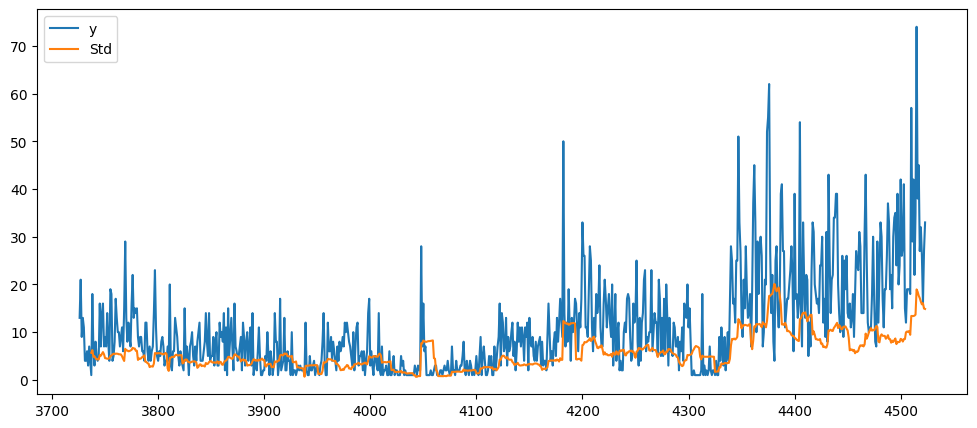

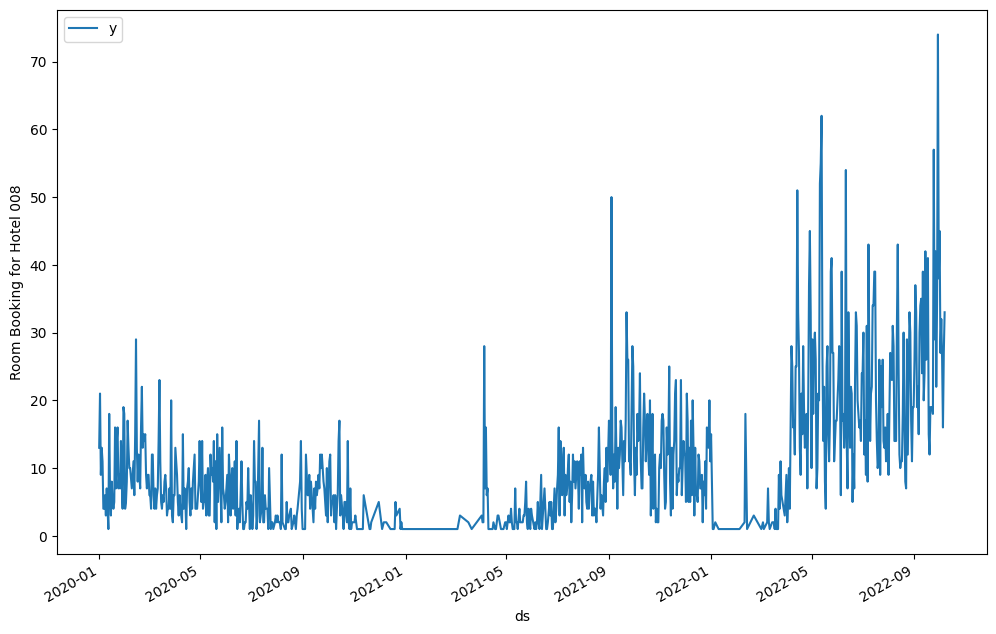

In [74]:
df = df_data_train.copy()
df.reset_index()
df['Std'] = df['y'].rolling(window=12).std()
df[['y','Std']].plot(figsize=(12,5));
ax = df_data_train.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Room Booking for Hotel 008')

There are days with limited number of arrivale and days where the Hotel is full, this behaviour depends on day, season and year. Looks like the hotel has been closed for a period, more or less 5 months. It is evident an yearly_seasonality, we see from the from January to May the hotel is quite close. So we can add the dates to holidays.We are in the need to compute them. The arrival variance is quite high.

In [75]:
import holidays
from datetime import timedelta
# in 2021 was closed.
hotel_holidays = []
year=2021
start_date = datetime(year, 1, 1)  
end_date = datetime(year, 5, 10)
period = int((end_date - start_date).days) + 1
custom_period = [(start_date + timedelta(days=d)).strftime('%Y-%m-%d') for d in range(period)]
hotel_holidays.extend(custom_period)

hotel_closure = pd.DataFrame({
    'holiday': 'hotel_closed',
    'ds': pd.to_datetime(hotel_holidays),
    'lower_window': 0,
    'upper_window': 0
})
hotel_closure.head()

holiday         ds  lower_window  upper_window
0  hotel_closed 2021-01-01             0             0
1  hotel_closed 2021-01-02             0             0
2  hotel_closed 2021-01-03             0             0
3  hotel_closed 2021-01-04             0             0
4  hotel_closed 2021-01-05             0             0

In [76]:
prophet_model = Prophet(interval_width=0.90,  yearly_seasonality=True, weekly_seasonality=True, holidays=hotel_closure)

In [77]:
prophet_model_fit = prophet_model.fit(df_data_train)

14:59:29 - cmdstanpy - INFO - Chain [1] start processing
14:59:29 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
df_data_train.tail()

ds   y
4519 2022-10-03  32
4520 2022-10-04  26
4521 2022-10-05  16
4522 2022-10-06  27
4523 2022-10-07  33

Now we tell to Prophet to generate future dataset. Later we use the same method to aggregate data to compute demand score. The make_future_dataframe starts from the beginning of the dataset so we have to specify the exact number of weeks in period.

In [79]:
prophet_future_ds = prophet_model_fit.make_future_dataframe(periods=365, freq='D')
prophet_future_ds.tail()

ds
1158 2023-10-03
1159 2023-10-04
1160 2023-10-05
1161 2023-10-06
1162 2023-10-07

We've seen the that the last day of this data ser is 2022-10-13 to compare with the real test data we need to know the beginning.

In [80]:
prophet_future_ds.head()

ds
0 2020-01-01
1 2020-01-02
2 2020-01-03
3 2020-01-04
4 2020-01-05

In [81]:
prophet_demand_score_forecast = prophet_model_fit.predict(prophet_future_ds)
prophet_demand_score_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
1158 2023-10-03  43.983878   31.168540   55.662427
1159 2023-10-04  45.629687   32.715292   58.367139
1160 2023-10-05  47.242104   34.771806   59.634893
1161 2023-10-06  47.589369   35.423764   59.239253
1162 2023-10-07  45.608158   32.854075   57.689292

The table give us an idea on prediction for end od February 2024. In general the Hotel 008 in the period of the year can have from 2 to 17 people. It might happen that some day of the week there will be no peopl Let's visualize

In [82]:
df_data_test.tail()

ds  y
4785 2023-10-06  1
4786 2023-10-08  2
4787 2023-11-05  1
4788 2023-11-08  1
4789 2023-11-24  1

Text(0.5, 1.0, 'Forecasted Dates Reservations vs Test Data Reservations')

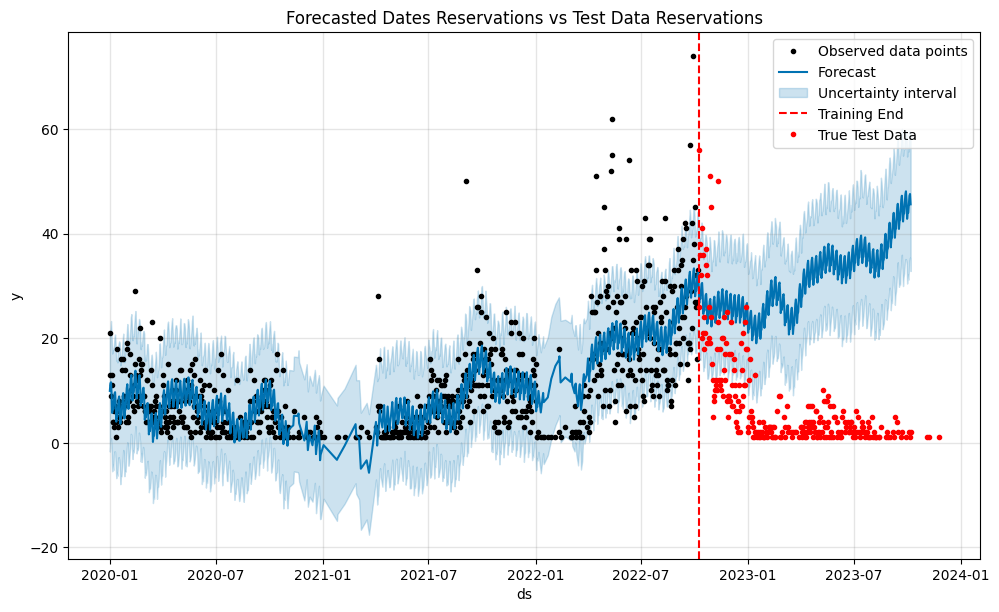

In [83]:
import matplotlib.pyplot as plt

forecast_plot = prophet_model_fit.plot(prophet_demand_score_forecast)
axes = forecast_plot.gca()
last_training_date = prophet_demand_score_forecast['ds'].iloc[last_training_date_index]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')
df_data_test['ds'] = pd.to_datetime(df_data_test['ds'])
plt.plot(df_data_test['ds'], df_data_test['y'],'ro', markersize=3, label='True Test Data')
plt.legend()
plt.title("Forecasted Dates Reservations vs Test Data Reservations")


The forecasting with Prophet for this series is terrible. In the train zone stays in confidence zone but in the test zone. Let's see if witch hyper parameter tuning we can improve.

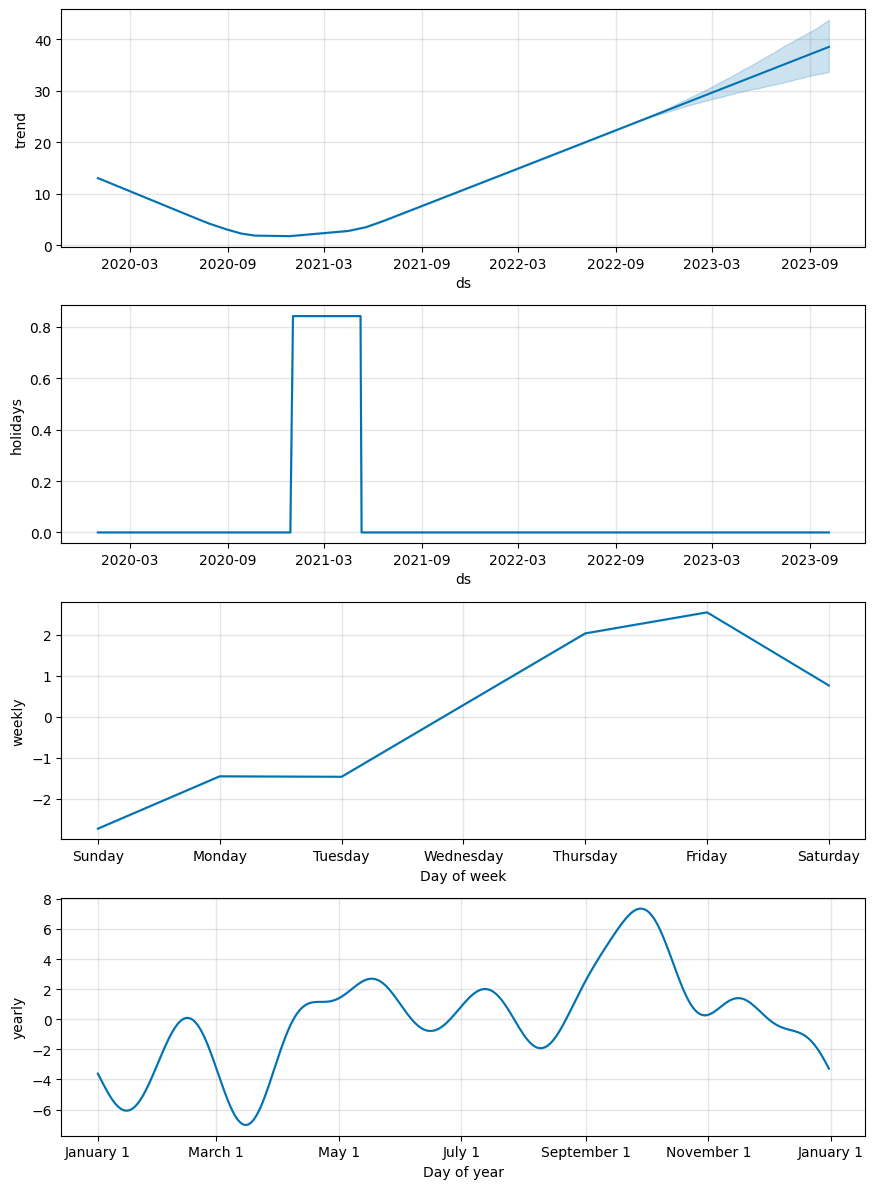

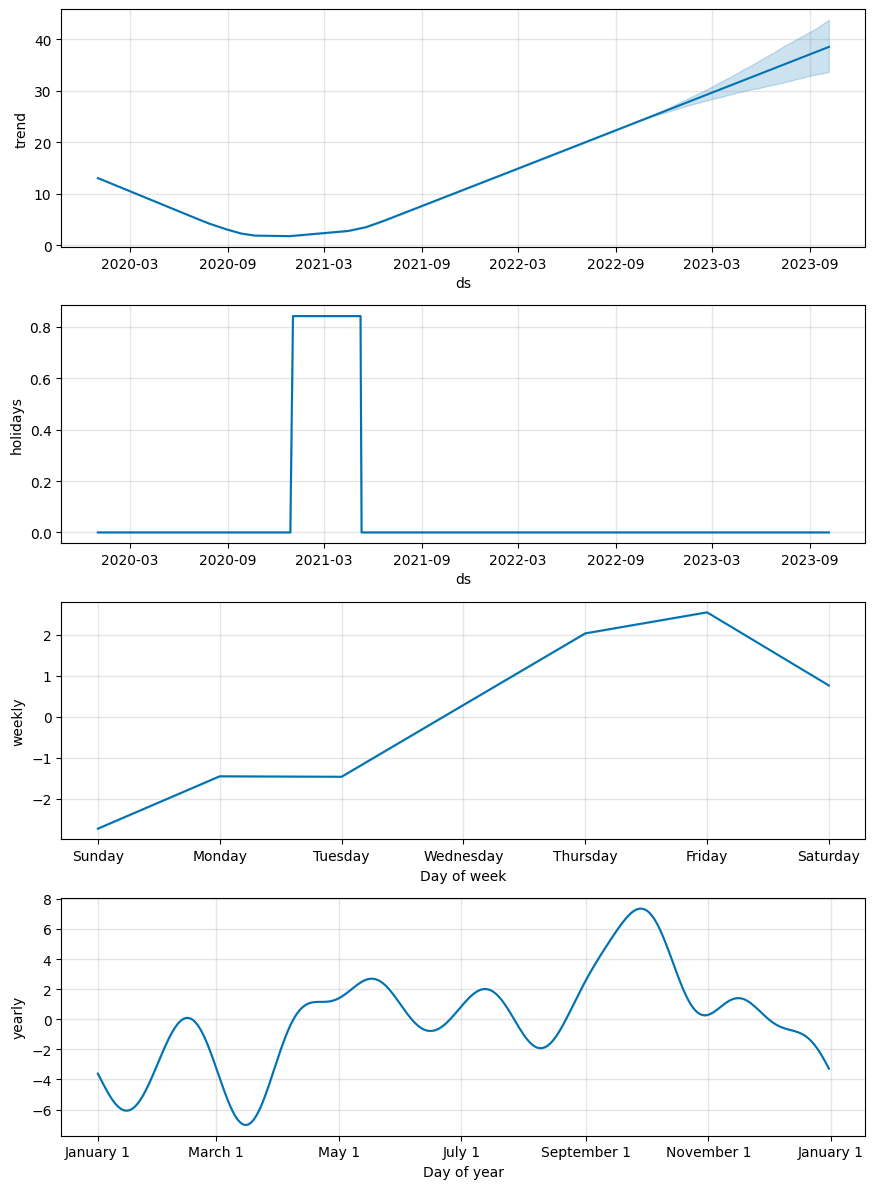

In [84]:
prophet_model.plot_components(prophet_demand_score_forecast)



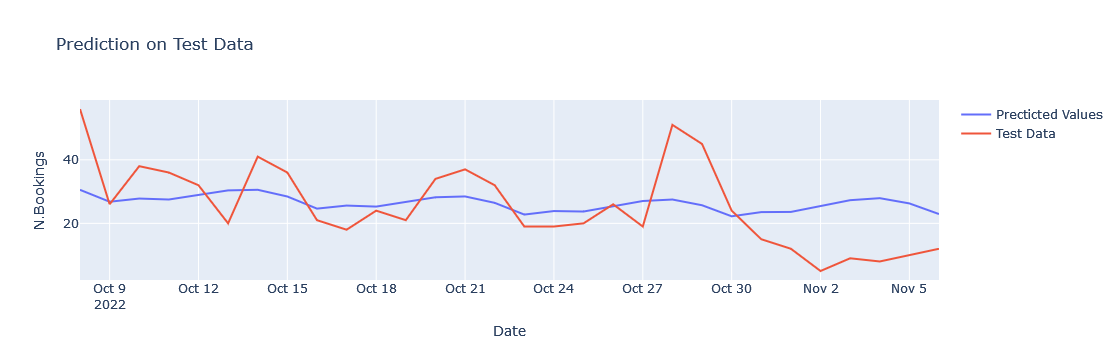

In [85]:
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
df_data_test_predict = prophet_model_fit.predict(df_data_test)
df_data_test_predict = df_data_test_predict[df_data_test_predict['yhat']>0]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_data_test_predict['ds'].iloc[:30], y=df_data_test_predict['yhat'].iloc[:30], mode='lines', name='Precticted Values'))
fig.add_trace(go.Scatter(x=df_data_test['ds'].iloc[:30], y=df_data_test['y'].iloc[:30], mode='lines', name='Test Data'))
fig.update_layout(title="Prediction on Test Data", xaxis_title="Date", yaxis_title="N.Bookings")



Absolutely with this time series, Prophet is very hard to automate. Let's give a try with hyperparameter search.

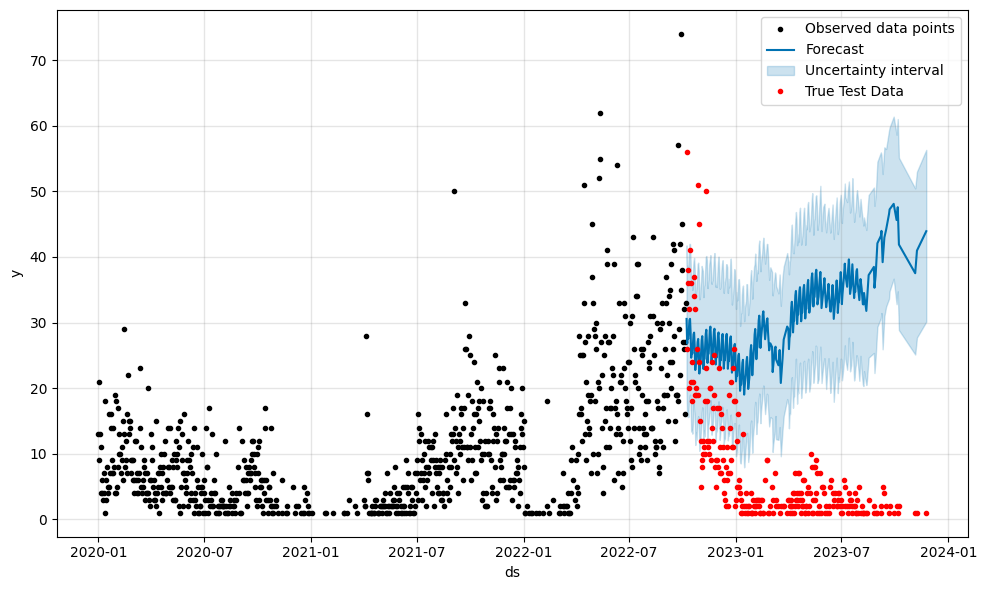

In [86]:
import matplotlib.pyplot as plt

forecast_plot = prophet_model.plot(df_data_test_predict)
axes = forecast_plot.gca()
df_data_test.reset_index(drop=True)
#last_training_date = prophet_demand_score_forecast['ds'].iloc[last_training_date_index]
#axes.axvline(x=last_training_date_index, color='red', linestyle='--', label='Training End')
plt.plot(df_data_test['ds'], df_data_test['y'],'ro', markersize=3, label='True Test Data')
plt.legend()

Even at 30 days horizone we re not going so well with predictions.

In [87]:
# prophet has cross validaton
from prophet.diagnostics import cross_validation, performance_metrics
number_initial_days =366
df_cv = cross_validation(prophet_model_fit, initial=number_initial_days, period='15 days', horizon='30 days')
df_p = performance_metrics(df_cv)
df_p.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/66 [00:00<?, ?it/s]

14:59:31 - cmdstanpy - INFO - Chain [1] start processing
14:59:31 - cmdstanpy - INFO - Chain [1] done processing
14:59:31 - cmdstanpy - INFO - Chain [1] start processing
14:59:31 - cmdstanpy - INFO - Chain [1] done processing
14:59:31 - cmdstanpy - INFO - Chain [1] start processing
14:59:31 - cmdstanpy - INFO - Chain [1] done processing
14:59:32 - cmdstanpy - INFO - Chain [1] start processing
14:59:32 - cmdstanpy - INFO - Chain [1] done processing
14:59:32 - cmdstanpy - INFO - Chain [1] start processing
14:59:32 - cmdstanpy - INFO - Chain [1] done processing
14:59:32 - cmdstanpy - INFO - Chain [1] start processing
14:59:32 - cmdstanpy - INFO - Chain [1] done processing
14:59:32 - cmdstanpy - INFO - Chain [1] start processing
14:59:32 - cmdstanpy - INFO - Chain [1] done processing
14:59:32 - cmdstanpy - INFO - Chain [1] start processing
14:59:32 - cmdstanpy - INFO - Chain [1] done processing
14:59:33 - cmdstanpy - INFO - Chain [1] start processing
14:59:33 - cmdstanpy - INFO - Chain [1]

horizon          mse       rmse        mae      mape     mdape     smape  \
0  3 days  1259.157327  35.484607  10.346314  2.264569  0.539139  0.755012   
1  4 days  1046.480923  32.349357  10.416884  2.083783  0.637989  0.805710   
2  5 days   812.549387  28.505252  10.561342  2.141604  0.718475  0.873399   
3  6 days   536.737038  23.167586   9.953435  2.319528  0.767005  0.863880   
4  7 days   353.980340  18.814365   9.423998  2.208888  0.724336  0.864137   

   coverage  
0  0.743580  
1  0.696278  
2  0.657091  
3  0.620430  
4  0.619355

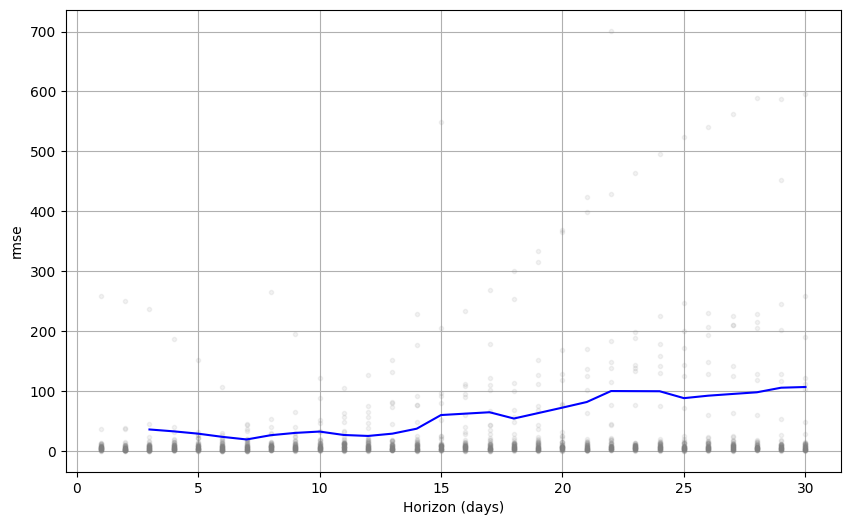

In [88]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')


As it is the value of RMSE is too high, we need to install optuna and tune hyperparameters. Our horizon is 30 days.

In [89]:
!pip install optuna

### Prophet Hyperparameter Tuning
Accordingly to prophet documentation, if we want to tune parameters, the first ones to be tunned should be:
1. **changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend and, in particular, how much the trend changes at the trend changepoints.
2. **seasonality_prior_scale**: This parameter controls the flexibility of the seasonality.
3. **holidays**: This controls flexibility to fit holiday effects.
4. **seasonality_mode**: Options are ['additive', 'multiplicative'].

We will use [Optuna](https://optuna.org/) for hyperparamter tuning. The main reason are the speed of execution and flexibility: it adapts to any machine learning model, it is written in Rust with python binding (so it is fast) and uses a different approach from GridSearch. Instead of exploring randomly the parameter space and trying to find the best uses an heuristic to prune the solutions and converge faster. It works in several step:
- define an objective function
- create a number of trials
- create study that trigger the trials
- find the best parameters as result ot that study.

Also we've seen that Prophet is not performing well with this data, for our purpose it might be enough restrict the horizon to 30 days and put the period at 3 days. Peridically this training come with new data that we monitor and so we would like to focus only in the short period.

First from [Prophet Hyperparamter documentation](https://facebook.github.io/prophet/docs/diagnostics.html) we see which are parameter interested to us.

In [90]:
import optuna
from scipy.stats import uniform


Now we have to define the objective function using above parameters variation. Optuna has the concept of objective function to satisfy in order to perform early stopping.

In [91]:
def objective(trial):
    params = {
        'changepoint_range': uniform(0.5,0.5),
        'seasonality_mode': ['additive','multiplicative'],
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.1, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 15),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
    }

    m = Prophet(**params, holidays=hotel_closure)
    m.add_seasonality(name='weekly',period=7, fourier_order=trial.suggest_int('weekly_seasonality', 1, 52))
    m.add_seasonality(name='yearly', period=365.25, fourier_order=trial.suggest_int('yearly_seasonality', 1, 20))

    fit = m.fit(prophet_ds)

    number_initial_days = (df_data_train['ds'].max() - df_data_train['ds'].min()).days - 30
    if number_initial_days < 0:
        raise ValueError("Insufficient data for cross-validation")

    # period is cycle of sampling
    df_cv = cross_validation(fit,
                             initial=f'{number_initial_days} days',
                             period='2 days',
                             horizon='30 days',
                             parallel="processes")

    df_p = performance_metrics(df_cv, rolling_window=1)
    if df_p.empty:
        raise ValueError("Cross-validation returned an empty performance metrics dataframe")

    return df_p['mape'].values[0]


In [92]:
study = optuna.create_study(study_name="demandscore_prophet",direction='minimize')
# in production we can try up to 100 but in this case we limit to 30
study.optimize(objective, n_trials=20)

[I 2024-11-10 14:59:43,064] A new study created in memory with name: demandscore_prophet
14:59:43 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] done processing
14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:45 - cmdstanpy - INFO - Chain [1] start processing
14:59:45 - cmdstanpy - INFO - Chain [1] start processing
14:59:45 - cmdstanpy - INFO - Chain [1] start processing
14:59:46 - cmdstanpy - INFO - Chain [1] done processing
14:59:47 - cmdstanpy - INFO - Chain [1] done processing
14

In [93]:
study.best_params

{'changepoint_prior_scale': 6.453113719736157,
 'changepoint_range': 0.7924846583354399,
 'seasonality_prior_scale': 6.020177016976708,
 'holidays_prior_scale': 9.923153527294943,
 'seasonality_mode': 'multiplicative',
 'weekly_seasonality': 33,
 'yearly_seasonality': 18}

### Prophet Predictions.

In [94]:
prophet_model = Prophet(**study.best_params)
prophet_model_fit = prophet_model.fit(df_data_train)

15:21:56 - cmdstanpy - INFO - Chain [1] start processing
15:21:57 - cmdstanpy - INFO - Chain [1] done processing


In [95]:
number_initial_days = (df_data_train['ds'].max() - df_data_train['ds'].min()).days - 30
df_cv = cross_validation(prophet_model, initial=f'{number_initial_days} days', period='15 days', horizon='30 days',parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

15:21:57 - cmdstanpy - INFO - Chain [1] start processing
15:21:58 - cmdstanpy - INFO - Chain [1] done processing


horizon         mse       rmse        mae      mape     mdape     smape  \
0 30 days  183.776446  13.556417  10.269744  0.350268  0.277637  0.349798   

   coverage  
0       0.5

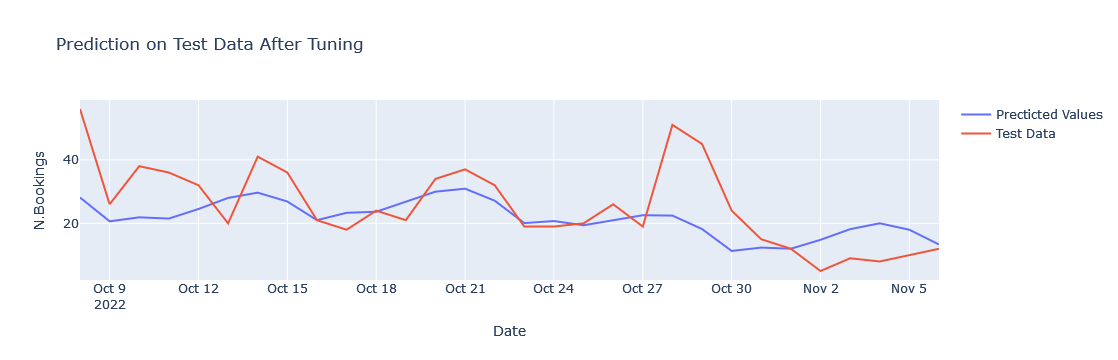

In [96]:
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
# we use the model
one_month_test_data = df_data_test[:30]
one_month_predict = prophet_model_fit.predict(one_month_test_data)

fig = go.Figure()
fig.add_trace(go.Scatter(x=one_month_predict['ds'], y=one_month_predict['yhat'], mode='lines', name='Precticted Values'))
fig.add_trace(go.Scatter(x=one_month_test_data['ds'], y=one_month_test_data['y'], mode='lines', name='Test Data'))
fig.update_layout(title="Prediction on Test Data After Tuning", xaxis_title="Date", yaxis_title="N.Bookings")

The result after hyperparameter tuning are not good. The values of MAPE and RMSE are too high. MAPE indicates for [time series](https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=forecasting-statistical-details)
the error in percentuage on forecasting whereas RMSE indicate the error over time of the time series. Our customer know that et least 12 rooms can be empty or saved to avoid overbooking. This will help to maximize the revenue. For this data Prophet is not indicated.

## Base SARIMAX 

We select two subset of the series range one for training and one for testing. In this case we require stationarity so we will use the differentiated model.

We've to choose the parameters for SARIMAX.
<table>
<tr><td>p</td><td>the order of the Autoregressive Component term or the number of time lags</td></tr>
<tr><td>d</td><td>the minimum differencing value</td></tr>
<tr><td>q</td><td>the order of the MA model or the number of differencing needed to make time stationary</td></tr>
<tr><td>z</td><td>the seasonality (daily, weekly and so on.)</td><tr>
</table>

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
booking_series_train = df_data_train['y']
booking_series_train.head()
booking_series_test = df_data_test['y']


In [98]:
import holidays
seasonal_order=(2,1,1,7)
am_order=(1,0,1)
hdays = holidays.country_holidays('IT') 

# Create holiday indicator
holiday_indicator = booking_series_train.index.isin(hdays).astype(int)
sarimax_model = SARIMAX(booking_series_train,am_order=am_order,seasonal_order=seasonal_order, exog=holiday_indicator)
sarimax_model = sarimax_model.fit()
sarimax_model.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40718D+00    |proj g|=  3.85258D-02

At iterate    5    f=  3.35142D+00    |proj g|=  6.10832D-02

At iterate   10    f=  3.34461D+00    |proj g|=  2.51696D-02

At iterate   15    f=  3.34383D+00    |proj g|=  1.71291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   1.563D-06   3.344D+00
  F =   3.3438257688921293     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  798
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 7)   Log Likelihood               -2668.373
Date:                             Sun, 10 Nov 2024   AIC                           5348.746
Time:                                     15:22:00   BIC                           5376.786
Sample:                                          0   HQIC                          5359.523
                                             - 798                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0   1.51e-08          0      1.000   -2.97e-08    2.97e-08
ar.L1          0.3600      0.024     14.762      0.000       0.312       0.408
ar.S.L7        0.0788      0.038      2.065      0.039       0.004       0.154
ar.S.L14       0.1032      0.040      2.557      0.011       0.024       0.182
ma.S.L7       -0.8666      0.027    -32.316      0.000      -0.919      -0.814
sigma2        49.3535      1.151     42.862      0.000      47.097      51.610
===================================================================================
Ljung-Box (L1) (Q):                   3.35   Jarque-Bera (JB):              2248.44
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               4.83   Skew:                             1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+23. Standard errors may be unstable.
"""

### Perfomance Measurement .

Test data prediction, from 2022-10-08 to 2023-11-24, Length test data: 266


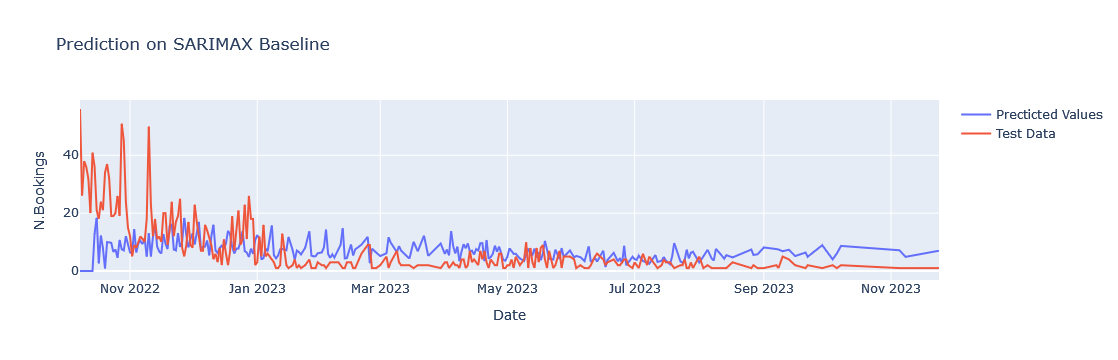

In [99]:
#get the predictions and residual
start_date = pd.to_datetime(df_data_test['ds'].iloc[0]).strftime('%Y-%m-%d')
end_date = pd.to_datetime(df_data_test['ds'].iloc[-1]).strftime('%Y-%m-%d')
print(f'Test data prediction, from {start_date} to {end_date}, Length test data: {len(df_data_test)}')
predictions = sarimax_model.predict(start=0, end=len(df_data_test) - 1)
predictions.reset_index(drop=True, inplace=True)
plot_data = df_data_test.copy()
plot_data.reset_index(drop=True, inplace=True)
plot_data[predictions.name] = predictions
current_data = pd.DataFrame(plot_data).rename(columns={'predicted_mean': 'PredictedBooking', 'y': 'ActualBooking', 'ds': 'Date'})
current_data['Residual'] = residuals = current_data['ActualBooking'] - current_data['PredictedBooking']
fig = go.Figure()
fig.add_trace(go.Scatter(x=current_data['Date'], y=current_data['PredictedBooking'], mode='lines', name='Precticted Values'))
fig.add_trace(go.Scatter(x=current_data['Date'], y=current_data['ActualBooking'], mode='lines', name='Test Data'))
fig.update_layout(title="Prediction on SARIMAX Baseline", xaxis_title="Date", yaxis_title="N.Bookings")
fig.show()


In [100]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
print("Root mean squared error:",round(mean_squared_error(current_data['ActualBooking'], current_data['Residual'],squared=False),5))
print("Mean absolute error:",round(mean_absolute_error(current_data['ActualBooking'], current_data['Residual']),5))

Root mean squared error: 7.92075
Mean absolute error: 7.13987


OK. This looks very promising, grnerally at most 7 room to spare in this model. The customer knows that there is oscillation of plus 7 rooms to spare.


## Model 2: SARIMAX
We proceed in this way:
- Generate all possible combinations of parameters
- Define an function objective (ie. minimize RMSE or MAPE).
- Create an optuna study to achieve the Goal:
  1. Iteratively fit the model with train data changing hyperparameters
  2. Check the residual from the predictons and the test data.

We cross validate during hyperparameter seach

In [101]:
import itertools
from sklearn.model_selection import TimeSeriesSplit
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [102]:

def objective_sarima_with_cross_validation(trial):
    time_series_cv = TimeSeriesSplit(n_splits=5)
    error = []

    for train_index, test_index in time_series_cv.split(booking_series_train):
      try:
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        order=trial.suggest_categorical('order',pdq)
        seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
        trend=trial.suggest_categorical('trend',['n','c','t','ct',None])
        sarimax_model=SARIMAX(X_train,order=order, seasonal_order=seasonal_order,trend=trend,initialization='approximate_diffuse')
        fitted_model = sarimax_model.fit()
        predictions = fitted_model.forecast(len(X_test))
        predictions.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        residuals = X_test - predictions
        rmse=mean_squared_error(X_test, residuals,squared=False)
        error.append(rmse)
      except Exception as e:
        print(e)
        rmse=float('inf')
    return np.mean(error)

In [103]:

study=optuna.create_study(direction="minimize")
study.optimize(objective_sarima_with_cross_validation,n_trials=10)

[I 2024-11-10 15:22:00,582] A new study created in memory with name: no-name-ceb71fc7-1719-4ca5-909a-f906b696ce67


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62189D-01    |proj g|=  1.09184D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      3     22      1     0     0   8.274D+00   4.622D-01
  F =  0.46218832061912241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.30191D-01    |proj g|=  3.82354D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   3.824D+01  -4.302D-01
  F = -0.43019077697061697     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.84509D-01    |proj g|=  9.75625D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     48      2     0     0   8.703D+01  -7.845D-01
  F = -0.78450908037282951     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.97878D-01    |proj g|=  1.10992D+02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     29      1     0     0   1.102D+02  -7.979D-01
  F = -0.79787814704843296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.00199D-01    |proj g|=  1.11782D+02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
[I 2024-11-10 15:22:08,505] Trial 0 finished with value: 0.049448201047040674 and parameters: {'order': (2, 1, 0), 'seasonal_order': (1, 0, 2, 12), 'trend': 't'}. Best is trial 0 with value: 0.049448201047040674.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     50      2     0     0   1.110D+02  -7.002D-01
  F = -0.70019917733736281     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44569D+00    |proj g|=  1.51909D+01


 This problem is unconstrained.



At iterate    5    f=  1.44336D+00    |proj g|=  3.49648D+01

At iterate   10    f=  1.33407D+00    |proj g|=  2.75356D+02

At iterate   15    f=  1.30669D+00    |proj g|=  2.42438D-01

At iterate   20    f=  1.30626D+00    |proj g|=  7.12170D+00

At iterate   25    f=  1.28706D+00    |proj g|=  5.44740D+01

At iterate   30    f=  8.30482D-01    |proj g|=  7.36781D+01

At iterate   35    f=  8.26922D-01    |proj g|=  2.19990D+01

At iterate   40    f=  7.87966D-01    |proj g|=  1.15262D+01

At iterate   45    f=  7.64044D-01    |proj g|=  7.75186D+01

At iterate   50    f=  7.53925D-01    |proj g|=  3.60377D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.44699D-01    |proj g|=  4.68726D+01

At iterate   10    f=  2.19469D-01    |proj g|=  6.74025D+02

At iterate   15    f=  5.57775D-02    |proj g|=  4.14136D+01

At iterate   20    f=  5.41259D-02    |proj g|=  1.12214D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     36      1     0     0   1.122D+00   5.413D-02
  F =   5.4125852313997733E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78250D-01    |proj g|=  3.46666D+02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4     30      1     0     0   1.917D+02  -1.786D-01
  F = -0.17856155228958764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34095D-01    |proj g|=  5.79770D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4     28      1     0     0   3.196D+02  -2.346D-01
  F = -0.23462108870964626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.76140D-01    |proj g|=  2.90465D+02


 This problem is unconstrained.



At iterate    5    f= -1.77987D-01    |proj g|=  4.40200D+01

At iterate   10    f= -1.81326D-01    |proj g|=  6.79378D+02

At iterate   15    f= -2.01710D-01    |proj g|=  4.29822D+03

At iterate   20    f= -2.07610D-01    |proj g|=  2.91979D+03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     75      1     0     0   2.880D+03  -2.076D-01
  F = -0.20761135818123622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[I 2024-11-10 15:22:23,877] Trial 1 finished with value: 0.29856974891244814 and parameters: {'order': (1, 0, 1), 'seasonal_order': (1, 2, 1, 12), 'trend': 'ct'}. Best is trial 0 with value: 0.049448201047040674.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.17200D-01    |proj g|=  9.71475D-02

At iterate    5    f= -3.20504D-01    |proj g|=  5.99502D-02

At iterate   10    f= -3.20576D-01    |proj g|=  1.71847D-01

At iterate   15    f= -3.22973D-01    |proj g|=  4.89718D-01

At iterate   20    f= -3.23396D-01    |proj g|=  1.97242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   3.083D-04  -3.234D-01
  F = -0.32339574647176594     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -9.27898D-01    |proj g|=  7.35033D-02

At iterate   10    f= -9.27907D-01    |proj g|=  5.49063D-03

At iterate   15    f= -9.27944D-01    |proj g|=  7.63338D-02

At iterate   20    f= -9.28073D-01    |proj g|=  4.59639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     39      1     0     0   1.198D-04  -9.281D-01
  F = -0.92807337568818005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
[I 2024-11-10 15:22:24,758] Trial 2 finished with value: 0.048325544928591244 and parameters: {'order': (0, 1, 0), 'seasonal_order': (1, 0, 1, 12), 'trend': None}. Best is trial 2 with value: 0.048325544928591244.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.88372D-01    |proj g|=  1.84790D-01

At iterate    5    f= -7.88454D-01    |proj g|=  3.12900D-02

At iterate   10    f= -7.88468D-01    |proj g|=  1.15329D-02

At iterate   15    f= -7.88530D-01    |proj g|=  1.42268D-01

At iterate   20    f= -7.89231D-01    |proj g|=  3.89527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     26      1     0     0   3.119D-06  -7.892D-01
  F = -0.78923654881711891     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55301D-01    |proj g|=  1.61610D+01

At iterate    5    f=  7.75248D-01    |proj g|=  4.56030D-01

At iterate   10    f=  5.73870D-01    |proj g|=  2.27406D-01

At iterate   15    f=  5.29509D-01    |proj g|=  1.73302D-01

At iterate   20    f=  5.01384D-01    |proj g|=  9.03064D-02

At iterate   25    f=  4.97480D-01    |proj g|=  9.32640D-02

At iterate   30    f=  4.96214D-01    |proj g|=  1.24981D-01

At iterate   35    f=  4.88917D-01    |proj g|=  9.71231D-01

At iterate   40    f=  4.84148D-01    |proj g|=  2.55532D-02

At iterate   45    f=  4.84067D-01    |proj g|=  1.35140D-02

At iterate   50    f=  4.84056D-01    |proj g|=  1.41530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.58409D-01    |proj g|=  2.96131D+00

At iterate   10    f= -3.97621D-01    |proj g|=  2.26258D-01

At iterate   15    f= -4.22443D-01    |proj g|=  1.71733D+00

At iterate   20    f= -4.53759D-01    |proj g|=  3.82508D-01

At iterate   25    f= -4.98303D-01    |proj g|=  3.13801D-01

At iterate   30    f= -4.99505D-01    |proj g|=  1.61293D-01

At iterate   35    f= -5.00455D-01    |proj g|=  9.52360D-02

At iterate   40    f= -5.00933D-01    |proj g|=  1.39678D-01

At iterate   45    f= -5.01248D-01    |proj g|=  9.66351D-02

At iterate   50    f= -5.05253D-01    |proj g|=  3.01983D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -6.14907D-01    |proj g|=  3.14613D+00

At iterate   10    f= -7.55184D-01    |proj g|=  2.44694D-01

At iterate   15    f= -7.80340D-01    |proj g|=  1.61784D+00

At iterate   20    f= -8.12643D-01    |proj g|=  3.22623D-01

At iterate   25    f= -8.52328D-01    |proj g|=  8.69038D-02

At iterate   30    f= -8.60714D-01    |proj g|=  1.20465D-02

At iterate   35    f= -8.61037D-01    |proj g|=  1.84089D-02

At iterate   40    f= -8.61160D-01    |proj g|=  1.02456D-02

At iterate   45    f= -8.62422D-01    |proj g|=  3.33031D-01

At iterate   50    f= -8.64333D-01    |proj g|=  4.22899D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -8.61603D-01    |proj g|=  1.18704D+00

At iterate   10    f= -8.65847D-01    |proj g|=  3.48105D-01

At iterate   15    f= -8.68004D-01    |proj g|=  8.81437D-01

At iterate   20    f= -8.78735D-01    |proj g|=  1.32665D-01

At iterate   25    f= -8.86551D-01    |proj g|=  1.41830D-02

At iterate   30    f= -8.87027D-01    |proj g|=  2.47697D-02

At iterate   35    f= -8.87050D-01    |proj g|=  2.53815D-03

At iterate   40    f= -8.87088D-01    |proj g|=  5.75353D-02

At iterate   45    f= -8.87208D-01    |proj g|=  3.76229D-03

At iterate   50    f= -8.87210D-01    |proj g|=  6.15552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -7.80377D-01    |proj g|=  1.62077D+00

At iterate   10    f= -7.92925D-01    |proj g|=  5.41970D-01

At iterate   15    f= -7.94872D-01    |proj g|=  6.87586D-02

At iterate   20    f= -7.95164D-01    |proj g|=  1.30068D-02

At iterate   25    f= -7.95307D-01    |proj g|=  9.97314D-02

At iterate   30    f= -7.95472D-01    |proj g|=  3.10561D-02

At iterate   35    f= -7.96663D-01    |proj g|=  4.55509D-02

At iterate   40    f= -7.96736D-01    |proj g|=  1.38208D-03

At iterate   45    f= -7.96792D-01    |proj g|=  3.04352D-02

At iterate   50    f= -7.96876D-01    |proj g|=  1.18219D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-11-10 15:22:38,621] Trial 3 finished with value: 0.0066897659777499065 and parameters: {'order': (2, 1, 2), 'seasonal_order': (2, 0, 2, 12), 'trend': 'n'}. Best is trial 3 with value: 0.0066897659777499065.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26682D+00    |proj g|=  8.33556D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     43      2     0     0   8.908D-02  -1.273D+00
  F =  -1.2731394251879635     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.3


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   1.225D+02  -1.326D+00
  F =  -1.3261802608045841     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14207D+00    |proj g|=  5.32959D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
[I 2024-11-10 15:22:39,727] Trial 4 finished with value: 0.005495385503634106 and parameters: {'order': (2, 0, 2), 'seasonal_order': (0, 0, 0, 12), 'trend': 't'}. Best is trial 4 with value: 0.005495385503634106.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     44      2     0     0   4.213D+02  -1.142D+00
  F =  -1.1421450607328736     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13544D+00    |proj g|=  3.73831D-01

At iterate    5    f=  1.83923D+00    |proj g|=  1.69074D-01

At iterate   10    f=  1.43906D+00    |proj g|=  9.07876D-02

At iterate   15    f=  1.42251D+00    |proj g|=  6.34147D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  7.30203D-01    |proj g|=  1.83675D-01

At iterate   10    f=  4.94440D-01    |proj g|=  3.69012D-02

At iterate   15    f=  4.37683D-01    |proj g|=  5.09011D-02

At iterate   20    f=  4.28843D-01    |proj g|=  4.09099D-02

At iterate   25    f=  4.28567D-01    |proj g|=  9.68188D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   4.497D-04   4.286D-01
  F =  0.42856604369320833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.72754D-01    |proj g|=  2.24779D+00

At iterate   10    f=  7.27079D-02    |proj g|=  2.04527D-01

At iterate   15    f=  4.25455D-02    |proj g|=  2.68326D-01

At iterate   20    f=  7.20715D-03    |proj g|=  6.58973D-02

At iterate   25    f= -2.12795D-02    |proj g|=  2.32595D-02

At iterate   30    f= -2.28575D-02    |proj g|=  2.62913D-02
  ys=-5.821E-06  -gs= 1.122E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     53      1     1     0   1.890D-02  -2.287D-02
  F =  -2.2871430222351847E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate    5    f=  2.07890D-01    |proj g|=  2.25279D+00

At iterate   10    f= -3.58888D-02    |proj g|=  2.74168D-01

At iterate   15    f= -7.66747D-02    |proj g|=  2.60626D+00

At iterate   20    f= -1.05431D-01    |proj g|=  4.63101D-01

At iterate   25    f= -1.14484D-01    |proj g|=  1.00884D-01

At iterate   30    f= -1.14877D-01    |proj g|=  3.57204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     46      1     0     0   3.585D-03  -1.149D-01
  F = -0.11487655957970903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.89452D-01    |proj g|=  1.11887D-01

At iterate   10    f=  4.10746D-02    |proj g|=  1.97046D-01

At iterate   15    f=  8.17098D-03    |proj g|=  1.46680D-02

At iterate   20    f= -1.38178D-02    |proj g|=  3.63933D-02

At iterate   25    f= -1.45785D-02    |proj g|=  8.05725D-03

At iterate   30    f= -1.46075D-02    |proj g|=  1.99817D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     58      1     0     0   1.997D-02  -1.461D-02
  F =  -1.4607541764643954E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[I 2024-11-10 15:22:47,491] Trial 5 finished with value: 0.5492951413194789 and parameters: {'order': (0, 2, 2), 'seasonal_order': (1, 2, 0, 12), 'trend': 'n'}. Best is trial 4 with value: 0.005495385503634106.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94141D-01    |proj g|=  1.84670D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     44      2     0     0   6.306D+00   3.941D-01
  F =  0.39412370894444687     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.48605D-01    |proj g|=  3.81256D+01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   3.813D+01  -5.486D-01
  F = -0.54860458984016303     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.91977D-01    |proj g|=  1.06849D+02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     44      2     0     0   8.606D+01  -8.920D-01
  F = -0.89197856105455142     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.10988D-01    |proj g|=  1.23255D+02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   1.233D+02  -9.110D-01
  F = -0.91098833092877229     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.12718D-01    |proj g|=  1.33399D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
[I 2024-11-10 15:22:53,914] Trial 6 finished with value: 0.006177234296589072 and parameters: {'order': (2, 0, 0), 'seasonal_order': (2, 0, 0, 12), 'trend': 't'}. Best is trial 4 with value: 0.005495385503634106.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     52      2     0     0   1.319D+02  -8.127D-01
  F = -0.81271791403919180     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.33200D-02    |proj g|=  2.62368D-01


 This problem is unconstrained.



At iterate    5    f= -1.23518D-01    |proj g|=  3.25159D-01

At iterate   10    f= -2.40583D-01    |proj g|=  1.67865D+01

At iterate   15    f= -2.59290D-01    |proj g|=  2.01844D-01

At iterate   20    f= -2.67511D-01    |proj g|=  5.36919D+00

At iterate   25    f= -2.68781D-01    |proj g|=  7.51326D-02

At iterate   30    f= -2.70746D-01    |proj g|=  4.06083D+00

At iterate   35    f= -2.80840D-01    |proj g|=  3.94377D+00

At iterate   40    f= -2.81410D-01    |proj g|=  2.82522D-01

At iterate   45    f= -2.81703D-01    |proj g|=  8.11337D+00

At iterate   50    f= -2.90176D-01    |proj g|=  2.20886D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -7.48523D-01    |proj g|=  6.83586D+00

At iterate   15    f= -7.87179D-01    |proj g|=  6.91979D-01

At iterate   20    f= -7.88395D-01    |proj g|=  1.88769D-01

At iterate   25    f= -7.90237D-01    |proj g|=  1.56415D+00

At iterate   30    f= -7.90680D-01    |proj g|=  2.26943D-02

At iterate   35    f= -7.93999D-01    |proj g|=  1.04178D+00

At iterate   40    f= -8.08714D-01    |proj g|=  1.70519D-01

At iterate   45    f= -8.09370D-01    |proj g|=  1.08347D-01

At iterate   50    f= -8.17541D-01    |proj g|=  2.61344D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     71   

 This problem is unconstrained.



At iterate    5    f= -9.24466D-01    |proj g|=  1.00880D+00

At iterate   10    f= -9.57285D-01    |proj g|=  2.73715D+00

At iterate   15    f= -9.94444D-01    |proj g|=  3.10682D-01

At iterate   20    f= -9.94570D-01    |proj g|=  4.98367D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     40      1     0     0   4.984D-01  -9.946D-01
  F = -0.99456988613983688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -8.38912D-01    |proj g|=  1.61571D-01

At iterate   10    f= -8.63449D-01    |proj g|=  4.43145D+00

At iterate   15    f= -8.81207D-01    |proj g|=  6.92750D-01

At iterate   20    f= -9.02390D-01    |proj g|=  3.44932D+00

At iterate   25    f= -9.21625D-01    |proj g|=  1.11644D-01

At iterate   30    f= -9.58226D-01    |proj g|=  9.92858D-01

At iterate   35    f= -9.81740D-01    |proj g|=  8.13908D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     70      1     0     0   2.338D-01  -9.824D-01
  F = -0.98243278006714174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -7.13324D-01    |proj g|=  1.94411D+00

At iterate   10    f= -7.25403D-01    |proj g|=  1.38257D+00

At iterate   15    f= -7.44833D-01    |proj g|=  3.00493D+00

At iterate   20    f= -7.74687D-01    |proj g|=  7.72557D-01

At iterate   25    f= -7.84372D-01    |proj g|=  1.23417D+00

At iterate   30    f= -8.34428D-01    |proj g|=  3.27533D+00

At iterate   35    f= -8.41519D-01    |proj g|=  4.99783D-01

At iterate   40    f= -8.41590D-01    |proj g|=  5.95703D-02


[I 2024-11-10 15:22:56,791] Trial 7 finished with value: 0.15038920062399092 and parameters: {'order': (2, 2, 1), 'seasonal_order': (1, 0, 1, 12), 'trend': 'n'}. Best is trial 4 with value: 0.005495385503634106.



At iterate   45    f= -8.41903D-01    |proj g|=  1.56064D+00

At iterate   50    f= -8.43970D-01    |proj g|=  2.70650D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     71      1     1     0   2.707D+00  -8.440D-01
  F = -0.84397009434426085     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55409D+00    |proj g|=  3.78586D+01

At iterate    5    f=  1.55331D+00    |proj g|=  8.15678D+00

At iterate   10    f=  1.54782D+00    |proj g|=  1.13555D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  1.52994D+00    |proj g|=  8.21820D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     56      2     0     0   8.218D-01   1.530D+00
  F =   1.5299427520895050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19452D+00    |proj g|=  5.10832D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.16288D+00    |proj g|=  1.26320D+02

At iterate   10    f=  9.90838D-01    |proj g|=  1.17652D+01

At iterate   15    f=  9.90344D-01    |proj g|=  4.47810D+00

At iterate   20    f=  9.73055D-01    |proj g|=  8.76460D+01

At iterate   25    f=  4.37863D-01    |proj g|=  6.25844D+02

At iterate   30    f=  2.39668D-01    |proj g|=  3.96018D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     84      2     0     0   3.960D+02   2.397D-01
  F =  0.23966840481662730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58663D-01    |proj g|=  6.82679D+00

At iterate    5    f=  9.21042D-01    |proj g|=  2.48334D+02

At iterate   10    f=  6.93648D-01    |proj g|=  2.97077D+01

At iterate   15    f=  6.92705D-01    |proj g|=  2.17803D+00

At iterate   20    f=  6.82765D-01    |proj g|=  8.98300D+01

At iterate   25    f=  3.44993D-01    |proj g|=  1.64613D+02

At iterate   30    f=  4.18420D-02    |proj g|=  3.58244D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93815D-01    |proj g|=  8.63051D+00


 This problem is unconstrained.



At iterate    5    f=  8.93594D-01    |proj g|=  2.92294D+01

At iterate   10    f=  8.56241D-01    |proj g|=  3.19703D+02

At iterate   15    f=  6.64061D-01    |proj g|=  4.61110D+01

At iterate   20    f=  6.62576D-01    |proj g|=  5.61680D-01

At iterate   25    f=  6.60506D-01    |proj g|=  2.62715D+01

At iterate   30    f=  4.19391D-01    |proj g|=  5.71054D+02

At iterate   35    f=  1.27269D-02    |proj g|=  1.12001D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     62      1     0     0   4.264D+02   1.213D-02
  F =   1.2133583024991873E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03629D-01    |proj g|=  1.64866D+04


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     43      2     0     0   2.275D+01   1.986D-01
  F =  0.19864658256789039     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
[I 2024-11-10 15:23:17,779] Trial 8 finished with value: 531.1912102263708 and parameters: {'order': (0, 2, 1), 'seasonal_order': (0, 2, 2, 12), 'trend': 'ct'}. Best is trial 4 with value: 0.005495385503634106.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59585D-01    |proj g|=  2.97028D+00

At iterate    5    f=  8.97079D-02    |proj g|=  2.82623D-01

At iterate   10    f= -2.94553D-02    |proj g|=  8.49927D-01

At iterate   15    f= -7.87468D-02    |proj g|=  2.52459D-01

At iterate   20    f= -8.84485D-02    |proj g|=  6.96608D-02

At iterate   25    f= -8.96218D-02    |proj g|=  2.80622D-02

At iterate   30    f= -8.96659D-02    |proj g|=  1.03686D-02

At iterate   35    f= -8.96709D-02    |proj g|=  1.82344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.67754D-01    |proj g|=  7.34920D-01

At iterate   15    f= -6.04982D-01    |proj g|=  6.59229D-02

At iterate   20    f= -6.07601D-01    |proj g|=  7.57557D-02

At iterate   25    f= -6.07682D-01    |proj g|=  8.67004D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     41      1     0     0   9.403D-03  -6.077D-01
  F = -0.60769581342839207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -7.82824D-01    |proj g|=  2.19444D-01

At iterate   15    f= -8.25326D-01    |proj g|=  7.42338D-02

At iterate   20    f= -8.27890D-01    |proj g|=  4.93880D-03

At iterate   25    f= -8.28250D-01    |proj g|=  7.75700D-03

At iterate   30    f= -8.28260D-01    |proj g|=  2.05323D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     62      1     0     0   9.866D-03  -8.283D-01
  F = -0.82826497316333780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -3.68025D-01    |proj g|=  7.70652D+00

At iterate   10    f= -7.53623D-01    |proj g|=  5.56649D-01

At iterate   15    f= -7.94166D-01    |proj g|=  5.52041D-01

At iterate   20    f= -7.97176D-01    |proj g|=  1.11033D-02

At iterate   25    f= -7.97312D-01    |proj g|=  5.55197D-02

At iterate   30    f= -7.98249D-01    |proj g|=  7.66715D-03

At iterate   35    f= -7.98259D-01    |proj g|=  1.65074D-02

At iterate   40    f= -7.98287D-01    |proj g|=  8.97132D-02

At iterate   45    f= -7.98321D-01    |proj g|=  1.48036D-02

At iterate   50    f= -7.98386D-01    |proj g|=  1.14219D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -7.07519D-01    |proj g|=  1.13840D-02

At iterate   10    f= -7.08751D-01    |proj g|=  5.86904D-01

At iterate   15    f= -7.20959D-01    |proj g|=  2.74819D-01

At iterate   20    f= -7.23536D-01    |proj g|=  5.65762D-02

At iterate   25    f= -7.23768D-01    |proj g|=  2.11869D-02

At iterate   30    f= -7.23804D-01    |proj g|=  1.93289D-02


[I 2024-11-10 15:23:24,898] Trial 9 finished with value: 0.15477960136575292 and parameters: {'order': (0, 2, 1), 'seasonal_order': (0, 1, 1, 12), 'trend': None}. Best is trial 4 with value: 0.005495385503634106.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     52      1     0     0   1.937D-02  -7.238D-01
  F = -0.72380355685494813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [104]:
test_data_cv = df_data_test.copy()
sarimax_model_cv=SARIMAX(test_data_cv['y'],order=study.best_params.get('order'), seasonal_order=study.best_params.get('seasonal_order'),trend=study.best_params.get('trend'),initialization='approximate_diffuse')
fitted_model_cv = sarimax_model_cv.fit()
predictions_cv = fitted_model_cv.forecast(len(test_data_cv))
predictions.reset_index(drop=True, inplace=True)
test_data_cv.reset_index(drop=True, inplace=True)
residuals_cv = test_data_cv['y'] - predictions
rmse=mean_squared_error(test_data_cv['y'], residuals_cv,squared=False)
mape=mean_absolute_percentage_error(test_data_cv['y'], residuals_cv)
print(f"RMSE: {rmse}")
print(f'MAPE: {mape}')
print(f"Best Params for SARIMAX: {study.best_params}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14151D+00    |proj g|=  2.11499D+00

At iterate    5    f=  3.14058D+00    |proj g|=  5.26297D-01

At iterate   10    f=  3.13231D+00    |proj g|=  5.43917D+00

At iterate   15    f=  3.11901D+00    |proj g|=  1.99463D-01


 This problem is unconstrained.



At iterate   20    f=  3.11856D+00    |proj g|=  2.05087D-01

At iterate   25    f=  3.11571D+00    |proj g|=  6.43520D-02

At iterate   30    f=  3.11314D+00    |proj g|=  2.21507D+00

At iterate   35    f=  3.11161D+00    |proj g|=  8.18458D-02

At iterate   40    f=  3.11155D+00    |proj g|=  8.35105D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     47      1     0     0   8.351D-02   3.112D+00
  F =   3.1115525622402918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RMSE: 7.920749480522986
MAPE: 2.6636613408905383
Best Params for SARIMAX: {'order': (2, 0, 2), 'seasonal_order': 

Test data prediction, from 2022-10-08 to 2023-11-24, Length test data: 266


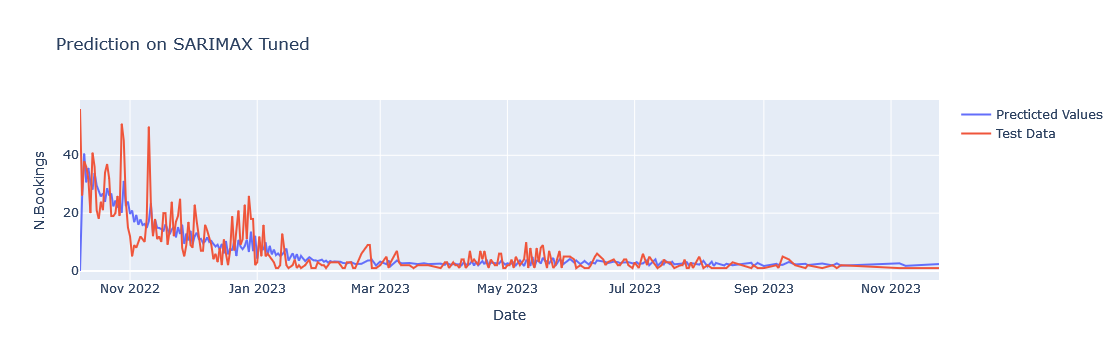

In [105]:
start_date = pd.to_datetime(df_data_test['ds'].iloc[0]).strftime('%Y-%m-%d')
end_date = pd.to_datetime(df_data_test['ds'].iloc[-1]).strftime('%Y-%m-%d')
print(f'Test data prediction, from {start_date} to {end_date}, Length test data: {len(df_data_test)}')
predictions = fitted_model_cv.predict(start=0, end=len(df_data_test) - 1)
predictions.reset_index(drop=True, inplace=True)
plot_data = df_data_test.copy()
plot_data.reset_index(drop=True, inplace=True)
plot_data[predictions.name] = predictions
data_after_tuning = pd.DataFrame(plot_data).rename(columns={'predicted_mean': 'PredictedBooking', 'y': 'ActualBooking', 'ds': 'Date'})
residuals = data_after_tuning['ActualBooking'] - data_after_tuning['PredictedBooking']
data_after_tuning['Residual'] = residuals
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_after_tuning['Date'], y=data_after_tuning['PredictedBooking'], mode='lines', name='Precticted Values'))
fig.add_trace(go.Scatter(x=data_after_tuning['Date'], y=data_after_tuning['ActualBooking'], mode='lines', name='Test Data'))
fig.update_layout(title="Prediction on SARIMAX Tuned", xaxis_title="Date", yaxis_title="N.Bookings")
fig.show()


In [106]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
print("Root mean squared error:",round(mean_squared_error(data_after_tuning['ActualBooking'], data_after_tuning['PredictedBooking'],squared=False),5))
print("Mean absolute error:",round(mean_absolute_error(data_after_tuning['ActualBooking'], data_after_tuning['PredictedBooking']),5))


Root mean squared error: 6.18223
Mean absolute error: 3.41757


## Computing Demand Score

For computing the demand score we apply the forecast and than see the trend and from the trend we get the mean we rescale to 100. With this we have defined a process for each hotel series, the algorithm is scattered in two phases: Data Cleaning, Training and Computing the score, basically the following steps. *So for each hotel:
1. Select the hotel booking
2. Clean the data and remove outliers of the last 24 months data.
3. Differentiate the series if stationary
4. Select the model that has the least RMSE between SARIMAX and Prophet.
5. Crossvalidate the model
6. Hyperparameter tuning with Optuna
7. Give to the model a forcast period
8. Check the trend on forecast data.
9. Compute the mean of the trend and rescale to 100.
10. Store the score in JSON in a storage with a timestamp to be used for computing HotelRank



In [107]:
import json
from datetime import datetime
forecast_steps = 30
start_date = '2023-06-01'  # Replace with your chosen start date
forecast = fitted_model_cv.get_forecast(steps=forecast_steps)
summary = forecast.summary_frame()
demand_score =np.cumsum(summary['mean']).iloc[-1]/summary['mean'].count()
print(f'Demand score for Hotel008 is: {demand_score}')
outdata = {'score': demand_score, 'hotel_id': '008', "timestamp": datetime.now().timestamp()}
with open('demand_score_001.json','w') as score:
    json.dump(outdata, score)
    print('Data written on storage')


Demand score for Hotel008 is: 2.491858532597777
Data written on storage


Here we've concluded that SARIMAX is better model for this series, but we have observed that especially for series forcasting there is not a better choice, so we decided in the demand score to try both and see with test data which is the less error prone for the data at the moment.

# Cancellation Score: Classification Study on Hotel Reservations.




Our customer [Blastness](https://blastness.com) holds all booking inside a Property Management System for his clients. Each booking has three states (classes): *Cancelled, Confirmed, Modified*. Our objective is to find an algorithm to compute the cancellation score, based on cancellation forecasting. Most of the recent studies treated as a classification problem. The cancellation factors can depende on hotel, customers, booking and external factors. In our case will leave extrenal factor in the near future. Our goal is to predict the next booking trend for our customers and count the number of cancellation in a future temporal period and compute a score based on the number of cancellations forecasted.
As first step we want to review again the dataset in this classification context, encode categorical data and see results


In [108]:
hb_dataset.head()

Code  Status BookingChannel    Arrival  Departure  \
60820  2493115910/4283897556     1.0    Booking.com 2023-12-28 2024-01-04   
60923  2745673363/4308678121     1.0    Booking.com 2023-12-27 2024-01-03   
61034  3958853713/4337114239     1.0    Booking.com 2023-12-26 2024-01-02   
60873  3854867487/4296773334     1.0    Booking.com 2023-12-26 2024-01-02   
60750  2359160563/4271754038     1.0    Booking.com 2023-12-23 2023-12-31   

       Nights    Total PurchaseDate        LastModified HotelId  \
60820       7  4637.25   2023-06-04 2023-06-04 09:27:30     006   
60923       7  3892.05   2023-06-17 2023-06-17 18:09:53     006   
61034       7  2766.15   2023-07-02 2023-07-02 16:35:28     006   
60873       7  2620.35   2023-06-11 2023-06-11 10:53:57     006   
60750       8  2997.00   2023-05-28 2023-05-28 13:16:41     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
60820  1703721600000000000  1704326400000000000    2023-06-04 09:27:30   
60923  1703635200000000000  1704240000000000000    2023-06-17 18:09:53   
61034  1703548800000000000  1704153600000000000    2023-07-02 16:35:28   
60873  1703548800000000000  1704153600000000000    2023-06-11 10:53:57   
60750  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   

        Purchase_Timestamp      City  Season  
60820  1685836800000000000  Brindisi  Winter  
60923  1686960000000000000  Brindisi  Winter  
61034  1688256000000000000  Brindisi  Winter  
60873  1686441600000000000  Brindisi  Winter  
60750  1685232000000000000  Brindisi  Winter

The first thing we might meed for the cancellation score is add a new feature called *CancellationRatio* that take in account the number of cancellations per hotel.


In [109]:
cancellation_rate = hb_dataset.groupby("HotelId").agg(
    total_bookings=("Status", "size"),
    cancellations=("Status", lambda x: (x == 0).sum())
)
d = ({'HotelId':[],'CancRate' :[]})
cancellation_rate.reset_index()
for rate in cancellation_rate.iterrows():
    hotel_id = rate[0]
    rate = round(rate[1][1]/rate[1][0],2)
    d['HotelId'].append(hotel_id)
    d['CancRate'].append(rate)
frame = pd.DataFrame(d)
hb_dataset = hb_dataset.merge(frame)


We introduced the cancellation rate inorder to take in account the amount of cancellation per hotel in the global prediction.

We've noticed too many feature and some of them are dependent, our objective is to understand when a reservation is confirmed or cancelled. Let's try to reduce them thru PCA. We want to drop all dates and keep the timestamp since are numerical and spread informations. Let's identify again which are the numerical and which are the categorical before doing the PCA. Principal component analysis (PCA) reduces the number of dimensions in large datasets to principal components that retain most of the original information. It does this by transforming potentially correlated variables into a smaller set of variables, called principal components.

In [110]:
hb_dataset.describe()

Status        Nights         Total  Arrival_Timestamp  \
count  39340.000000  39340.000000  39340.000000       3.934000e+04   
mean       0.589553      1.516548    396.177232       1.642224e+18   
std        0.525452      1.967660    667.932308       3.238879e+16   
min        0.000000      0.000000      0.000000       1.577837e+18   
25%        0.000000      0.000000      0.000000       1.622678e+18   
50%        1.000000      1.000000    144.900000       1.651190e+18   
75%        1.000000      2.000000    531.000000       1.664064e+18   
max        2.000000     30.000000  20124.000000       1.703722e+18   

       Departure_Timestamp  Purchase_Timestamp      CancRate  
count         3.934000e+04        3.934000e+04  39340.000000  
mean          1.642482e+18        1.636262e+18      0.427921  
std           3.238956e+16        3.338754e+16      0.081296  
min           1.577923e+18        1.553213e+18      0.050000  
25%           1.622938e+18        1.612742e+18      0.410000  
50%           1.651363e+18        1.645142e+18      0.410000  
75%           1.664323e+18        1.661234e+18      0.430000  
max           1.704326e+18        1.688256e+18      0.570000

In [111]:
hb_dataset.dtypes

Code                              object
Status                           float64
BookingChannel                    object
Arrival                   datetime64[ns]
Departure                 datetime64[ns]
Nights                             int64
Total                            float64
PurchaseDate              datetime64[ns]
LastModified              datetime64[ns]
HotelId                           object
Arrival_Timestamp                  int64
Departure_Timestamp                int64
LastModified_Timestamp    datetime64[ns]
Purchase_Timestamp                 int64
City                              object
Season                            object
CancRate                         float64
dtype: object

We notice that we've also categorical variables and some redudant features have been introduced. We will get rid of categorical variables.

In [112]:
canc_score_ds = hb_dataset[["Status","BookingChannel","Nights","Total","HotelId","Arrival_Timestamp","CancRate","Departure_Timestamp","Purchase_Timestamp","City","Season"]].copy()
canc_score_ds.sort_values(by=['Purchase_Timestamp','Arrival_Timestamp','Departure_Timestamp'])

Status BookingChannel  Nights    Total HotelId    Arrival_Timestamp  \
19052     1.0           Sito       4  2458.40     008  1582156800000000000   
38942     0.0         Synxis       0     0.00     003  1598227200000000000   
38943     0.0         Synxis       0     0.00     003  1598227200000000000   
38741     0.0         Synxis       0     0.00     003  1631664000000000000   
8712      1.0        Expedia       4  1046.25     006  1579132800000000000   
...       ...            ...     ...      ...     ...                  ...   
96        1.0    Booking.com       2   473.04     006  1695427200000000000   
95        1.0           Sito       3   566.00     006  1695427200000000000   
33        1.0    Booking.com       3   820.14     006  1701907200000000000   
34        1.0    Booking.com       3   862.65     006  1701907200000000000   
2         1.0    Booking.com       7  2766.15     006  1703548800000000000   

       CancRate  Departure_Timestamp   Purchase_Timestamp      City  Season  
19052      0.41  1582502400000000000  1553212800000000000     Olbia  Winter  
38942      0.57  1598486400000000000  1555977600000000000  Florence  Summer  
38943      0.57  1598486400000000000  1555977600000000000  Florence  Summer  
38741      0.57  1631923200000000000  1555977600000000000  Florence    Fall  
8712       0.55  1579478400000000000  1557360000000000000  Brindisi  Winter  
...         ...                  ...                  ...       ...     ...  
96         0.55  1695600000000000000  1688256000000000000  Brindisi    Fall  
95         0.55  1695686400000000000  1688256000000000000  Brindisi    Fall  
33         0.55  1702166400000000000  1688256000000000000  Brindisi  Winter  
34         0.55  1702166400000000000  1688256000000000000  Brindisi  Winter  
2          0.55  1704153600000000000  1688256000000000000  Brindisi  Winter  

[39340 rows x 11 columns]

In [113]:
canc_score_ds['Status']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
39335    1.0
39336    1.0
39337    0.0
39338    0.0
39339    1.0
Name: Status, Length: 39340, dtype: float64

Status will be our target variable since we're interested in Cancelled bookings.

In [114]:
canc_score_ds.isnull().sum()

Status                 0
BookingChannel         0
Nights                 0
Total                  0
HotelId                0
Arrival_Timestamp      0
CancRate               0
Departure_Timestamp    0
Purchase_Timestamp     0
City                   0
Season                 0
dtype: int64

Great not null valie. We're interested in general statistics.

In [115]:
canc_score_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39340 entries, 0 to 39339
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Status               39340 non-null  float64
 1   BookingChannel       39340 non-null  object 
 2   Nights               39340 non-null  int64  
 3   Total                39340 non-null  float64
 4   HotelId              39340 non-null  object 
 5   Arrival_Timestamp    39340 non-null  int64  
 6   CancRate             39340 non-null  float64
 7   Departure_Timestamp  39340 non-null  int64  
 8   Purchase_Timestamp   39340 non-null  int64  
 9   City                 39340 non-null  object 
 10  Season               39340 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [116]:
numerical_features = canc_score_ds.select_dtypes(include='number')
numerical_features.head()

Status  Nights    Total    Arrival_Timestamp  CancRate  \
0     1.0       7  4637.25  1703721600000000000      0.55   
1     1.0       7  3892.05  1703635200000000000      0.55   
2     1.0       7  2766.15  1703548800000000000      0.55   
3     1.0       7  2620.35  1703548800000000000      0.55   
4     1.0       8  2997.00  1703289600000000000      0.55   

   Departure_Timestamp   Purchase_Timestamp  
0  1704326400000000000  1685836800000000000  
1  1704240000000000000  1686960000000000000  
2  1704153600000000000  1688256000000000000  
3  1704153600000000000  1686441600000000000  
4  1703980800000000000  1685232000000000000

## Data Analysis - Classification Problem.
The first thing that we want to see is the distribution of target variable in our dataset. We notice that it has a binomial, customers in this dataset has a fixed probability of make a booking or not.  The state 1 is booking, 0 cancellatin and 2 modification. We also see that our customers tends to modify the reservation (postpone/change) in small percentuage of cases. Our intent here is to understand how the target variable works and then seen its relationship with other variables.

### Dependent Variable Distribution.

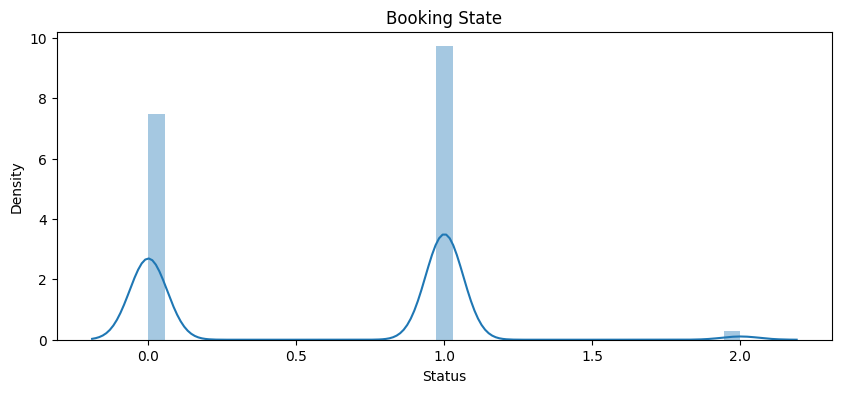

In [117]:
y_target = canc_score_ds['Status']
plt.figure(figsize= (10,4))
sns.distplot(y_target)
plt.title("Booking State")
plt.show()

We want to explore the relation between the target variable and the features. We see from the plot distribution are confirmed and once booked a modification is a rare event.

In [118]:
import plotly.express as px

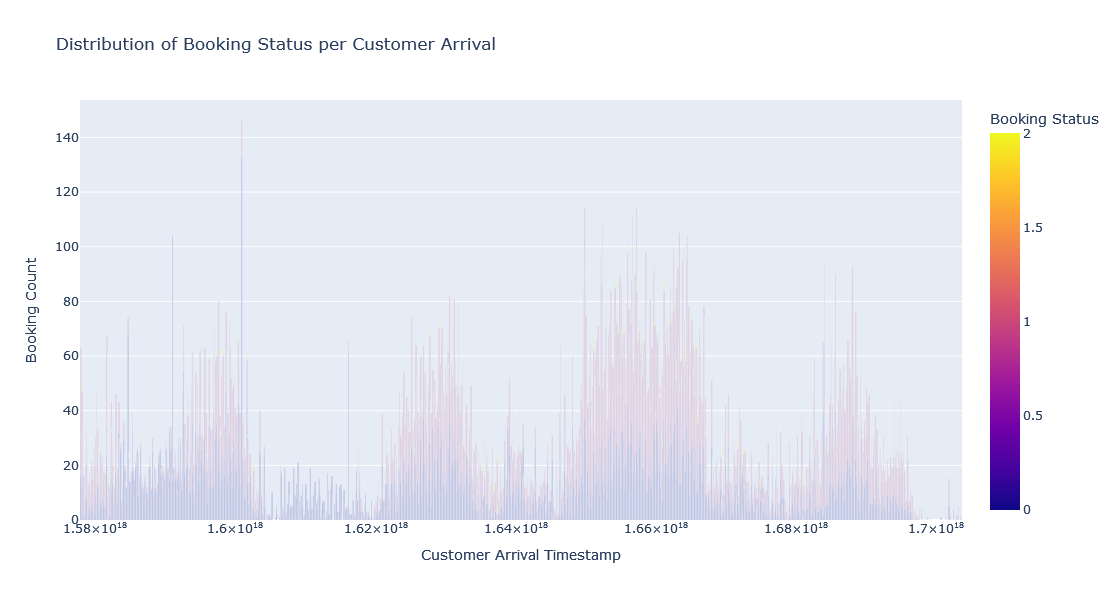

In [119]:
grouped_data = canc_score_ds.groupby(['Arrival_Timestamp', 'Status']).size().reset_index(name='Count')
fig = px.bar(grouped_data, x="Arrival_Timestamp", y="Count", color="Status", width=800, height=600,
             labels={"Arrival_Timestamp": "Customer Arrival Timestamp", "Count": "Booking Count", "Status": "Booking Status"},
             title="Distribution of Booking Status per Customer Arrival")
fig.show()

It is interesting to see that there some gaps in the arrival due to the periodic behaviour of the bookings and most of the arrival are confirmed.

Now we want to see the cancellation status and its relationship with the city. It is interesting to see that in Rome all reservation has been confirmed.

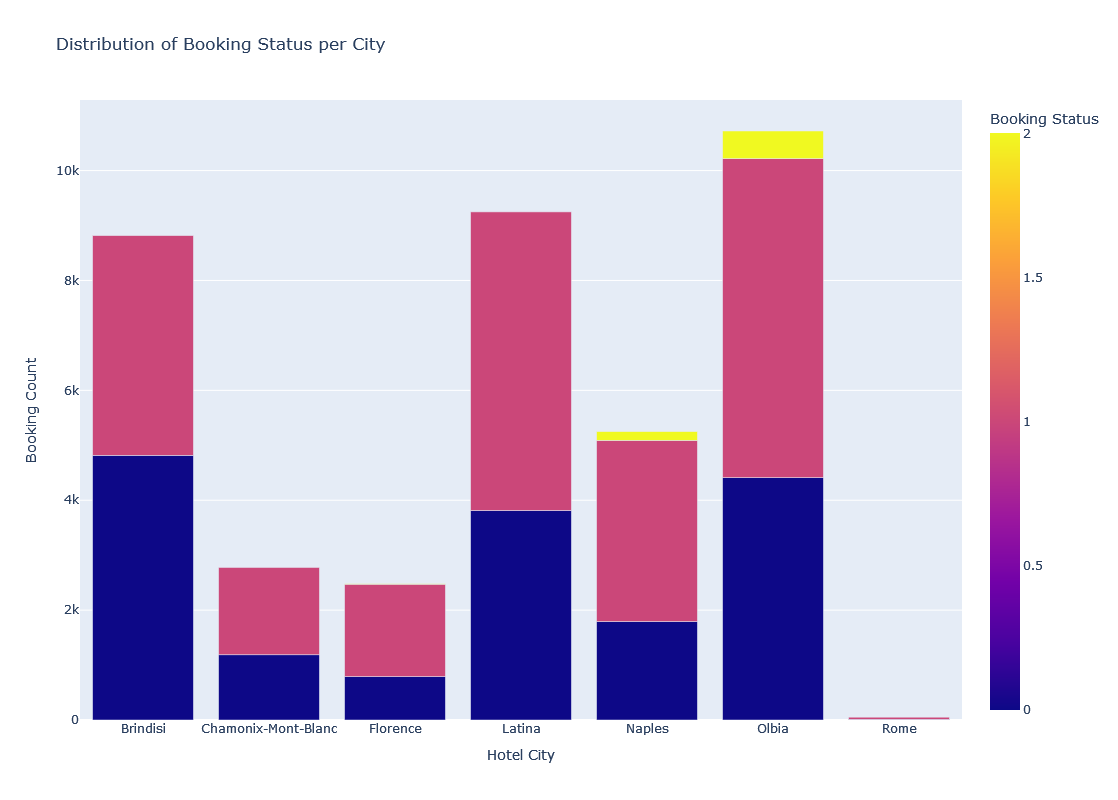

In [120]:

import plotly.express as px
grouped_data = canc_score_ds.groupby(['City', 'Status']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="City", y="Count", color="Status", width=800, height=800,
             labels={"City": "Hotel City", "Count": "Booking Count", "Status": "Booking Status"},
             title="Distribution of Booking Status per City")
fig.show()


Which is the relationship between status and nights?

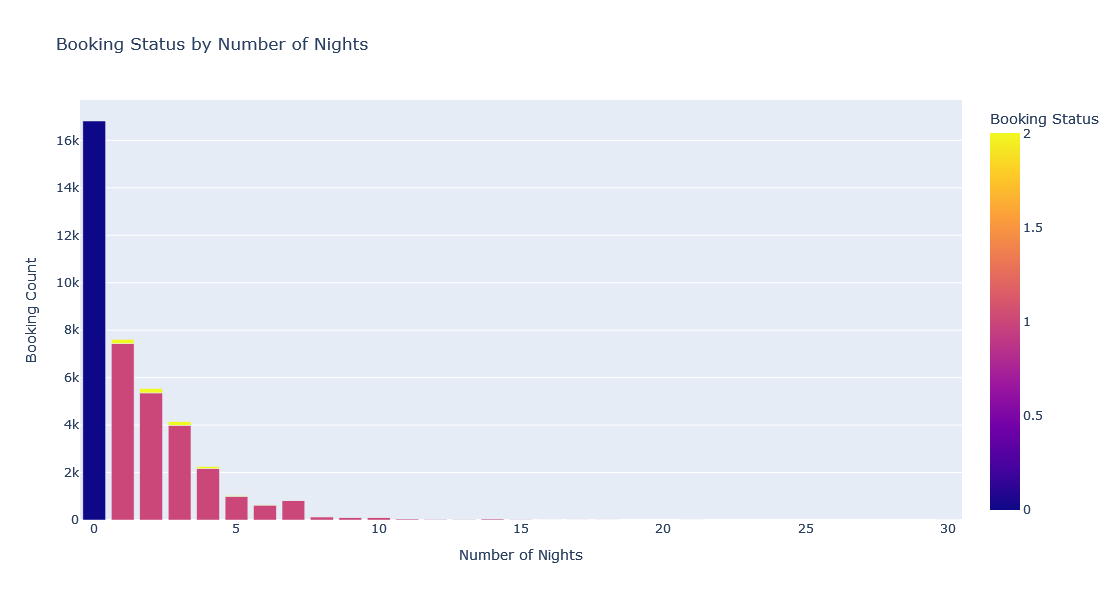

In [121]:
import plotly.express as px
grouped_data = canc_score_ds.groupby(['Nights', 'Status']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="Nights", y="Count", color="Status", width=800, height=600,
             labels={"Nights": "Number of Nights", "Count": "Booking Count", "Status": "Booking Status"},
             title="Booking Status by Number of Nights")
fig.show()

As expected all cancelled have 0 night most of the night of arrival range beteen 1 (most of the confirmed), some moodification or variation of
the booking status appears with customers that have 1 or 2  night, over 5 nights is rare any change of state. Now we would like to know which is the Status relationship and cancellation rate.

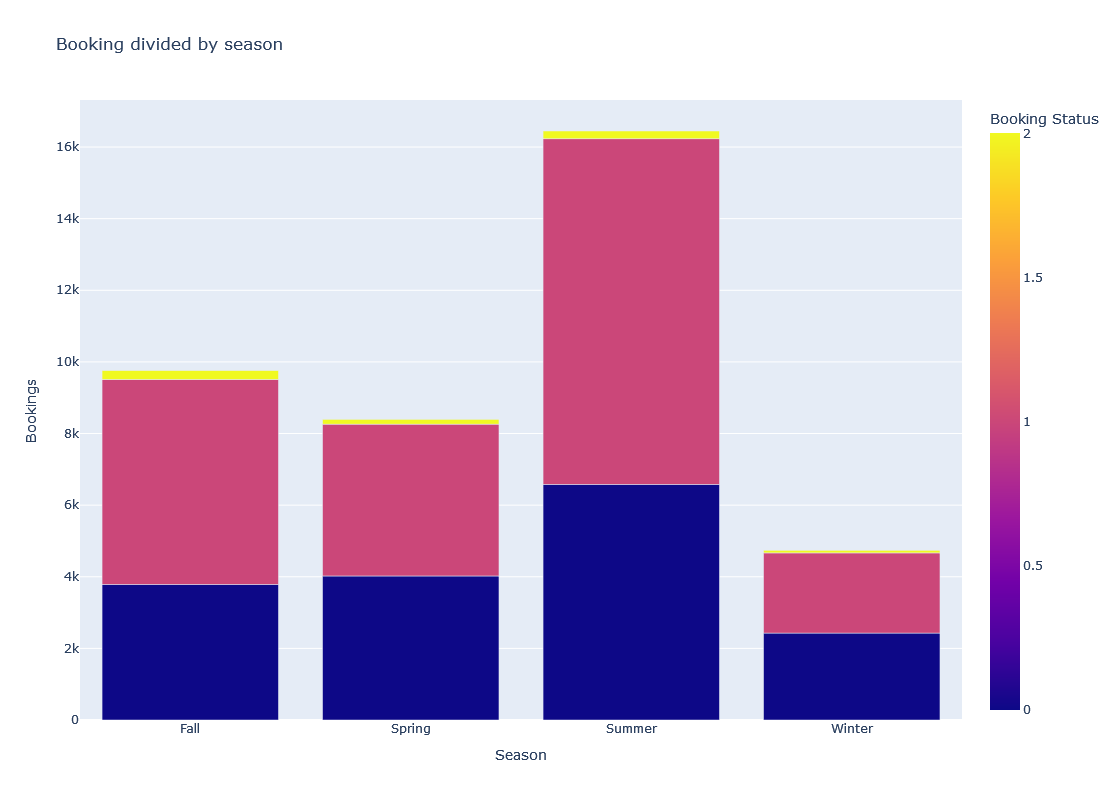

In [122]:
import plotly.express as px
canc_score_ds.head()

grouped_data = canc_score_ds.groupby(['Status', 'Season']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="Season", y="Count", color="Status", width=800, height=800,
             labels={"Seasson": "Season", "Count": "Bookings", "Status": "Booking Status"},#
             title="Booking divided by season")
fig.show()

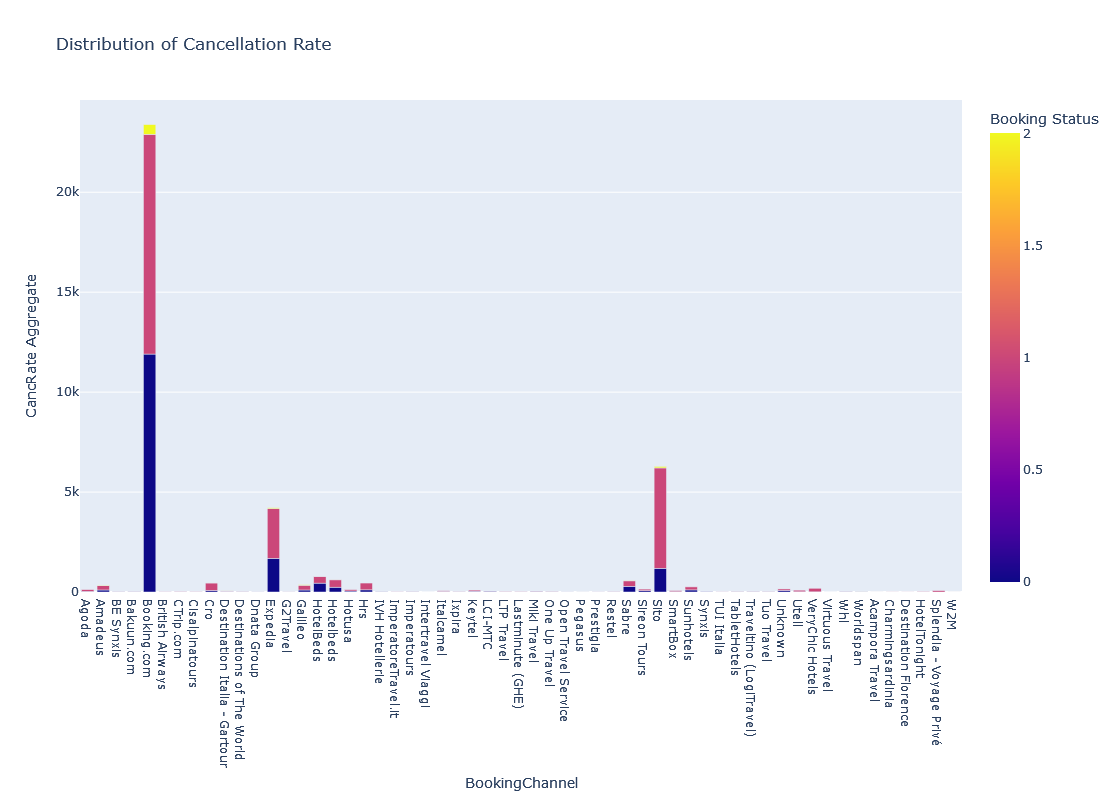

In [123]:

import plotly.express as px
grouped_data = canc_score_ds.groupby(['Status', 'BookingChannel']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="BookingChannel", y="Count", color="Status", width=800, height=800,
             labels={"CancRate": "Hotel Cancellation Rate", "Count": "CancRate Aggregate", "Status": "Booking Status"},
             title="Distribution of Cancellation Rate")
fig.show()

In [124]:
y_target.describe()

count    39340.000000
mean         0.589553
std          0.525452
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Status, dtype: float64

In [125]:
y_target.skew()

-0.00920501598476923

In [126]:
y_target.kurtosis()

-1.2301543501340326

The target variable is slightly skewed with tenedency to the booking confirmation. The dataset has negative kurtosis. we will need to investigate outliners.


### Cancellation Score: Numerical Feature Distribution.
Understanding feature distribution is important because models works well normalization and normalization had the tendency to 'squash' the tail of the distribution.

<Figure size 1200x900 with 0 Axes>

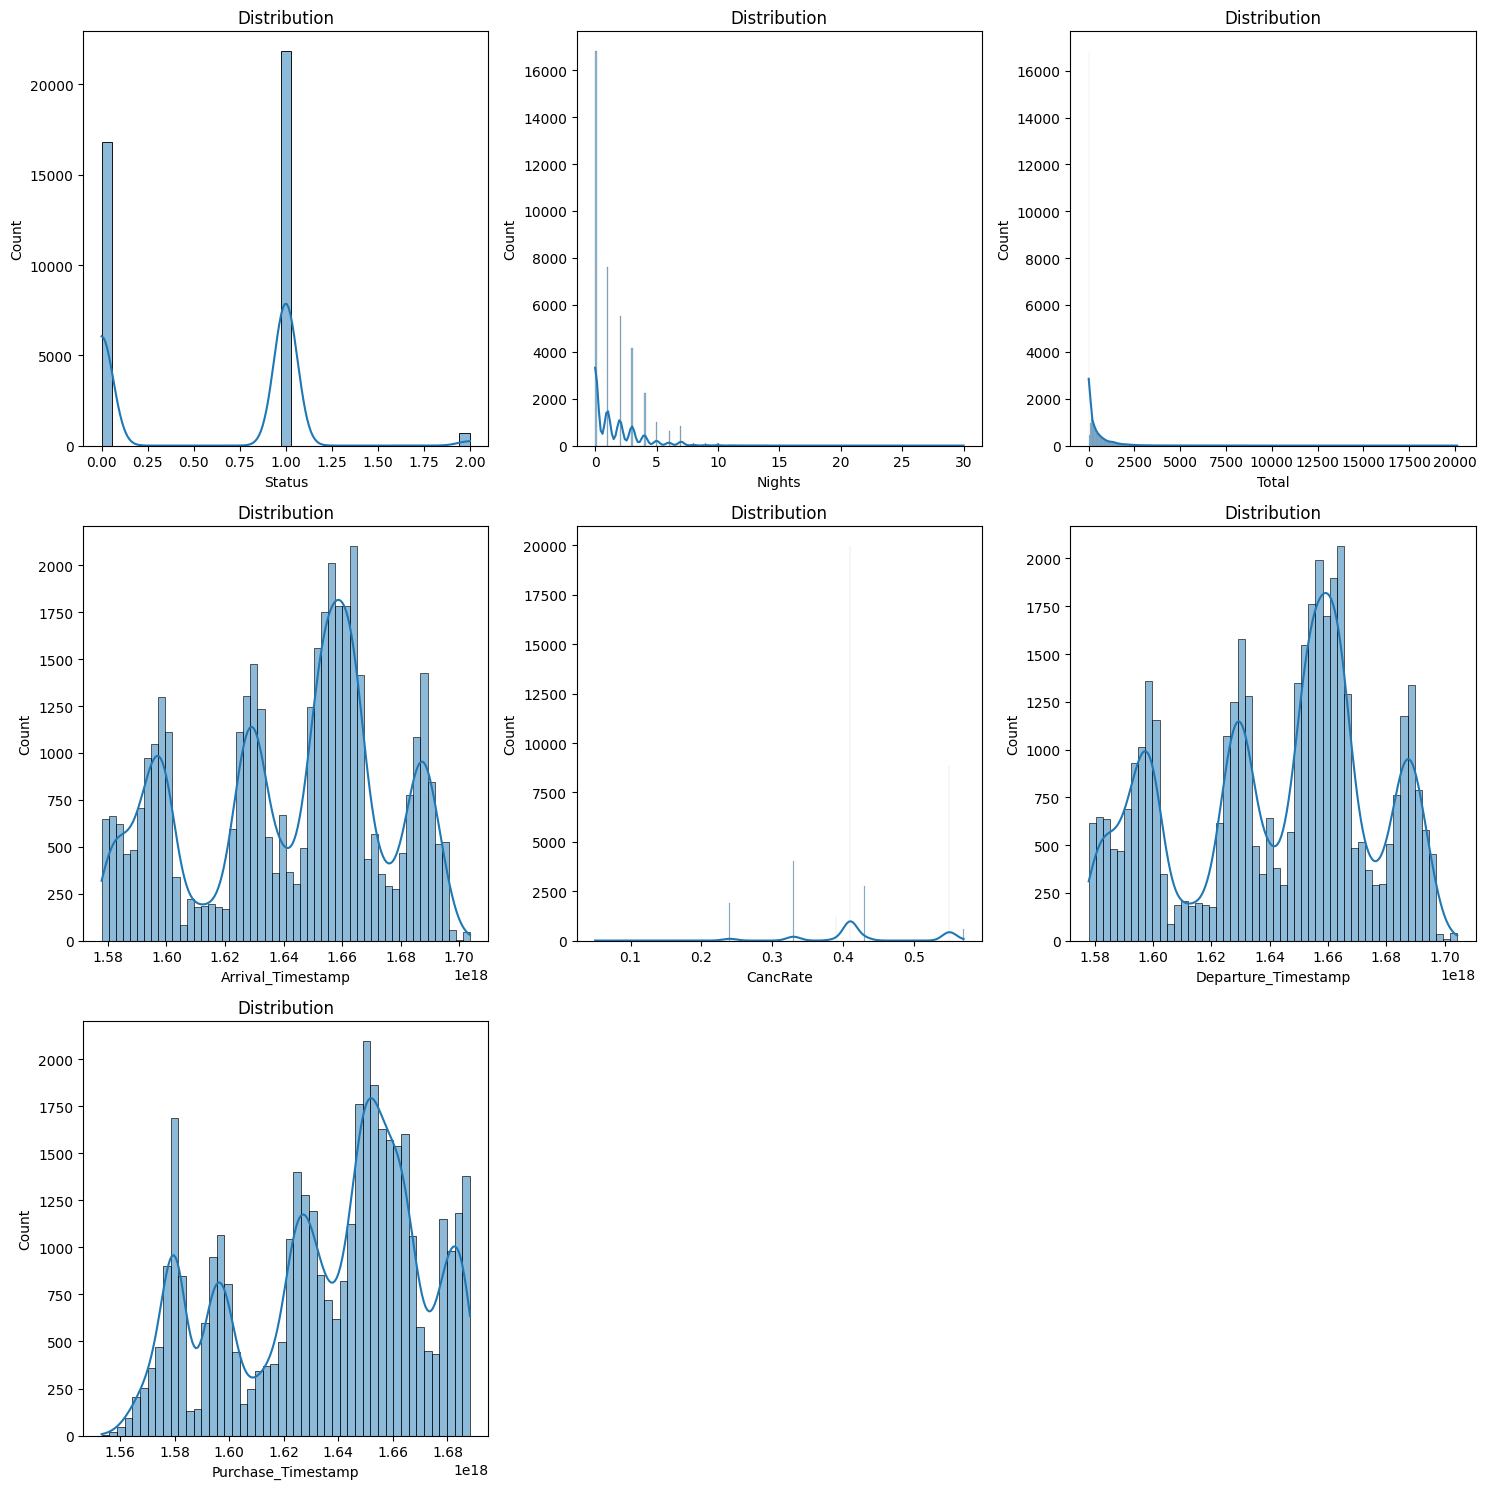

In [127]:
# Visualize the distribution of10 each feature
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(12, 9))
features = numerical_features


# Create a histogram for each feature
num_features = len(features.columns)
num_cols = 3  # Number of columns for subplots
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed

plt.figure(figsize=(15, num_rows * 5))  # Adjust the figure size

for i, feature in enumerate(features.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(data=features, x=feature, kde=True)
    plt.title(f'Distribution')

plt.tight_layout()
plt.show()

All the date in function of the bookings has a binomial cyclic behavior when there is demand, the behaviour is binomial, and it is independent from the
cities. There is a gap of data from the Hotel in Rome. Generally most of the confirmed reservations are in Summer.

### Encoding Categorical Features.

We have a given number of categorical features, that we want to encode. Some models and neural networks handle just numbers.

In [128]:
canc_score_ds

Status BookingChannel  Nights    Total HotelId    Arrival_Timestamp  \
0         1.0    Booking.com       7  4637.25     006  1703721600000000000   
1         1.0    Booking.com       7  3892.05     006  1703635200000000000   
2         1.0    Booking.com       7  2766.15     006  1703548800000000000   
3         1.0    Booking.com       7  2620.35     006  1703548800000000000   
4         1.0    Booking.com       8  2997.00     006  1703289600000000000   
...       ...            ...     ...      ...     ...                  ...   
39335     1.0           Sito      14  1108.40     001  1592006400000000000   
39336     1.0           Sito      14  1013.97     001  1592006400000000000   
39337     0.0      Hotelbeds       0     0.00     001  1590710400000000000   
39338     0.0      Hotelbeds       0     0.00     001  1590278400000000000   
39339     1.0        Expedia       2   128.72     001  1590192000000000000   

       CancRate  Departure_Timestamp   Purchase_Timestamp      City  Season  
0          0.55  1704326400000000000  1685836800000000000  Brindisi  Winter  
1          0.55  1704240000000000000  1686960000000000000  Brindisi  Winter  
2          0.55  1704153600000000000  1688256000000000000  Brindisi  Winter  
3          0.55  1704153600000000000  1686441600000000000  Brindisi  Winter  
4          0.55  1703980800000000000  1685232000000000000  Brindisi  Winter  
...         ...                  ...                  ...       ...     ...  
39335      0.34  1593216000000000000  1580169600000000000      Rome  Summer  
39336      0.34  1593216000000000000  1580169600000000000      Rome  Summer  
39337      0.34  1591056000000000000  1590451200000000000      Rome  Spring  
39338      0.34  1590883200000000000  1579219200000000000      Rome  Spring  
39339      0.34  1590364800000000000  1590192000000000000      Rome  Spring  

[39340 rows x 11 columns]

In [129]:
canc_score_ds['Status'].value_counts()

1.0    21851
0.0    16818
2.0      671
Name: Status, dtype: int64

We have 16818 cancellations, 21851  confirmations and only 671 modification. The dataset is unbalanced as we might expect in real world in this business scenario. The dataset is unbalanced and we are going to use Random Forest. The plan is to balance the dataset with SMOTE and then doing the PCA to reduce the dimensionality. Before we need to encode categorical values.

In [130]:
canc_score_ds

Status BookingChannel  Nights    Total HotelId    Arrival_Timestamp  \
0         1.0    Booking.com       7  4637.25     006  1703721600000000000   
1         1.0    Booking.com       7  3892.05     006  1703635200000000000   
2         1.0    Booking.com       7  2766.15     006  1703548800000000000   
3         1.0    Booking.com       7  2620.35     006  1703548800000000000   
4         1.0    Booking.com       8  2997.00     006  1703289600000000000   
...       ...            ...     ...      ...     ...                  ...   
39335     1.0           Sito      14  1108.40     001  1592006400000000000   
39336     1.0           Sito      14  1013.97     001  1592006400000000000   
39337     0.0      Hotelbeds       0     0.00     001  1590710400000000000   
39338     0.0      Hotelbeds       0     0.00     001  1590278400000000000   
39339     1.0        Expedia       2   128.72     001  1590192000000000000   

       CancRate  Departure_Timestamp   Purchase_Timestamp      City  Season  
0          0.55  1704326400000000000  1685836800000000000  Brindisi  Winter  
1          0.55  1704240000000000000  1686960000000000000  Brindisi  Winter  
2          0.55  1704153600000000000  1688256000000000000  Brindisi  Winter  
3          0.55  1704153600000000000  1686441600000000000  Brindisi  Winter  
4          0.55  1703980800000000000  1685232000000000000  Brindisi  Winter  
...         ...                  ...                  ...       ...     ...  
39335      0.34  1593216000000000000  1580169600000000000      Rome  Summer  
39336      0.34  1593216000000000000  1580169600000000000      Rome  Summer  
39337      0.34  1591056000000000000  1590451200000000000      Rome  Spring  
39338      0.34  1590883200000000000  1579219200000000000      Rome  Spring  
39339      0.34  1590364800000000000  1590192000000000000      Rome  Spring  

[39340 rows x 11 columns]

### Dummy Encoding.

In [131]:
canc_score_ds = pd.concat([canc_score_ds, pd.get_dummies(canc_score_ds[["City"]])], axis=1)
canc_score_ds = canc_score_ds.drop(labels=["City"], axis=1)
canc_score_ds.reset_index()
canc_score_ds

Status BookingChannel  Nights    Total HotelId    Arrival_Timestamp  \
0         1.0    Booking.com       7  4637.25     006  1703721600000000000   
1         1.0    Booking.com       7  3892.05     006  1703635200000000000   
2         1.0    Booking.com       7  2766.15     006  1703548800000000000   
3         1.0    Booking.com       7  2620.35     006  1703548800000000000   
4         1.0    Booking.com       8  2997.00     006  1703289600000000000   
...       ...            ...     ...      ...     ...                  ...   
39335     1.0           Sito      14  1108.40     001  1592006400000000000   
39336     1.0           Sito      14  1013.97     001  1592006400000000000   
39337     0.0      Hotelbeds       0     0.00     001  1590710400000000000   
39338     0.0      Hotelbeds       0     0.00     001  1590278400000000000   
39339     1.0        Expedia       2   128.72     001  1590192000000000000   

       CancRate  Departure_Timestamp   Purchase_Timestamp  Season  \
0          0.55  1704326400000000000  1685836800000000000  Winter   
1          0.55  1704240000000000000  1686960000000000000  Winter   
2          0.55  1704153600000000000  1688256000000000000  Winter   
3          0.55  1704153600000000000  1686441600000000000  Winter   
4          0.55  1703980800000000000  1685232000000000000  Winter   
...         ...                  ...                  ...     ...   
39335      0.34  1593216000000000000  1580169600000000000  Summer   
39336      0.34  1593216000000000000  1580169600000000000  Summer   
39337      0.34  1591056000000000000  1590451200000000000  Spring   
39338      0.34  1590883200000000000  1579219200000000000  Spring   
39339      0.34  1590364800000000000  1590192000000000000  Spring   

       City_Brindisi  City_Chamonix-Mont-Blanc  City_Florence  City_Latina  \
0                  1                         0              0            0   
1                  1                         0              0            0   
2                  1                         0              0            0   
3                  1                         0              0            0   
4                  1                         0              0            0   
...              ...                       ...            ...          ...   
39335              0                         0              0            0   
39336              0                         0              0            0   
39337              0                         0              0            0   
39338              0                         0              0            0   
39339              0                         0              0            0   

       City_Naples  City_Olbia  City_Rome  
0                0           0          0  
1                0           0          0  
2                0           0          0  
3                0           0          0  
4                0           0          0  
...            ...         ...        ...  
39335            0           0          1  
39336            0           0          1  
39337            0           0          1  
39338            0           0          1  
39339            0           0          1  

[39340 rows x 17 columns]

### Label Category Encoding in Python.

We could used use scite-learn LabelCategory, but it is ok. So we have more control.

In [132]:
channel_names = set(canc_score_ds['BookingChannel'].to_list())
season_names = set(canc_score_ds['Season'].to_list())
hotel_ids = set(canc_score_ds['HotelId'].to_list())
channel_mapper = {}
season_mapper = {}
hotel_id_mapper = {}
for code, name in enumerate(channel_names):
    if name not in channel_mapper:
        channel_mapper[name] = code
for code, season in enumerate(season_names):
    if season not in season_mapper:
        season_mapper[season] = code
for hid, hotelid in enumerate(hotel_ids):
    if hotelid not in hotel_id_mapper:
        hotel_id_mapper[hotelid] = hid
canc_score_ds['SeasonNumeric'] = canc_score_ds['Season'].map(season_mapper)
canc_score_ds['ChannelNumeric'] = canc_score_ds['BookingChannel'].map(channel_mapper)
canc_score_ds['HotelIdNumeric'] = canc_score_ds['HotelId'].map(hotel_id_mapper)
canc_score_ds.drop(labels=['BookingChannel','Season','HotelId'], axis=1, inplace=True)
print(f"Mappings For Hotel Id {hotel_id_mapper}\n")
print(f"Mappings For C {channel_mapper}")
print(f"Mappings {season_mapper}")

Mappings For Hotel Id {'004': 0, '007': 1, '001': 2, '002': 3, '009': 4, '010': 5, '003': 6, '006': 7, '008': 8, '005': 9}

Mappings For C {'Hrs': 0, 'Sunhotels': 1, 'Cro': 2, 'Miki Travel': 3, 'G2Travel': 4, 'Unknown': 5, 'Sito': 6, 'Whl': 7, 'Destination Florence': 8, 'W2M': 9, 'Splendia - Voyage Privé': 10, 'Traveltino (LogiTravel)': 11, 'CTrip.com': 12, 'TUI Italia': 13, 'Tuo Travel': 14, 'Open Travel Service': 15, 'Pegasus': 16, 'Prestigia': 17, 'SmartBox': 18, 'Charmingsardinia': 19, 'Hotusa': 20, 'Italcamel': 21, 'British Airways': 22, 'Ixpira': 23, 'HotelBeds': 24, 'Hotelbeds': 25, 'VeryChic Hotels': 26, 'Utell': 27, 'Agoda': 28, 'Sabre': 29, 'Keytel': 30, 'TabletHotels': 31, 'Bakuun.com': 32, 'BE Synxis': 33, 'HotelTonight': 34, 'Virtuous Travel': 35, 'Booking.com': 36, 'Restel': 37, 'Intertravel Viaggi': 38, 'One Up Travel': 39, 'ImperatoreTravel.it': 40, 'Destination Italia - Gartour': 41, 'Imperatours': 42, 'LTP Travel': 43, 'Lastminute (GHE)': 44, 'Synxis': 45, 'IVH Hotell

Now we've all variables categorical and we can try investigate about feature selection.

In [133]:
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

In [134]:
canc_score_X = canc_score_ds.drop(columns=['Status'])
canc_score_Y = canc_score_ds[['Status']]
num_cols = len(canc_score_X.columns)
print(f"Number of dependent variables {num_cols}")

Number of dependent variables 16


At this point we want to investigate if we can reduce the number of features, later we'll use PCA for that.

In [135]:
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(canc_score_X), 8))
X_w_noise = np.hstack([canc_score_X, noise])
# the first features are from the data set the rest 8 are noise
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, canc_score_Y, random_state=0,test_size=.5)
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
print("Number of original features: {}".format(X_train.shape))
print("Number of selected feaures: {}".format(X_train_selected.shape))


Number of original features: (19670, 24)
Number of selected feaures: (19670, 12)


We've reduced the features this indicate there is redundancy, as method per dimensionality reduction that fits better with Random Forest we prefere PCA since we believe that we can obtain more.

## Outliers detection.

Outliers are data points that significantly deviate from the majority of the data. They can be caused by errors, anomalies, or simply rare events. Outlies can lead to overfitting. Outliers may lead to overfitting if the model tries to fit them perfectly, thus capturing their noise rather than the actual patterns in the data. We decided to replace outliers with the mean. For detecting outliners in classification problem we use Isolation Forest.
### Isolation Forest 
The algoritm builds a random forest in which each decision tree is grown randomly: at each node, it pickes a feature randomly, the it picks a random threasold value to split the dataset in two. This process is repeated until all instances are isolated. Anomalies are usually far from other instances, so on average they tend to get isolated in fewer steps then normal instances. Once we've indentified the outliners we select and drop them. It's not the best approach since we risk underfit doing but the number is not meaniful in our case, we can drop. Alternative strategy could be repleace with the mean.


In [136]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
features = canc_score_ds.drop(columns=['Status'])
sca = StandardScaler()
X_train = sca.fit_transform(features)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
canc_score_ds['outlier'] = iso_forest.fit_predict(X_train)
outliers = canc_score_ds[canc_score_ds['outlier'] == -1]
inliers = canc_score_ds[canc_score_ds['outlier'] == 1]
# Display the number of outliers detected
print(f"Number of outliers detected: {len(outliers)}")


Number of outliers detected: 3934


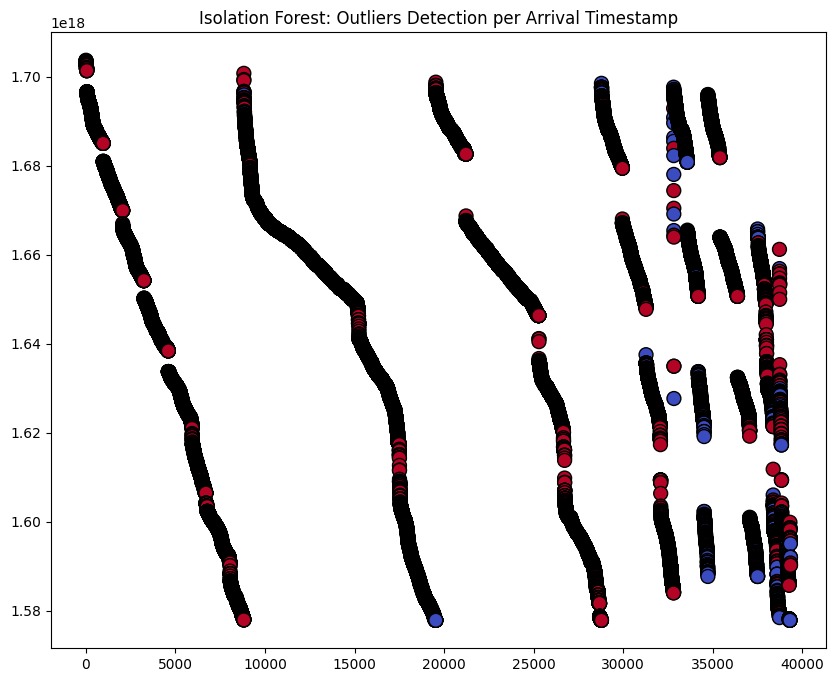

In [137]:
# Plot the inliers and outliers
plt.figure(figsize=(10, 8))
plt.scatter(canc_score_ds.index, canc_score_ds['Arrival_Timestamp'], c=canc_score_ds['outlier'], cmap='coolwarm', edgecolor='k', s=100)
plt.title('Isolation Forest: Outliers Detection per Arrival Timestamp')
plt.show()


In [138]:
canc_score_ds.count()

Status                      39340
Nights                      39340
Total                       39340
Arrival_Timestamp           39340
CancRate                    39340
Departure_Timestamp         39340
Purchase_Timestamp          39340
City_Brindisi               39340
City_Chamonix-Mont-Blanc    39340
City_Florence               39340
City_Latina                 39340
City_Naples                 39340
City_Olbia                  39340
City_Rome                   39340
SeasonNumeric               39340
ChannelNumeric              39340
HotelIdNumeric              39340
outlier                     39340
dtype: int64

We decide to remove and drop the outliers instead of replacing with the median. We lose only 10% of infromation on more than 40000 bookings.

In [139]:
canc_score_ds = canc_score_ds.drop(columns=['outlier'])
canc_score_ds.count()


Status                      39340
Nights                      39340
Total                       39340
Arrival_Timestamp           39340
CancRate                    39340
Departure_Timestamp         39340
Purchase_Timestamp          39340
City_Brindisi               39340
City_Chamonix-Mont-Blanc    39340
City_Florence               39340
City_Latina                 39340
City_Naples                 39340
City_Olbia                  39340
City_Rome                   39340
SeasonNumeric               39340
ChannelNumeric              39340
HotelIdNumeric              39340
dtype: int64

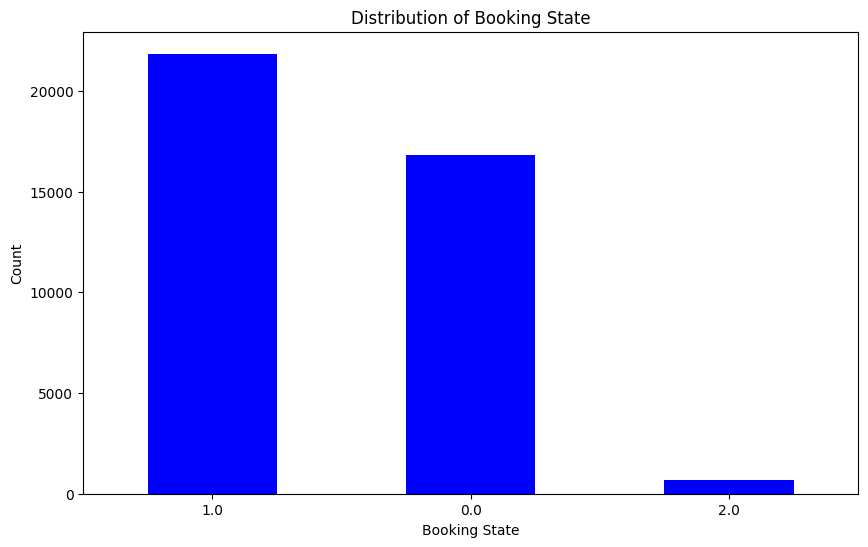

In [140]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
type_counts = canc_score_ds['Status'].value_counts()
type_counts.plot(kind='bar', color='blue', fig=(10,6))
plt.title('Distribution of Booking State')
plt.xlabel('Booking State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



As one can imagine the booking status has three classes heavily unbalanced. We are going to balance them.


### SMOTE: Oversampling to rebalance classes

We're going to rebalance the classes before training, some algorithm are not sensible and maybe SMOTE is too much, just manual sampling but 
we prefer a safe tested method.

In [141]:
!pip install imbalanced-learn

In [142]:
from imblearn.over_sampling import SMOTE
X = canc_score_ds.drop(columns=['Status'])
y = canc_score_ds['Status']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
canc_score_ds = pd.DataFrame(X_resampled, columns=X.columns)
canc_score_ds['Status'] = y_resampled

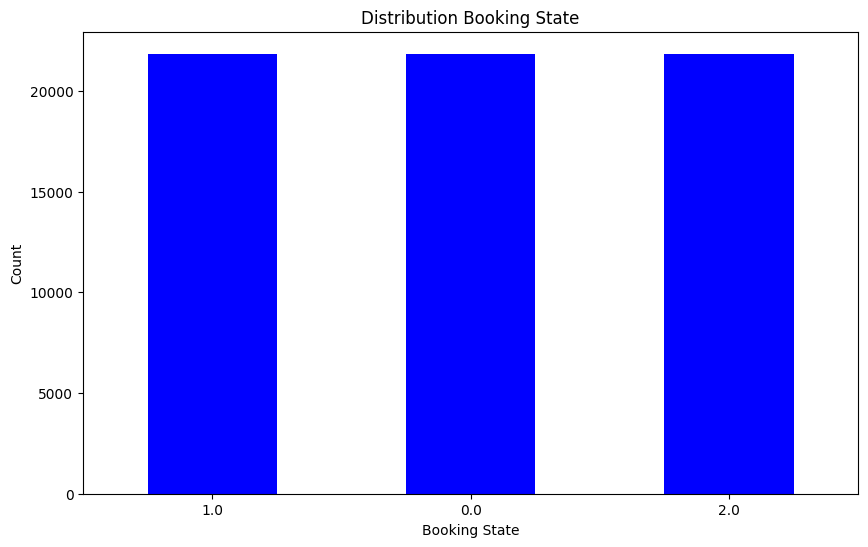

In [143]:
plt.figure(figsize=(10,6))
type_counts = canc_score_ds['Status'].value_counts()
type_counts.plot(kind='bar', color='blue')
plt.title('Distribution Booking State')
plt.xlabel('Booking State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Feature and Model Selection

### Correlation.
- We will the following correlation metrics:
- Standard Correlation to understand linear correlation.
- Predictive Power Score to understand non-linear correlation.

In [144]:
!pip install ppscore

In [145]:
import ppscore as pps
corr_matrix = canc_score_ds.corr()
pps_matrix = pps.matrix(canc_score_ds)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

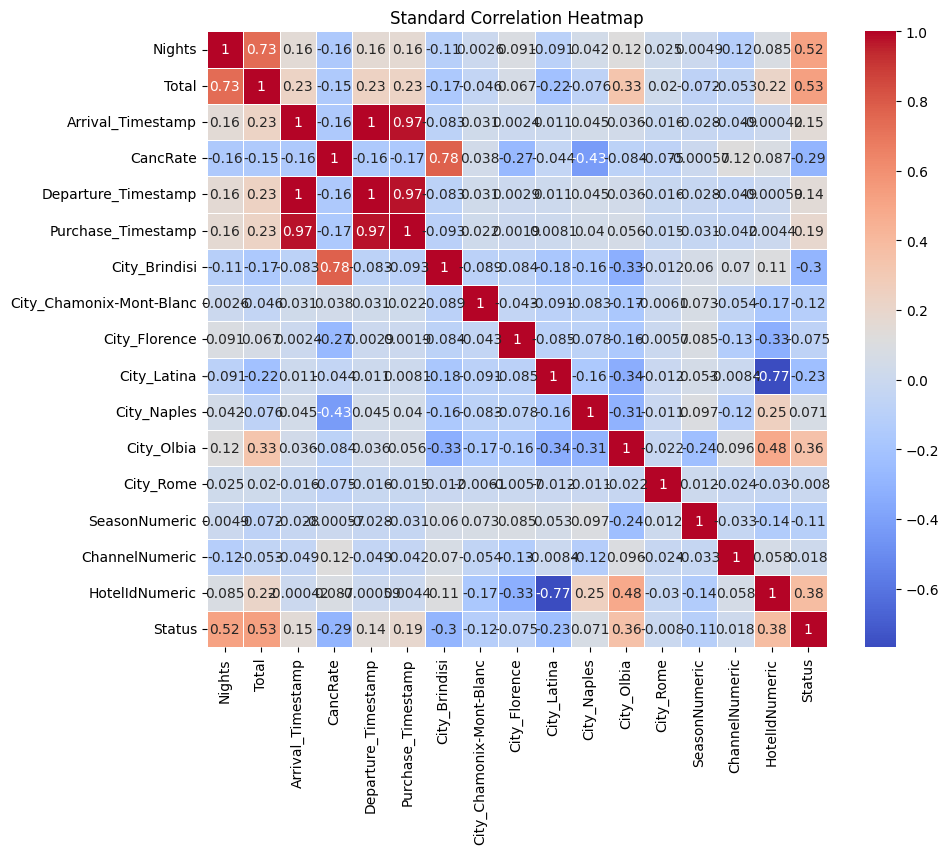

In [146]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Standard Correlation Heatmap')
plt.show()

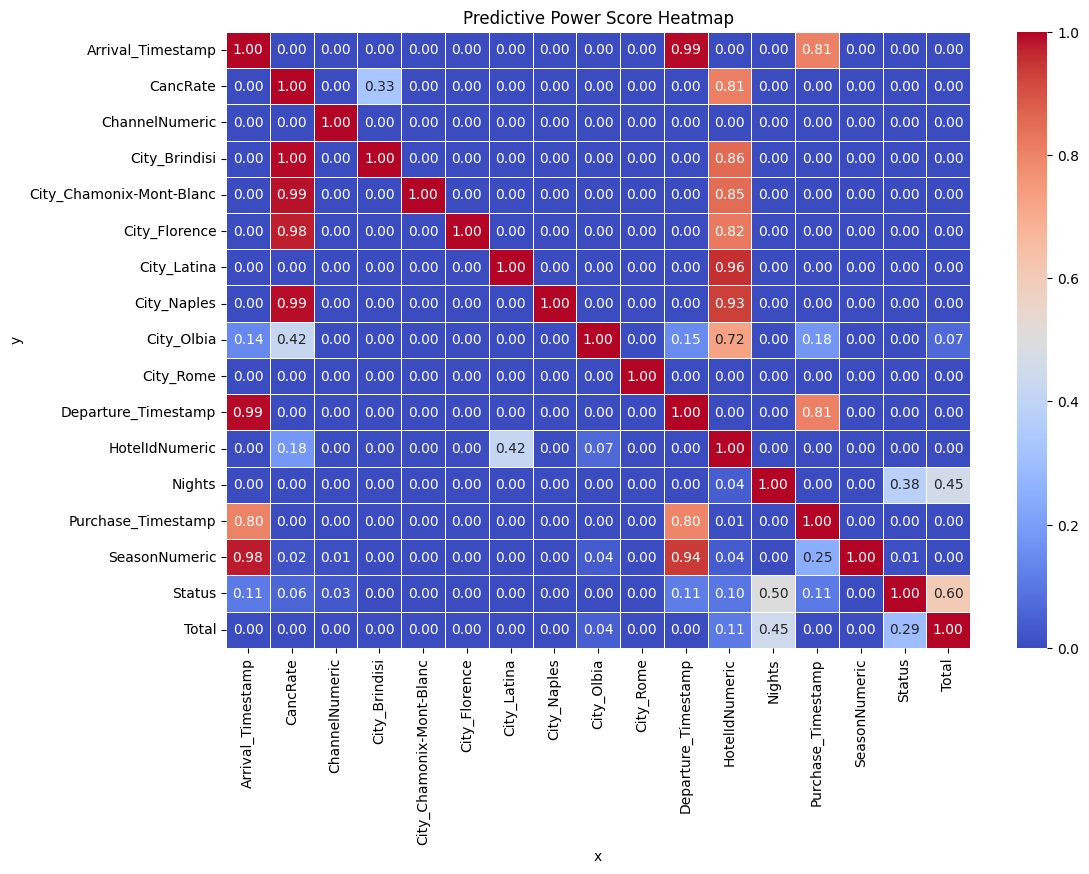

In [147]:
import seaborn as sns
pps_matrix.head()
plt.figure(figsize=(12, 8))
sns.heatmap(pps_matrix, vmin=0, vmax=1, cmap="coolwarm",fmt='.2f',linewidths=0.5, annot=True)
plt.title('Predictive Power Score Heatmap')
plt.show()

The interesting things a weak correlation with the season and with the city and our target. The city and the hotel are not such important. Let see if change with balancing the dataset. Total is the total revenue and it is obviously strongly correlated. 
Now we split and scale the training data.

In [148]:
X_features = canc_score_ds.drop(columns=['Status'])
y_target = canc_score_ds['Status']
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                        test_size=0.3, random_state=42)

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_features.shape

(65553, 16)

In [150]:
X_features.columns

Index(['Nights', 'Total', 'Arrival_Timestamp', 'CancRate',
       'Departure_Timestamp', 'Purchase_Timestamp', 'City_Brindisi',
       'City_Chamonix-Mont-Blanc', 'City_Florence', 'City_Latina',
       'City_Naples', 'City_Olbia', 'City_Rome', 'SeasonNumeric',
       'ChannelNumeric', 'HotelIdNumeric'],
      dtype='object')

We want to reduce the dimensionality of the dataset but in appropriate way choosing the appropriate number of dimesion to up a given expected_variance_ratio for each princial component,let's say 95 per cent. So we split the data set, doing the fit and get the appropriate dimensions. Actually we were able to reduce 10 features from 16.

### Scaling Features

PCA and other algorithm requires the are scaling, they might behave badly if the individual features do not more or less look like standard normally distributed.

In [151]:
sca = StandardScaler()
X_train = sca.fit_transform(X_train)
X_test = sca.fit_transform(X_test)

### Principal Component Analysis

In [152]:
# project the model on two dimension in order to be able to visualize it.
# split the training set in two
from sklearn.decomposition import PCA
n_cols = X_train.shape[1]
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
X_reduced_test = pca.fit_transform(X_test)
print("Dimensionality reduce from {} to {}".format(n_cols,pca.n_components_))

Dimensionality reduce from 16 to 10


From now we always work with 10 components.

## Model 3: Random Forest

### Baseline Model

For each classification algorithms we'll use cross-validation to ensure prediction robustness. As first algorithm we use Random Forest. Random Forest is an ensamble of decision trees generally trained via a [bagging method](https://www.ibm.com/topics/bagging). We us crossvalidation and w do prediction diectl. As baseline model we don't use the PCA.

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

skf = StratifiedKFold(n_splits=5)
base_line_model_clf = RandomForestClassifier(n_estimators=20, random_state=42)
base_line_model_clf = base_line_model_clf.fit(X_reduced, y_train)



In [154]:
base_line_cross = cross_val_score(base_line_model_clf, X_reduced_test, y_test, cv=skf, scoring="accuracy")
mean_accuracy = np.mean(base_line_cross).item()
print(f"Average accuracy : {mean_accuracy}")


Average accuracy : 0.9458966152810465


In [155]:
y_pred_rf = base_line_model_clf.predict(X_reduced_test)


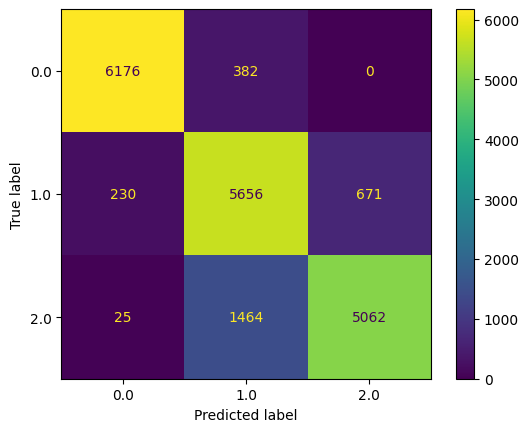

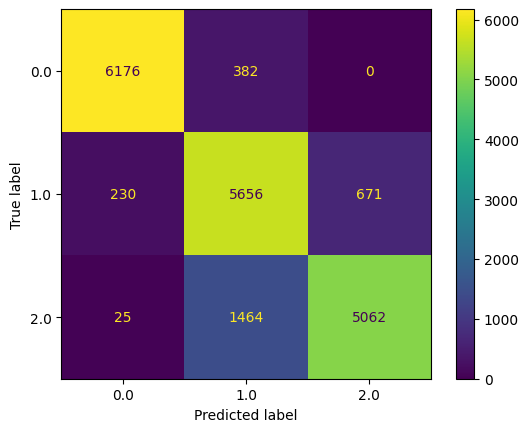

In [156]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
# Then just plot it:
disp.plot()
# And show it:
plt.show()

The image above is the confusion matrix expresses how good is the prediction. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class. The diagonal of the matrix therefore represents all instances that are correctly predicted.

In [157]:
from sklearn.metrics import classification_report
target_names = ['Cancelled', 'Confirmed', 'Modified']
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

   Cancelled       0.96      0.94      0.95      6558
   Confirmed       0.75      0.86      0.80      6557
    Modified       0.88      0.77      0.82      6551

    accuracy                           0.86     19666
   macro avg       0.87      0.86      0.86     19666
weighted avg       0.87      0.86      0.86     19666



Not a big result, we can do better.

### Random Forest Pipeline

In [158]:
!pip install iplantuml

We need to define a report dictionary where we collect all results to transform later in a data frame for visualization and compatison of 
the different methods

In [159]:
report_dict = {}

In [160]:
import iplantuml

Writing output for /home/jozoppi/capstone-project-feb-2024-pt-giorgiozoppi/3f2e0bab-fe8f-4560-b2b2-59f680c572cd.uml to 3f2e0bab-fe8f-4560-b2b2-59f680c572cd.svg


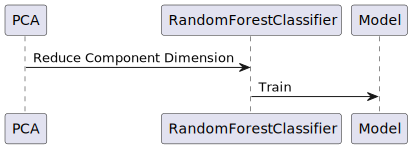

In [161]:
%%plantuml
@startuml
participant PCA
participant RandomForestClassifier
participant Model
PCA -> RandomForestClassifier : Reduce Component Dimension
RandomForestClassifier -> Model : Train
@enduml

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))
clf

Pipeline(steps=[('pca', PCA(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [163]:
clf.fit(X_reduced, y_train)

Pipeline(steps=[('pca', PCA(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

### Model Hyperparameter Tuning with Stratified K-Fold cross validation.

In [164]:
param_distrib = {
    "pca__n_components": np.arange(2, 15),
    "randomforestclassifier__n_estimators": np.arange(20, 100),
    "randomforestclassifier__max_depth": [3, 6, 10],
    "randomforestclassifier__criterion": ['gini', 'entropy'],
    "randomforestclassifier__max_features": ['sqrt', 'log2']}
rnd_search = RandomizedSearchCV(clf, param_distrib, cv=skf, random_state=42)
tuned_clf = rnd_search.fit(X_train, y_train)

In [165]:
print ("Paramters found: {}".format(rnd_search.best_params_))

Paramters found: {'randomforestclassifier__n_estimators': 64, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'gini', 'pca__n_components': 14}


Notice the sensitive variations on dimensions for PCA. The next step is to create a pipeline that it is able to cross-validate itself with PCA
and RandomForest.

In [166]:
y_pred_rf_tuned = tuned_clf.predict(X_test)

### Classification Report Tuned Random Forest

In [167]:
from sklearn.metrics import classification_report, accuracy_score
report = classification_report(y_test, y_pred_rf_tuned, output_dict=True)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))

Accuracy: 0.9297264314044544


In [168]:
report_df = pd.DataFrame(report).transpose()
report_df.drop(labels=['support'], axis=1, inplace=True)
report_df.drop(labels=['macro avg', 'weighted avg'], axis=0, inplace=True)
report_df

precision    recall  f1-score
0.0        0.997109  0.999390  0.998248
1.0        0.970717  0.813939  0.885442
2.0        0.841738  0.975882  0.903860
accuracy   0.929726  0.929726  0.929726

### Performance Confusion Matrix

A confusion matrix is an visual indicator that give us how good is the cllassification. In the case below 

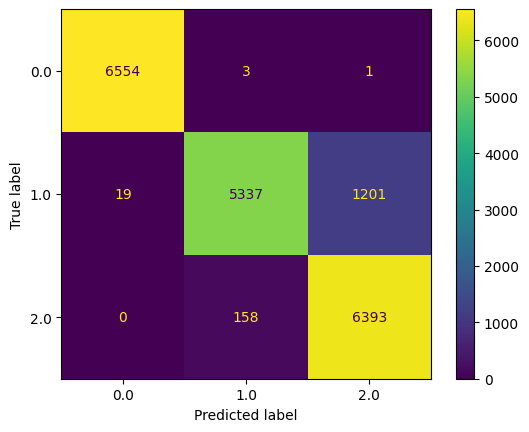

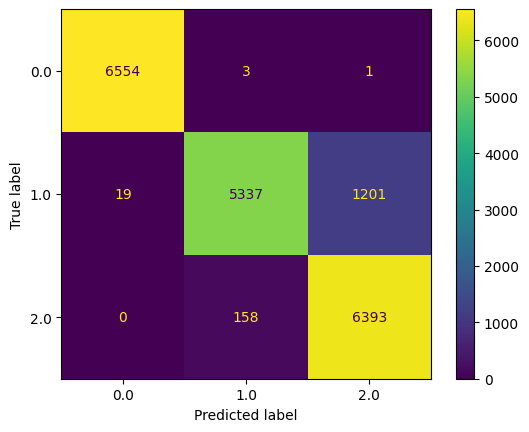

In [169]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tuned)
# Then just plot it:
disp.plot()
# And show it:
plt.show()

Just 90 per cent of matches. Let's crossvalidate to avoid overfitting Stratified KFold cross validation as parameter to the pipeline. Stratified crossvalidation mantains the class distribution during the splitting and reduce overfitting. The interesting part of this graphs is that the forecasting error of caclellation is good.


In [170]:
from sklearn.model_selection import StratifiedKFold
# For classificatoion problems like this mantains the original distribution
skf = StratifiedKFold(n_splits=5)
param_distrib = {
    "pca__n_components": np.arange(2, 15),
    "randomforestclassifier__n_estimators": np.arange(20, 100),
    "randomforestclassifier__max_depth": [3, 6, 10],
    "randomforestclassifier__criterion": ['gini', 'entropy'],
    "randomforestclassifier__max_features": ['sqrt', 'log2']}
# we prefer RanndomizedSarchCV becasue G
# 3 iterations should be enough
rnd_search = RandomizedSearchCV(clf, param_distrib, cv=skf, random_state=42,verbose=3)
tuned_clf_v2 = rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END pca__n_components=9, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=90;, score=0.755 total time=   3.5s
[CV 2/5] END pca__n_components=9, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=90;, score=0.769 total time=   3.5s
[CV 3/5] END pca__n_components=9, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=90;, score=0.759 total time=   3.5s
[CV 4/5] END pca__n_components=9, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=90;, score=0.767 total time=   3.5s
[CV 5/5] END pca__n

Let see now the numbers:

In [171]:
y_pred_rf_tuned_v2 = tuned_clf_v2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned_v2))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_tuned_v2))

Accuracy: 0.9297264314044544
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6558
         1.0       0.97      0.81      0.89      6557
         2.0       0.84      0.98      0.90      6551

    accuracy                           0.93     19666
   macro avg       0.94      0.93      0.93     19666
weighted avg       0.94      0.93      0.93     19666



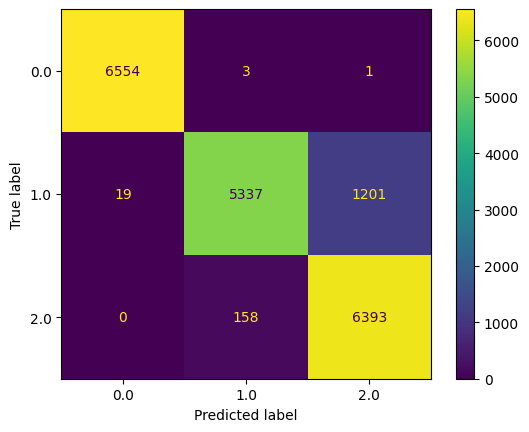

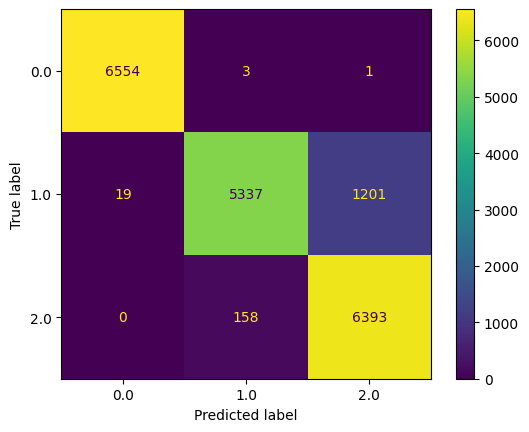

In [172]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tuned_v2)
# Then just plot it:
disp.plot()
# And show it:
plt.show()

## Model 4: Support Vector Machine


Support Vector Machine is an intersting model to try in this case because can perform linear and non linerar classification. The mental 
model of SVM is to project in a hyperplane the datapoints and find where those points are clearly separable.

### Baseline Model

As first we try with the simplest, we haven't done the inspection to check if the data are clearly separable, but in this use case looks so. If the model performs badly we simply discard it. For SVM we follow the guidelines placed at [A Practical Guide to Support Vector Classification](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf). Let me disgress a bit about SVM. SVM are classification method based on a minimization problem, each feature in the training set get represented by a vector that is mapped into a higher (maybe infinite) dimensional space
by a kernel function. SVM finds a the best separating hyperplane with the maximal margin in this higher dimensional space, that separates the training data in classes. There are different types of kernels:
- Linear Kernel: well for linearly separable data.
- Polynomial Kernel: Used to separate polynomial relationship between classes.
- Radial Basis Function (RBF) Kernel: Most of the non linear cases.
- Sigmoid Kernel: Uses the hypertang

Following the guidelines of the pratical guide to Support Vector we proceed:
- Transform data to the format of an SVM package
- Conduct simple scaling on the data
- Consider the RBF kernel.
- Use cross-validation to find the best parameter C and γ
- Use the best parameter C and γ to train the whole training set5
- Test

In [173]:
from sklearn.svm import SVC
svm_pipeline = make_pipeline(PCA(random_state=42), SVC(kernel='rbf'))
cv_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=skf, scoring='accuracy')
mean = np.mean(cv_scores)
print(f"Accuracy {mean}")

Accuracy 0.9121319671030875


Not really great compared.

In [174]:
svm_pipeline

Pipeline(steps=[('pca', PCA(random_state=42)), ('svc', SVC())])

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 10, 100],
              'svc__kernel': ['rbf'],
              "pca__n_components": [10],
              'svc__gamma': [1, 0.1]}
# Set up the GridSearchCV object
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=skf,verbose=5)
tuned_svm_model = grid_search.fit(X_train, y_train)
y_svm_pred_tuned = tuned_svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_svm_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_svm_pred_tuned))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END pca__n_components=10, svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.936 total time=  18.9s
[CV 2/5] END pca__n_components=10, svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.934 total time=  19.3s
[CV 3/5] END pca__n_components=10, svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.935 total time=  17.2s
[CV 4/5] END pca__n_components=10, svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.934 total time=  17.6s
[CV 5/5] END pca__n_components=10, svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.935 total time=  18.8s
[CV 1/5] END pca__n_components=10, svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=0.907 total time=  12.0s
[CV 2/5] END pca__n_components=10, svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=0.909 total time=  12.5s
[CV 3/5] END pca__n_components=10, svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=0.906 total time=  11.8s
[CV 4/5] END pca__n_components=10, svc__C=1, svc__gamma=0.1, svc__kern

it is far better but far from Random Forest.

## Model 5: Dense Neural Network.

In [ ]:
!pip install -U tensorflow[and-cuda] keras scikeras

### Baseline Model

Now we try a dense neural network classifier with 10 input neurons, as much neurons we have with the reduce PCA features.

The code below requires explanations.We use **sparse categorical crossentropy** loss because we have sparse labels and the classes are exclusive. We will use Kera tuner for tuning the neural network. We are interested in validation accuracy, that is different of training accuracy. 
During training, the samples are again split into 2 internal subsets. One which is used for actual training and other which is used for validation after each epoch. The ratio of split can be controlled by the parameter 'validation_split', in our case 20% of the training set.

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input
from scikeras.wrappers import KerasClassifier

print("TensorFlow version:", tf.__version__)
tf.random.set_seed(42)
def create_model(layers=1, neurons=32, epochs=50, classes=3):
    model = Sequential()
    model.add(Input(shape=(X_reduced.shape[1],)))
    model.add(Dense(neurons, activation='relu'))
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
    # one per class
    model.add(Dense(classes, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()


The baseline model is a neural network with:
- Input layer of 10 features.
- Dense layer of 32 neurons.
- Dense layer of 3 neurons.
Now we train for 30 epochs with validation_split of 20% of the data. In our case 3, this means thet the final soft-max function should consider 3 neurons as the dimension of the input. We use the soft-max function at end because the classes are exclusives. If the classifier were a binary one or multi indipendent labels, we should use the sigmod function. 

In [ ]:
model_trained = model.fit(X_reduced, y_train, epochs=30, validation_split=0.2)

In [ ]:
model.evaluate(X_reduced_test, y_test)

In [ ]:
# Perform grid search with early stoppin
estimator = KerasClassifier(model=create_model, verbose=0)
kfold= StratifiedKFold(n_splits=5)
results= cross_val_score(estimator, X_reduced_test, y_test, cv=kfold, n_jobs=2)  # 2 cpus
accuracy_dnn = np.mean(results)
print(accuracy_dnn)

The accuracy is lower than expectations. Let's do HPS using Kera Tuner.

### Tuning Neural Network Model

In [ ]:
!pip install keras-tuner --upgrade

We proceed using kera-tuner,variating both the adam and sgd optimizer. Some consideration here about the optimizers.
Adam (Adaptive Moment Estimation) is a optimization technique for training neural networks. on an average, it is the best optimizer .It works with momentums of first and second order. The intuition behind the Adam is that we don’t want to roll so fast just because we can jump over the minimum, we want to decrease the velocity a little bit for a careful search. Adam tends to converge faster, while SGD often converges to more optimal solutions. SGD’s high variance disadvantages gets rectified by Adam (as advantage for Adam). Adam tends to converge faster, while SGD often converges to more optimal solutions.

In [ ]:
import keras_tuner as kt
from keras.optimizers import Adam, SGD
classes = 3
def build_model_tuner(hp):
    model = Sequential()
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,sampling='log')
    model.add(Input(shape=(X_reduced.shape[1],)))  #
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu')
        )
    # one per class
    model.add(Dense(classes, activation='softmax'))
    optimizer = hp.Choice("optimizer", values=['sgd', 'adam'])
    optimizer_method = None
    if hp.get("optimizer") == "adam":
        optimizer_method = Adam(learning_rate=learning_rate)
    else:
        optimizer_method = SGD(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer_method,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )    
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model_tuner,
    objective='accuracy',
    max_trials=10)

In [ ]:
X_reduced.shape

In [ ]:
tuner.search(X_reduced, y_train, epochs=5)
best_model = tuner.get_best_models()[0]

In [ ]:
estimator = KerasClassifier(model=best_model, verbose=0)
kfold= StratifiedKFold(n_splits=5)
results= cross_val_score(estimator, X_reduced_test, y_test, cv=kfold, n_jobs=2)  # 2 cpus
accuracy_dnn_tuned = np.mean(results)
print(accuracy_dnn_tuned)

### Model Comparison and Algorithm Selection for Cancellation Score.

Here we want to compare the algoritms in a table and select the best classifier.

In [ ]:
from sklearn.metrics import accuracy_score

model_candidates = [
    {
        'Algorithm': 'Random Forest',
        'Accuracy Score': accuracy_score(y_test, y_pred_rf)
    },
    {
        'Algorithm': 'Random Forest with HPS',
        'Accuracy Score': accuracy_score(y_test, y_pred_rf_tuned_v2)
    },
    {
        'Algorithm': 'SVC with HPS',
        'Accuracy Score': accuracy_score(y_test, y_svm_pred_tuned)
    },
    {
        'Algorithm': 'Dense Neural Network',
        'Accuracy Score': accuracy_dnn
    },
    {
        'Algorithm': 'Dense Neural Network Tuned',
        'Accuracy Score': accuracy_dnn_tuned
    },
]
final_report = pd.DataFrame(model_candidates)
final_report.sort_values(by='Accuracy Score', ascending=False, inplace=True)
final_report.head()

In [ ]:
fig = px.bar(final_report, x='Algorithm', y='Accuracy Score')
fig.show()

### Model Prediction

# Compute Cancellation Score.
As you can see in the table the SVC model that we trained performs better, we prefer in term of deployability and performance (time to train) to use Random Forest and the model that we've trained. How we compute the cancellation score. The process is do prediction on test data and count the number of cancellations. For easy to proceed we use our test_data that we've splitted, ideally should be most recent data che comes from the user, rescaled and cleaned, where the feature HotelId is crafted explicit. Let's try to create function **compute_canc_score** that compute the cancellation score for each customers and store in a JSON file


In [ ]:
import iplantuml

In [ ]:
%%plantuml

@startuml
title Hotel Rank Cancellation Score
start
:Select Dataset for each Hotel;
:Split Dataset into Target and Independent Variables;
:Predict with random forest tuned model on 25% of the Dataset;
:PredictScore = (NumberPrediction - NumberCancellation)/NumberPrediciton;
:Retrieve Past Cancellation Total;
:PastScore = (Past Cancellations / Total Booking);
:CancScore = PastScore * PredictScore;
:StoreScore and TimeStamp in a JSON format in storage;

end

@enduml


In [ ]:
import json
def compute_canc_score():
    sca = StandardScaler()
    score_dict = {}
    for k in range(1,10):
        canc_score_per_hotel = canc_score_ds[(canc_score_ds['HotelIdNumeric'] == k)].copy()
        y = canc_score_per_hotel['Status']
        X = canc_score_per_hotel.drop(['Status'],axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=.25)
        X_train = sca.fit_transform(X_train)
        X_test = sca.fit_transform(X_test)
        y_pred = tuned_clf_v2.predict(X_test)
        total = y_pred.shape[0]
        num_zeros = np.count_nonzero(y_pred)
        num_id = f'00{k}' if k < 10 else f'0{k}'
        hb_ds_per_hotel = canc_score_compute[(canc_score_compute['HotelId'] == num_id)].copy()
        hotel_bookings = hb_ds_per_hotel['Status'].count()
        past_cancellations = hb_ds_per_hotel[(hb_ds_per_hotel['Status']==0)]['Status'].count()
        past_score = past_cancellations / hotel_bookings if hotel_bookings > 0 else 1
        score = (total - num_zeros)/total * past_score
        print(f'HotelNumericId: {k} Reservations {hotel_bookings} Cancellations {past_cancellations} Cancellation Score: {score}')
        score_dict[num_id] = score
    return score_dict
score_dict = compute_canc_score()
with open('cancellation_score.json','w') as sc:
    json.dump(score_dict,sc)

We've found a way to compute easily using Machine Learning and historical data score per cancellation, a score that will allow revenue managers to classify Hotel performance.

# <b>Review Score</b> using BERT Sentiment Analysis over Tripadvisor Reviews.

<p>Hotel performance in terms of revenue depends stricly from online reputation (cit), so our goal in designing <b>HotelRank</p> algorithm is to analyze reviews about our customers hotel and provide an unique score to put a linear factor in HotelRank. We can name that score as <i>review score</i>.</p>
<p><B>ReviewScore = Average_Hotel_Rating + ((0.5 * #number_negative review) + (0.25 * number of positive review)) / num_reviews</B></p>
<p>Here we emphasize the idea that is better not having negitive than positive reviews. To compute this formula we need we are in need to perform sentiment analysis over hotel reviews.</p><p>In case the <b>ReviewScore</b> is negative we assume that his weight to HotelRank is 0</p>


State-of-the-art sentiment analysis is achieved by fine-tuning pretrained BERT models on sentiment datasets. This involves additional training of the model for a few epochs with a low learning rate. We collected reviews using a scraper coded in Go. Please condider running this part on GPU based environment. It has been runned in a game laptop with Nvida GeForce RTX.

The first thing that we need is to download all reviews using our Tripadvisor scraper. For having good reviews we've devoloped a scraper in Go Programming Language targeted to fetch the reviews and creating a csv file. Our objective is using pretrained BERT, fit it with Internet Movied Database data and do sentiment analysis over our review. Reviews score will be computed as weighted combination of the reviews, giving more weight to negative review.

## Exploratory data analysis

As first step we have to load all the reviews for our most important client, then we use this method to generalized to any customers.

In [ ]:
import glob
import os
import os.path
import pandas as pd
DATA = os.getcwd()
print(DATA)
review_files = ''
if not is_colab:
  review_path = './reviewscore/'
else:
  review_path = '/content/drive/MyDrive/reviewscore/'

review_files = glob.glob(review_path+'*.csv')
review_dict = {}
for review in review_files:
    base_file = os.path.basename(review)
    code ='0'+base_file.split('_')[1].split('.')[0]
    review_dict[code] = os.path.join(review_path,base_file)
print(review_dict)


In [ ]:
hotel_08 =  pd.read_csv(review_dict['008'])

In [ ]:
hotel_08.head()

In [ ]:
hotel_08.isnull().sum()

In [ ]:
hotel_08.describe()

The rating has a possible variation from 5 to 1, but barely goes a under 4. We are considering 118 revieew

In [ ]:
import plotly.express as px
grouped_data = hotel_08.groupby(['Year', 'Rating']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="Year", y="Count", color="Rating", width=800, height=600,
             labels={"Review Year": "Customer Arrival Timestamp", "Count": "Number Review", "Rating": "Rating"},
             title="Distribution of TripAdvisor Review per Year")
fig.show()

The number of reviews variates a lot during the year, but most of them are fairly positive above 4. The hotel exihibits a good reputation.

In [ ]:
def classify_rating(num):
    if (num < 3):
        return 'Poor'
    elif num in [3,4]:
        return 'Good'
    else:
        return 'Excellent'

hotel_08['RatingClass'] = hotel_08['Rating'].apply(classify_rating)
hotel_08.head()

In [ ]:
grouped_data = hotel_08.groupby(['RatingClass']).size().reset_index(name='Count')
fig = px.bar(grouped_data, x="RatingClass", y="Count", width=400,
             title="Distribution of TripAdvisor Rating Typer")
fig.show()

Hotel08's has a good online reputation. Only 10% of the customers has left a bad review. Reviews are important because in hospitality because:
- Attract Potential Guests
- Add authority to your brand.
- Boost your ranking in Search Engine.


Blasteness most important customer performed quite well in terms of online reputation. Most of the review rating are yellow.
The review score should also follow this trend to be accurate.
At this point we're in need of doing sentiment analysis about the reviews and we've found the the state of art of sentiment analysis is Google Bert (https://research.google/pubs/bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding/). Here we've tried two options:
1.  using a hugginface pretrained model and tokenizer and fit against IMDB dataset using Tensorflow and Keras but takes on Google Colab, more the 1 day
2. Use an already fitted model with SparkNLP. It is fast and easy preductionble.

After struggling a bit we've opted for the second option.

## Sentiment Analyisis with SparkNLP
Spark NLP is a natural language processing library written on top of SparkML library and allow us to use Spark and Pretrained language models.
Use the concept of pipeline to perform his duties, above we see a typical pipeline from a dataframe we've embeddings. In our case we'll use just a subset of stages:

1.   Loading our review in TextDocument thru **DocumentAssemblerClass**.
2.   Load a pretrained and fitted against IMDB, BERT model.
3.   Load a pretrainer tokenizer
4.   Tokenize the document.
5.   Embedding and Classify sentences.



In [ ]:
!pip install -q pyspark==3.3.0 spark-nlp==4.2.4

We import the headers neeede and start the Spark Session it will take a couple of minutes, so take a coffee!

In [ ]:
import os
import pyspark
import rich
import sparknlp
from typing import Final
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, when, lit, rand, lower, explode
from pyspark.sql import functions as F
from sparknlp.base import *
from sparknlp.annotator import Tokenizer, BertForSequenceClassification
from datetime import datetime
from pyspark.ml import Pipeline
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from abc import ABC
from sparknlp.base import *
spark = sparknlp.start()

### Data Cleaning
We clean and format the data to be passed to the Sentiment Analysis object that uses BERT Classifier.

In [ ]:

class DataCleaner:
    def __init__(self, session: SparkSession, path: str) -> None:
        """Initialize the data cleaner

        Args:
            session (SparkSession): Session of spark.
            max_samples (int): Max number of samples.
        """

        self.dataframe = None
        self.spark = session
        self.path = path

    def set_input_df(self, dataframe: DataFrame) -> None:
        """Set the input dataframe to be cleaned

        Args:
            dataframe (DataFrame): Input data frame
        """
        self.dataframe = dataframe

    def prepare_data(self) -> DataFrame:
        """Prepare the data to be cleaned

        Returns:
            DataFrame: DataFrame to be cleaned
        """
        self.dataframe = self._combine(self.path)    
        self.dataframe = (
            self.dataframe.withColumnRenamed("Location Name", "Code")
            .withColumn("Code", col("Code").cast(IntegerType()))
            .dropna()
        )
        # detect the city from the code interval
        self.dataframe = self.dataframe.withColumn(
            "City",
            when((col("Code") >= 20) & (col("Code") <= 60), "Barcelona")
            .when((col("Code") >= 500) & (col("Code") <= 550), "Berlin")
            .when((col("Code") >= 600) & (col("Code") <= 650), "Paris")
            .when((col("Code") >= 100) & (col("Code") <= 150), "London")
            .when((col("Code") >= 200) & (col("Code") <= 250), "Dublin")
            .when((col("Code") >= 300) & (col("Code") <= 350), "Rome")
            .when((col("Code") >= 400) & (col("code") <= 450), "Madrid")
            .otherwise("NA"),
        ).withColumn(
            "ReviewDate",
            F.to_date(
                F.concat(
                    F.col("Year"),
                    F.lit("-"),
                    F.lpad(F.col("Month"), 2, "0"),
                    F.lit("-"),
                    F.lpad(F.col("Day"), 2, "0"),
                )
            ),
        )
        self.dataframe = self.dataframe.drop("Year", "Month", "Day")
        self.dataframe = self.dataframe.withColumn(
            "Text", lower(self.dataframe["Text"])
        )
        rating = (
            self.dataframe.groupBy("Code")
            .agg(
                F.avg("Rating").alias("Average_Rating"),
                F.sum("Rating").alias("Total_Rating"),
                F.count("Rating").alias("RatingCount"),
            )
            .orderBy(F.col("Average_Rating").desc())
        )
        self.dataframe = self.dataframe.join(rating, on="Code", how="inner")
        return self.dataframe

    def _save_historical(self, df: pyspark.sql.DataFrame):
        """Provide facilities to store cleaded back data to HDFS

        Args:
            df (pyspark.sql.DataFrame): data frame to backup.
        """
        current_date = datetime.now().strftime("%Y%m%d%H%M%S")
        path = f"./review_data_{current_date}.parquet"
        df.write.parquet(path)

    def _combine(self, most_recent_path: str) -> pyspark.sql.DataFrame:
        """Merge all parquet file in a path
            We tried to let it do to Spark but no success so
            we implemented the method by ourselves.

        Args:
            most_recent_path (str): Path to scan and emrge

        Returns:
            pyspark.sql.DataFrame: resulting data frame
        """
        df2 = spark.read.format("csv").option("header",True).load(most_recent_path)
        df2.count()
        return df2



### Sentiment Analysis

Now we define a class for SentimentAnalysis that applies the classifier to the reviews. These steps requires internet connection.


In [ ]:
class SentimentAnalysis:
    def __init__(self, bert_classifier, dataframe=None):
        """Bert classifer to be used.

        Args:
            bert_classifier : nbert classifier
            dataframe : data frame to be used. Defaults to None.
        """
        self.bert_classifier = bert_classifier
        self.dataframe = dataframe
        self.outdataframe = None

    def set_input_df(self, dataframe: pyspark.sql.DataFrame):
        """Set the dataframe.

        Args:
            dataframe (pyspark.sql.DataFrame): Dataframe to be used.
        """
        self.dataframe = dataframe

    def score_sentiment(self) -> DataFrame:
        """Score the sentiment analysis

        Returns:
            dataframe: Dataframe from sentiment analysis
        """
        tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
        document_assembler = (
            DocumentAssembler().setInputCol("Text").setOutputCol("document")
        )
        tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
        pipeline = Pipeline(
            stages=[document_assembler, tokenizer, self.bert_classifier]
        )
        classified_df = pipeline.fit(self.dataframe).transform(self.dataframe)
        reviews = classified_df.select("Code", "class.result").withColumn(
            "Feedback", explode(col("result"))
        )
        rich.print("Aggregating Result")
        result = (
            reviews.select("Code", "Feedback")
            .groupBy("Code")
            .agg(
                F.count(F.when(F.col("Feedback") == "pos", 1)).alias("Positive"),
                F.count(F.when(F.col("Feedback") == "neg", 1)).alias("Negative"),
            )
        )
        self.output_ds = result.distinct()
        print(f"Bert Sentiment Analysis Done")
        return result



In [ ]:
from abc import ABC

class SparkJob(ABC):
    def __init__(self, spark, path, max_samples=10000,):
        """Constructor for the Spark Application

        Args:
            max_samples (int, ): Max number of reviews. Defaults to REVIEW_SAMPLE.
        """
        self.max_samples = max_samples
        self.spark = spark
        bert_clf = BertForSequenceClassification.pretrained(
            "bert_classifier_fabriceyhc_base_uncased_imdb"
        )
        self.analysis = SentimentAnalysis(bert_clf)
        self.loader = DataCleaner(session=self.spark, path=path)

    def exec(self) -> None:
        """Execution method"""
        rich.print("[green]Starting Loading and Cleaning Data from Disk.[/green]")
        df = self.loader.prepare_data()
        self.analysis.set_input_df(df)
        rich.print("[green]Starting sentiment analysis[/green]")
        self.analysis.score_sentiment()
        output = self.analysis.output_ds.join(df, on="Code", how="inner")
        last_modified = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        output = output.withColumn("LastModifed", lit(last_modified))
        data = output.toPandas()
        return data
    
        



In [ ]:
import sparknlp

def compute_review_score(hotel_id: str):
    spark = sparknlp.start()
    start = datetime.now()
    print("Job Started", datetime.now())
    hotel_reviews_path = f'./reviewscore/review_{hotel_id}.csv'
    if is_colab:
        hotel_reviews_path = f'/content/drive/MyDrive/reviewscore/review_{hotel_id}.csv'
    else:
        hotel_reviews_path = f'./reviewscore/review_{hotel_id}.csv'
    spark_job = SparkJob(spark=spark, path=hotel_reviews_path)
    data = spark_job.exec()
    #selected_hotel = data[data[hotel_id]] 
    end = datetime.now()
    elapsed_time = (end - start).seconds
    print("Job Finished in", datetime.now())
    return data

current_data = compute_review_score(hotel_id='08')
# 

In [ ]:
current_data.head()

It is interesting, Here the BERT LM has done the right job. We don't need to sum up positive or negative just get the that from the first row.

In [ ]:
item = current_data.loc[0]
review_score = item['Average_Rating'] + (float(item['Positive']) * 0.25  - float(item['Negative']) * 0.5)/float(item['RatingCount'])
#+ current_data.loc[0]['Negative']*0.5 + current_data.loc[0]['Rating']
print(f"Hotel008 Review Score is: {review_score}")

Here we've computed a score that depends on the reviews and based on the tripadvisor rating.

## Conclusion.

In [ ]:
import iplantuml

In [ ]:
%%plantuml
@startuml
start
:Load list of hotels;
repeat
    :Get next hotel;
    :Compute Demand Score;
    :Compute Cancellation Score;
    :Compute Review Score;
repeat while (more hotels?)

:Process complete;
stop
@enduml


In this work, we've profiled the behaviour of ten Blastness customers, choosed the most booked one and we'd designed an algorithm for ranking them in order to compare their performance using large language model for online reputation, demand and booking cancellations.